# Проект Телеком

In [37]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, accuracy_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import optuna
from optuna.trial import Trial
import torch.optim as optim
from sklearn.metrics import confusion_matrix

## 1. Извлечение данных

In [2]:
# Конфигурация базы данных
db_config = {
    'user': 'praktikum_student',
    'pwd': 'Sdf4$2;d-d30pp',
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,
    'db': 'data-science-final'
}

# Создадим подключение к базе данных
connection_string = (
    f"postgresql://{db_config['user']}:{db_config['pwd']}@"
    f"{db_config['host']}:{db_config['port']}/{db_config['db']}"
)
engine = create_engine(connection_string)

# Посмотрим какие схемы и таблицы есть в этой базе данных
query = "SELECT * FROM pg_catalog.pg_tables WHERE schemaname != 'pg_catalog' AND schemaname != 'information_schema';"
available_tables = pd.read_sql_query(query, con=engine)
display(available_tables)

,schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers,rowsecurity
0,steel,data_arc,praktikum_admin,None,False,False,False,False
1,steel,data_bulk,praktikum_admin,None,False,False,False,False
2,steel,data_bulk_time,praktikum_admin,None,False,False,False,False
3,steel,data_gas,praktikum_admin,None,False,False,False,False
4,steel,data_temp,praktikum_admin,None,False,False,False,False
5,steel,data_wire,praktikum_admin,None,False,False,False,False
6,steel,data_wire_time,praktikum_admin,None,False,False,False,False
7,telecom,contract,praktikum_admin,None,False,False,False,False
8,telecom,internet,praktikum_admin,None,False,False,False,False
9,telecom,personal,praktikum_admin,None,False,False,False,False


In [3]:
# Функция загрузки данных из таблицы
def load_data(schema, table_name):
    query = f"SELECT * FROM {schema}.{table_name}"
    return pd.read_sql_query(query, con=engine)

# Загрузим данные из каждой таблицы в схеме «telecom».
contract_data = load_data('telecom', 'contract')
personal_data = load_data('telecom', 'personal')
internet_data = load_data('telecom', 'internet')
phone_data = load_data('telecom', 'phone')

# Отобразим первые несколько строк одной из таблиц в качестве примера.
display(contract_data.head())
display(personal_data.head())
display(internet_data.head())
display(phone_data.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes


## 2. Исследовательский Анализ и Предобработка

In [4]:
# Проверка пропущенных значений и типов данных в каждой таблице
missing_values = {
    "personal_data": personal_data.isnull().sum(),
    "contract_data": contract_data.isnull().sum(),
    "internet_data": internet_data.isnull().sum(),
    "phone_data": phone_data.isnull().sum()
}

data_types = {
    "personal_data": personal_data.dtypes,
    "contract_data": contract_data.dtypes,
    "internet_data": internet_data.dtypes,
    "phone_data": phone_data.dtypes
}

# Создание DataFrames для отсутствующих значений и типов данных
missing_values_df = pd.DataFrame(missing_values)
data_types_df = pd.DataFrame(data_types)

# Отобразим DataFrames
print("Пропущенные значения в каждом наборе данных:")
display(missing_values_df)
print("\nТипы данных в каждом наборе данных:")
display(data_types_df)

Пропущенные значения в каждом наборе данных:


,personal_data,contract_data,internet_data,phone_data
BeginDate,NaN,0.0,NaN,NaN
Dependents,0.0,NaN,NaN,NaN
EndDate,NaN,5174.0,NaN,NaN
MonthlyCharges,NaN,0.0,NaN,NaN
PaperlessBilling,NaN,0.0,NaN,NaN
Partner,0.0,NaN,NaN,NaN
PaymentMethod,NaN,0.0,NaN,NaN
SeniorCitizen,0.0,NaN,NaN,NaN
TotalCharges,NaN,11.0,NaN,NaN
Type,NaN,0.0,NaN,NaN



Типы данных в каждом наборе данных:


,personal_data,contract_data,internet_data,phone_data
BeginDate,NaN,object,NaN,NaN
Dependents,object,NaN,NaN,NaN
EndDate,NaN,object,NaN,NaN
MonthlyCharges,NaN,float64,NaN,NaN
PaperlessBilling,NaN,object,NaN,NaN
Partner,object,NaN,NaN,NaN
PaymentMethod,NaN,object,NaN,NaN
SeniorCitizen,int64,NaN,NaN,NaN
TotalCharges,NaN,float64,NaN,NaN
Type,NaN,object,NaN,NaN


**Отсутствующие значения**

1. **Личные данные**: пропущенных значений нет.
2. **Данные контракта**: отсутствуют значения в полях «**EndDate**» и «**TotalCharges**».  
     - Отсутствующие значения в поле **EndDate**, скорее всего, указывают на клиентов, которые все еще активны (т. е. не ушли). Их следует обрабатывать соответствующим образом при создании целевой переменной.  
     - Необходимо изучить и обработать недостающие значения в TotalCharges.


3. **Данные Интернета**: пропущенных значений нет, но имена столбцов необходимо переименовать для ясности.
4. **Данные телефона**: пропущенных значений нет, но названия столбцов необходимо переименовать для ясности.

**Типы данных**

- '**BeginDate**' и '**EndDate**' в данных контракта должны быть преобразованы в дату и время.
- '**TotalCharges**' в данных контракта должен иметь числовой тип (float).
- Столбец «**SeniorCitizen**» в личных данных, хотя и числовой, представляет собой двоичную категорию и может рассматриваться как категориальная переменная.

In [5]:
# Обработка пропущенных значений в TotalCharges
# Преобразование TotalCharges в числовое значение, установка error='coerce' для преобразования проблемных значений в NaN
contract_data['TotalCharges'] = pd.to_numeric(contract_data['TotalCharges'], errors='coerce')

# Заполнение пропущенных значений в TotalCharges значением MonthlyCharges для клиентов с значением BeginDate, равным
# дате извлечения данных (предполагается, что это новые клиенты)
contract_data.loc[(contract_data['TotalCharges'].isnull()) & (contract_data['BeginDate'] == '2020-02-01'), 
                  'TotalCharges'] = contract_data['MonthlyCharges']

# Преобразование 'BeginDate' и 'EndDate' в datetime
contract_data['BeginDate'] = pd.to_datetime(contract_data['BeginDate'])

# Для «EndDate» сначала заменим индикаторы неушедших клиентов на согласованный формат.
contract_data['EndDate'] = contract_data['EndDate'].replace({'No': None})
contract_data['EndDate'] = pd.to_datetime(contract_data['EndDate'])

# Создайте двоичную целевую переменную для оттока
contract_data['Churn'] = contract_data['EndDate'].notnull().astype(int)

# Переименование столбцов в данных интернета и телефона для ясности
internet_data.columns = ['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                         'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
phone_data.columns = ['customerID', 'MultipleLines']

# Проверка преобразований
display(contract_data.head())
display(internet_data.head())
display(phone_data.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
1,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN,0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


,customerID,MultipleLines
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes


***Преобразования и обработка пропущенных значений успешно применены:***

1. **Данные Контракта**:
     - Преобразованы BeginDate и EndDate в datetime.
     - Заполнены пропущенные значения TotalCharges для новых клиентов (чья BeginDate равна дате извлечения данных) их MonthlyCharges.
     - Создана двоичная целевая переменная Churn (1 — отток, 0 — не отток).


2. **Данные Интернета и Телефона**:
     - Переименованы столбцы для ясности.

In [6]:
# Объединение данных
merged_data = pd.merge(personal_data, contract_data, on='customerID', how='left')
merged_data = pd.merge(merged_data, internet_data, on='customerID', how='left')
merged_data = pd.merge(merged_data, phone_data, on='customerID', how='left')

# Обеспечение того, чтобы у каждого клиента была только одна запись
merged_data_duplicates = merged_data.duplicated(subset=['customerID']).sum()

# Проверка объединенных данных и наличия дубликатов.
display(merged_data.head()) 
print("Количество дубликатов: {}".format(merged_data_duplicates))

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,TotalCharges,Churn,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2019-04-29,NaT,Month-to-month,Yes,Electronic check,...,29.85,0,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2019-03-26,NaT,One year,No,Mailed check,...,1889.50,0,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,...,108.15,1,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2018-12-22,NaT,One year,No,Bank transfer (automatic),...,1840.75,0,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,...,151.65,1,Fiber optic,No,No,No,No,No,No,No


Количество дубликатов: 0


*Данные из всех четырех таблиц были успешно объединены в один DataFrame. Каждый клиент представлен только одной записью, на что указывает отсутствие дубликатов.*

**Обзор объединенных данных**

- Объединенный набор данных содержит различные атрибуты клиентов, включая личные данные, информацию о контрактах, интернет-услугах и телефонных услугах, а также статус оттока.

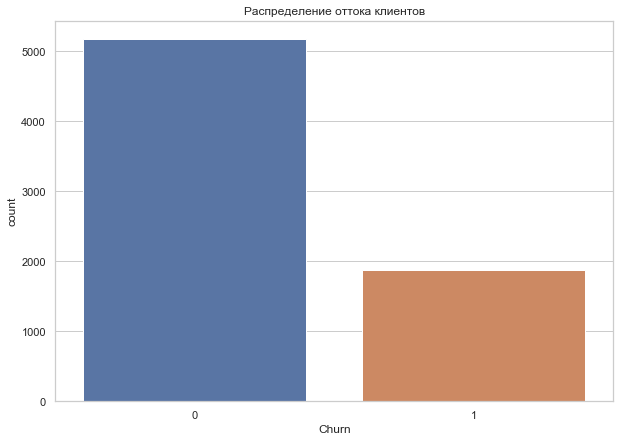

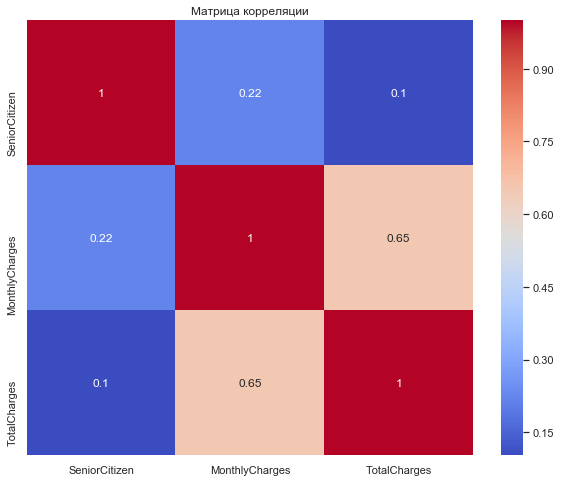

,BeginDate,EndDate,ContractDuration
0,2019-04-29,NaT,9.266667
1,2019-03-26,NaT,10.400000
2,2018-08-09,2019-12-01,15.966667
3,2018-12-22,NaT,13.533333
4,2019-01-26,2019-11-01,9.300000


In [7]:
# Задание эстетического стиля для графиков
sns.set(style="whitegrid")

# Проведение исследовательского анализа
# 1. Распределение оттока
plt.figure(figsize=(10, 7))
sns.countplot(x='Churn', data=merged_data)
plt.title('Распределение оттока клиентов')
plt.show()

# 2. Корреляционный анализ
# Выбор числовых признаков для корреляционного анализа
numerical_features = merged_data.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

# 3. Функция продолжительности контракта
# Создание нового признака «ContractDuration» в месяцах
merged_data['ContractDuration'] = (
    (merged_data['EndDate'].fillna(pd.to_datetime('2020-02-01')) - merged_data['BeginDate'])
    .dt.days / 30
)

merged_data[['BeginDate', 'EndDate', 'ContractDuration']].head()

Исследовательский анализ позволил получить ценную информацию:

1. **Распределение оттока клиентов**:
    - График подсчета показывает распределение ушедших и не ушедших клиентов. Эта визуализация необходима для понимания баланса набора данных.


2. **Корреляционный анализ**:
    - Была создана тепловая карта корреляционной матрицы числовых признаков. Это помогает выявить любые существенные корреляции между признаками, особенно теми, которые могут иметь отношение к оттоку клиентов.


3. **Срок действия контракта**:
    - Был создан новый признак "ContractDuration". Он представляет собой продолжительность контракта в месяцах, рассчитанную как разница между BeginDate и EndDate (при условии, что дата извлечения данных — «01 февраля 2020 г.» для текущих клиентов). Этот признак может иметь решающее значение для прогнозирования оттока клиентов.

In [8]:
# Обработка категориальных переменных
# Выбор категориальных столбцов
categorical_cols = merged_data.select_dtypes(include=['object']).columns

# # Применение label encoding к категориальным столбцам
label_encoder = LabelEncoder()
for col in categorical_cols:
    if col != 'customerID':  # Исключение идентификатора клиента из кодирования
        merged_data[col] = label_encoder.fit_transform(merged_data[col])

# Масштабирование числовых признаков
# Выбор числовых столбцов (за исключением двоичных столбцов, таких как «Отток»)
if 'Churn' in merged_data.columns:
    # Выбор числовых столбцов, исключая «Отток»
    numerical_cols = [col for col in merged_data.select_dtypes(include=['int64', 'float64']).columns if col != 'Churn']
else:
    # Выбор всех числовых столбцов
    numerical_cols = merged_data.select_dtypes(include=['int64', 'float64']).columns

# Применение стандартного масштабирования
scaler = StandardScaler()
merged_data[numerical_cols] = scaler.fit_transform(merged_data[numerical_cols])

# Окончательный набор данных для обучения модели
final_data = merged_data.drop(['customerID'], axis=1)

# Отображение первых нескольких строк обработанных данных
final_data.head()

,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,...,Churn,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ContractDuration
0,0,-0.439916,1,0,2019-04-29,NaT,0,1,2,-1.160323,...,0,0,0,1,0,0,0,0,2,-0.231078
1,1,-0.439916,0,0,2019-03-26,NaT,1,0,3,-0.259629,...,0,0,1,0,1,0,0,0,0,0.174349
2,1,-0.439916,0,0,2018-08-09,2019-12-01,0,1,3,-0.362660,...,1,0,1,1,0,0,0,0,0,2.165711
3,1,-0.439916,0,0,2018-12-22,NaT,1,0,0,-0.746535,...,0,0,1,0,1,1,0,0,2,1.295235
4,0,-0.439916,0,0,2019-01-26,2019-11-01,0,1,2,0.197365,...,1,1,0,0,0,0,0,0,0,-0.219153


Этапы предварительной обработки успешно завершены:

1. **Обработка категориальных переменных:**
    - К категориальным столбцам применено кодирование меток (Label encoding), преобразующее их в числовые значения. `customerID` был исключен из этой кодировки, поскольку это идентификатор.


2. **Масштабирование числовых признаков:**
    - К числовым столбцам применено стандартное масштабирование, нормализующее их распределение.


3. **Окончательный набор данных для обучения модели:**
    - Исключен столбец «customerID», который не используется для обучения модели.
    - Окончательный набор данных готов к следующему этапу обучения модели.

После завершения этих этапов предварительной обработки наш набор данных подготовлен для обучения моделей машинного обучения для прогнозирования оттока клиентов. Следующим шагом будет разделение данных на обучающий и тестовый наборы, выбор подходящих моделей и продолжение процесса обучения и проверки.

## 3. Обучение Моделей

In [9]:
# Определение признаков (X) и таргета (y)
X = final_data.drop(['BeginDate', 'EndDate', 'Churn'], axis=1)
y = final_data['Churn']

# Случайное состояние для воспроизводимости - дата начала проекта
RANDOM_STATE = 150124

# Первое разделение: временный обучающий набор и тестовый набор
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

# Второе разделение: окончательный обучающий набор и набор проверки.
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE)

# Подтверждение разделения
(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

((4225, 18), (1409, 18), (1409, 18), (4225,), (1409,), (1409,))

Набор данных был успешно разделен на обучающий, валидационный и тестовый наборы:

- Обучающий набор: 4225 образца.
- Валидационный набор: 1409 образца.
- Тестовый набор: 1409 образец.
- Признаков в каждом наборе: 18 признаков.
- Целевая переменная («Отток»): присутствует как в обучающих, так и в тестовых наборах.

In [10]:
# Создадим SimpleImputer со стратегией (например, среднее, медиана, самое частое)
imputer = SimpleImputer(strategy='median')

# Подгоним и преобразуем преобразователь к нашим обучающим данным
X_train = imputer.fit_transform(X_train)

# Преобразуем тестовые данные, используя тот же преобразователь
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

# Модель Решающее Дерево (Decision Tree)
dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_model.fit(X_train, y_train)
dt_cv_score = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='roc_auc').mean()

# Модель Случайный Лес (Random Forest)
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)
rf_model.fit(X_train, y_train)
rf_cv_score = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc').mean()

(dt_cv_score, rf_cv_score)

(0.6530359636659389, 0.821585635324191)

Обучение и перекрестная проверка моделей дерева решений и случайного леса успешно завершены. Вот оценки ROC-AUC по результатам 5-кратной перекрестной проверки:

- Модель **Decision Tree** ≈ 0,65.
- Модель **Random Forest** ≈ 0,82.

Модель случайного леса демонстрирует значительно более высокий показатель ROC-AUC по сравнению с моделью дерева решений, что указывает на лучшую эффективность прогнозирования оттока клиентов и что уже очень близко к проектному требованию по метрике.

In [11]:
# Обучение модели XGBoost
xgb_model = XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_cv_score = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='roc_auc').mean()

xgb_cv_score

0.8103737228465787

Как видно, модель XGBoost показала результат послабее, чем Random Forest!

In [12]:
# Настройка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Преобразование данных в тензоры PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Создание наборов данных и загрузчиков данных
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [20]:
# Определение модели нейронной сети
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

# Инициализация нейронной сети
model = NeuralNetwork(X_train.shape[1]).to(device)

# Потеря и оптимизатор с регуляризацией L2 (снижение веса)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)

# Параметры ранней остановки
early_stopping_patience = 10  # Количество эпох ожидания после того, как в последний раз улучшилась валидационная потеря.
best_loss = float('inf')
epochs_no_improve = 0

# Обучение нейронной сети с ранней остановкой
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Валидационная потеря
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val_tensor.to(device))
        val_loss = criterion(y_val_pred, y_val_tensor.to(device).unsqueeze(1))

    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# Оценка
model.eval()
with torch.no_grad():
    y_val_pred = model(X_val_tensor.to(device))
    y_val_pred = y_val_pred.cpu().numpy()
    val_roc_score = roc_auc_score(y_val, y_val_pred)

# Распечатаем или сохраним проверочный показатель ROC-AUC в качестве базовой метрики.
print()
print(f"Оценка ROC-AUC для валидации (Baseline): {val_roc_score:.4f}")

Epoch [1/1000], Loss: 0.6712, Val Loss: 0.7006
Epoch [2/1000], Loss: 0.6744, Val Loss: 0.6977
Epoch [3/1000], Loss: 0.6686, Val Loss: 0.6948
Epoch [4/1000], Loss: 0.6921, Val Loss: 0.6917
Epoch [5/1000], Loss: 0.7060, Val Loss: 0.6884
Epoch [6/1000], Loss: 0.6998, Val Loss: 0.6849
Epoch [7/1000], Loss: 0.6444, Val Loss: 0.6810
Epoch [8/1000], Loss: 0.6725, Val Loss: 0.6766
Epoch [9/1000], Loss: 0.6437, Val Loss: 0.6716
Epoch [10/1000], Loss: 0.5947, Val Loss: 0.6665
Epoch [11/1000], Loss: 0.6655, Val Loss: 0.6611
Epoch [12/1000], Loss: 0.6144, Val Loss: 0.6556
Epoch [13/1000], Loss: 0.5238, Val Loss: 0.6500
Epoch [14/1000], Loss: 0.7738, Val Loss: 0.6443
Epoch [15/1000], Loss: 0.5868, Val Loss: 0.6386
Epoch [16/1000], Loss: 0.5322, Val Loss: 0.6327
Epoch [17/1000], Loss: 0.8114, Val Loss: 0.6267
Epoch [18/1000], Loss: 0.6297, Val Loss: 0.6207
Epoch [19/1000], Loss: 0.6007, Val Loss: 0.6145
Epoch [20/1000], Loss: 0.5404, Val Loss: 0.6085
Epoch [21/1000], Loss: 0.9085, Val Loss: 0.6025
E

Epoch [171/1000], Loss: 0.6520, Val Loss: 0.4653
Epoch [172/1000], Loss: 0.2542, Val Loss: 0.4652
Epoch [173/1000], Loss: 1.1166, Val Loss: 0.4651
Epoch [174/1000], Loss: 0.4117, Val Loss: 0.4650
Epoch [175/1000], Loss: 0.6977, Val Loss: 0.4649
Epoch [176/1000], Loss: 0.5998, Val Loss: 0.4648
Epoch [177/1000], Loss: 0.8747, Val Loss: 0.4647
Epoch [178/1000], Loss: 0.9524, Val Loss: 0.4646
Epoch [179/1000], Loss: 0.6388, Val Loss: 0.4645
Epoch [180/1000], Loss: 0.3910, Val Loss: 0.4644
Epoch [181/1000], Loss: 0.2011, Val Loss: 0.4643
Epoch [182/1000], Loss: 0.2280, Val Loss: 0.4641
Epoch [183/1000], Loss: 0.0291, Val Loss: 0.4640
Epoch [184/1000], Loss: 0.2732, Val Loss: 0.4639
Epoch [185/1000], Loss: 0.0126, Val Loss: 0.4638
Epoch [186/1000], Loss: 0.2647, Val Loss: 0.4638
Epoch [187/1000], Loss: 0.7539, Val Loss: 0.4637
Epoch [188/1000], Loss: 1.0361, Val Loss: 0.4636
Epoch [189/1000], Loss: 0.1507, Val Loss: 0.4634
Epoch [190/1000], Loss: 0.0591, Val Loss: 0.4633
Epoch [191/1000], Lo

Epoch [339/1000], Loss: 0.0047, Val Loss: 0.4545
Epoch [340/1000], Loss: 0.2794, Val Loss: 0.4544
Epoch [341/1000], Loss: 0.2619, Val Loss: 0.4544
Epoch [342/1000], Loss: 0.3526, Val Loss: 0.4544
Epoch [343/1000], Loss: 0.0097, Val Loss: 0.4543
Epoch [344/1000], Loss: 0.1181, Val Loss: 0.4543
Epoch [345/1000], Loss: 0.5049, Val Loss: 0.4543
Epoch [346/1000], Loss: 0.8010, Val Loss: 0.4542
Epoch [347/1000], Loss: 0.0011, Val Loss: 0.4542
Epoch [348/1000], Loss: 0.1503, Val Loss: 0.4542
Epoch [349/1000], Loss: 0.0911, Val Loss: 0.4541
Epoch [350/1000], Loss: 0.0391, Val Loss: 0.4541
Epoch [351/1000], Loss: 0.0567, Val Loss: 0.4541
Epoch [352/1000], Loss: 0.2510, Val Loss: 0.4540
Epoch [353/1000], Loss: 0.7069, Val Loss: 0.4540
Epoch [354/1000], Loss: 0.2363, Val Loss: 0.4539
Epoch [355/1000], Loss: 0.3522, Val Loss: 0.4539
Epoch [356/1000], Loss: 0.0211, Val Loss: 0.4539
Epoch [357/1000], Loss: 0.4249, Val Loss: 0.4538
Epoch [358/1000], Loss: 0.5767, Val Loss: 0.4538
Epoch [359/1000], Lo

Epoch [507/1000], Loss: 0.1861, Val Loss: 0.4502
Epoch [508/1000], Loss: 0.2917, Val Loss: 0.4502
Epoch [509/1000], Loss: 0.2728, Val Loss: 0.4502
Epoch [510/1000], Loss: 0.8183, Val Loss: 0.4502
Epoch [511/1000], Loss: 0.3153, Val Loss: 0.4502
Epoch [512/1000], Loss: 1.3206, Val Loss: 0.4502
Epoch [513/1000], Loss: 0.7348, Val Loss: 0.4502
Epoch [514/1000], Loss: 0.6350, Val Loss: 0.4501
Epoch [515/1000], Loss: 0.0546, Val Loss: 0.4501
Epoch [516/1000], Loss: 0.4213, Val Loss: 0.4501
Epoch [517/1000], Loss: 0.0562, Val Loss: 0.4501
Epoch [518/1000], Loss: 0.2485, Val Loss: 0.4501
Epoch [519/1000], Loss: 0.0420, Val Loss: 0.4501
Epoch [520/1000], Loss: 1.3992, Val Loss: 0.4501
Epoch [521/1000], Loss: 0.0041, Val Loss: 0.4501
Epoch [522/1000], Loss: 0.1234, Val Loss: 0.4501
Epoch [523/1000], Loss: 0.3718, Val Loss: 0.4501
Epoch [524/1000], Loss: 0.3870, Val Loss: 0.4501
Epoch [525/1000], Loss: 0.0142, Val Loss: 0.4500
Epoch [526/1000], Loss: 0.4230, Val Loss: 0.4501
Epoch [527/1000], Lo

Модель нейронной сети, обученная с помощью PyTorch, показала многообещающие результаты (**0.82 ROC-AUC**), однако обучение было приостановлено т.к. потери не улучшались после определенного количества эпох! Но для baseline модели довольно приличный результат, поэтому далее будем использовать Optuna для тюнинга гиперпараметров данной модели. Что было сделано:

1. **Регуляризация:**
    - Добавлены выпадающие слои («nn.Dropout») после некоторых линейных слоев в классе NeuralNetwork. Это случайным образом обнуляет часть входных признаков во время обучения, что помогает предотвратить переобучение.
    - В оптимизаторе добавлена регуляризация L2 (снижение веса). Это наказывает большие веса и помогает предотвратить переобучение.

2. **Ранняя остановка:**
    - Введены параметры для мониторинга потерь при проверке и прекращения обучения, если потери не улучшаются после определенного количества эпох («early_stopping_patience»).
    - В течение каждой эпохи после обучения модель оценивается на проверочном наборе. Если потери при проверке не уменьшаются в течение указанного количества последовательных эпох, обучение прекращается, чтобы предотвратить переобучение.

Модель была обучена с добавленной регуляризацией отсева и реализована ранняя остановка на основе потерь при валидации. Этот подход часто приводит к более обобщаемой модели, которая лучше работает с невидимыми ранее данными.

In [24]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_prob):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, 32)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

def objective(trial: Trial):
    # Предложим гиперпараметры
    hidden_size = trial.suggest_int("hidden_size", 16, 128)  # Отрегулируйте диапазон по мере необходимости
    dropout_prob = trial.suggest_float("dropout_prob", 0.2, 0.8)  # Отрегулируйте диапазон по мере необходимости
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2)  # Отрегулируйте диапазон по мере необходимости
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4)  # Отрегулируйте диапазон по мере необходимости

    # Определим свою модель нейронной сети с помощью предложенных гиперпараметров.
    model = NeuralNetwork(X_train.shape[1], hidden_size, dropout_prob).to(device)

    # Определим оптимизатор с предлагаемой скоростью обучения и затуханием веса.
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Определите критерий (например, BCELoss) вне нашей целевой функции.
    criterion = nn.BCELoss()

    # Определим параметры ранней остановки
    early_stopping_patience = 10
    best_loss = float('inf')
    epochs_no_improve = 0

    # Тренировочный цикл
    num_epochs = 1000
    for epoch in range(num_epochs):
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Потеря валидации и преждевременная остановка
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_tensor.to(device))
            val_loss = criterion(y_val_pred, y_val_tensor.to(device).unsqueeze(1))

        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == early_stopping_patience:
                print(f'Early stopping triggered at epoch {epoch+1}')
                break

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    # Рассчитаем оценку ROC-AUC для данных валидации.
    y_val_pred = y_val_pred.cpu().numpy()
    val_roc_auc = roc_auc_score(y_val, y_val_pred)

    # Вернем оценку ROC-AUC валидации в качестве цели оптимизации.
    return val_roc_auc

study = optuna.create_study(direction="maximize")  # Мы хотим максимизировать ROC-AUC
study.optimize(objective, n_trials=100)  # При необходимости отрегулируйте количество испытаний.

best_params = study.best_params
best_roc_auc = study.best_value

print(f"Best Hyperparameters: {best_params}")
print(f"Best ROC-AUC Score: {best_roc_auc}")

[I 2024-01-16 18:06:23,587] A new study created in memory with name: no-name-5b45d8d3-aa57-493d-bff7-dfc319af812f


Epoch [1/1000], Loss: 0.0623, Val Loss: 0.4679
Epoch [2/1000], Loss: 0.1872, Val Loss: 0.4519
Epoch [3/1000], Loss: 1.6159, Val Loss: 0.4534
Epoch [4/1000], Loss: 0.0138, Val Loss: 0.4496
Epoch [5/1000], Loss: 0.9760, Val Loss: 0.4551
Epoch [6/1000], Loss: 0.2310, Val Loss: 0.4534
Epoch [7/1000], Loss: 0.3264, Val Loss: 0.4596
Epoch [8/1000], Loss: 0.0441, Val Loss: 0.4509
Epoch [9/1000], Loss: 0.3563, Val Loss: 0.4618
Epoch [10/1000], Loss: 0.0426, Val Loss: 0.4544
Epoch [11/1000], Loss: 0.0243, Val Loss: 0.4516
Epoch [12/1000], Loss: 0.8996, Val Loss: 0.4466
Epoch [13/1000], Loss: 0.3263, Val Loss: 0.4485
Epoch [14/1000], Loss: 0.7928, Val Loss: 0.4479
Epoch [15/1000], Loss: 0.6268, Val Loss: 0.4479
Epoch [16/1000], Loss: 0.0043, Val Loss: 0.4504
Epoch [17/1000], Loss: 0.4201, Val Loss: 0.4599
Epoch [18/1000], Loss: 0.5541, Val Loss: 0.4531
Epoch [19/1000], Loss: 0.4758, Val Loss: 0.4583
Epoch [20/1000], Loss: 0.5896, Val Loss: 0.4556
Epoch [21/1000], Loss: 0.1766, Val Loss: 0.4603


[I 2024-01-16 18:06:29,817] Trial 0 finished with value: 0.8198305439010588 and parameters: {'hidden_size': 26, 'dropout_prob': 0.38689108924783444, 'learning_rate': 0.007831404177489183, 'weight_decay': 5.739791571493828e-05}. Best is trial 0 with value: 0.8198305439010588.


Early stopping triggered at epoch 22
Epoch [1/1000], Loss: 0.7050, Val Loss: 0.4555
Epoch [2/1000], Loss: 0.4272, Val Loss: 0.4554
Epoch [3/1000], Loss: 0.6105, Val Loss: 0.4662
Epoch [4/1000], Loss: 0.2800, Val Loss: 0.4464
Epoch [5/1000], Loss: 0.3104, Val Loss: 0.4500
Epoch [6/1000], Loss: 0.0079, Val Loss: 0.4506
Epoch [7/1000], Loss: 0.9012, Val Loss: 0.4508
Epoch [8/1000], Loss: 1.0533, Val Loss: 0.4518
Epoch [9/1000], Loss: 0.2181, Val Loss: 0.4455
Epoch [10/1000], Loss: 0.3596, Val Loss: 0.4530
Epoch [11/1000], Loss: 0.3083, Val Loss: 0.4561
Epoch [12/1000], Loss: 0.0463, Val Loss: 0.4490
Epoch [13/1000], Loss: 0.3624, Val Loss: 0.4514
Epoch [14/1000], Loss: 2.2146, Val Loss: 0.4572
Epoch [15/1000], Loss: 1.0226, Val Loss: 0.4542
Epoch [16/1000], Loss: 0.2873, Val Loss: 0.4594
Epoch [17/1000], Loss: 2.9656, Val Loss: 0.4868
Epoch [18/1000], Loss: 0.1244, Val Loss: 0.4649


[I 2024-01-16 18:06:35,129] Trial 1 finished with value: 0.8183546852776092 and parameters: {'hidden_size': 109, 'dropout_prob': 0.4177091843400278, 'learning_rate': 0.00824620935109586, 'weight_decay': 4.118397744055653e-05}. Best is trial 0 with value: 0.8198305439010588.


Early stopping triggered at epoch 19
Epoch [1/1000], Loss: 0.1183, Val Loss: 0.4502
Epoch [2/1000], Loss: 0.2326, Val Loss: 0.4501
Epoch [3/1000], Loss: 0.2311, Val Loss: 0.4495
Epoch [4/1000], Loss: 0.3995, Val Loss: 0.4512
Epoch [5/1000], Loss: 0.5637, Val Loss: 0.4519
Epoch [6/1000], Loss: 0.4134, Val Loss: 0.4495
Epoch [7/1000], Loss: 0.7676, Val Loss: 0.4495
Epoch [8/1000], Loss: 0.5175, Val Loss: 0.4528
Epoch [9/1000], Loss: 0.0548, Val Loss: 0.4528
Epoch [10/1000], Loss: 1.4342, Val Loss: 0.4473
Epoch [11/1000], Loss: 0.0254, Val Loss: 0.4550
Epoch [12/1000], Loss: 1.2450, Val Loss: 0.4520
Epoch [13/1000], Loss: 0.1501, Val Loss: 0.4574
Epoch [14/1000], Loss: 1.2408, Val Loss: 0.4488
Epoch [15/1000], Loss: 0.2457, Val Loss: 0.4510
Epoch [16/1000], Loss: 0.1712, Val Loss: 0.4480
Epoch [17/1000], Loss: 0.7298, Val Loss: 0.4516
Epoch [18/1000], Loss: 0.5798, Val Loss: 0.4474
Epoch [19/1000], Loss: 0.0877, Val Loss: 0.4487


[I 2024-01-16 18:06:40,489] Trial 2 finished with value: 0.8211764046146709 and parameters: {'hidden_size': 62, 'dropout_prob': 0.3671135122865846, 'learning_rate': 0.004621296273856339, 'weight_decay': 6.745981058546085e-05}. Best is trial 2 with value: 0.8211764046146709.


Early stopping triggered at epoch 20
Epoch [1/1000], Loss: 0.4739, Val Loss: 0.5282
Epoch [2/1000], Loss: 0.5273, Val Loss: 0.4978
Epoch [3/1000], Loss: 0.1559, Val Loss: 0.4857
Epoch [4/1000], Loss: 0.8650, Val Loss: 0.4824
Epoch [5/1000], Loss: 0.5321, Val Loss: 0.4719
Epoch [6/1000], Loss: 0.9770, Val Loss: 0.4824
Epoch [7/1000], Loss: 0.0552, Val Loss: 0.4736
Epoch [8/1000], Loss: 0.0812, Val Loss: 0.4798
Epoch [9/1000], Loss: 0.7125, Val Loss: 0.4636
Epoch [10/1000], Loss: 1.3560, Val Loss: 0.4609
Epoch [11/1000], Loss: 0.0072, Val Loss: 0.4693
Epoch [12/1000], Loss: 0.2566, Val Loss: 0.4717
Epoch [13/1000], Loss: 0.5763, Val Loss: 0.4687
Epoch [14/1000], Loss: 0.0221, Val Loss: 0.4743
Epoch [15/1000], Loss: 1.0718, Val Loss: 0.4704
Epoch [16/1000], Loss: 0.8530, Val Loss: 0.4734
Epoch [17/1000], Loss: 0.6908, Val Loss: 0.4624
Epoch [18/1000], Loss: 0.4215, Val Loss: 0.4595
Epoch [19/1000], Loss: 0.0031, Val Loss: 0.4628
Epoch [20/1000], Loss: 0.0923, Val Loss: 0.4595
Epoch [21/10

[I 2024-01-16 18:06:48,067] Trial 3 finished with value: 0.818698797391885 and parameters: {'hidden_size': 19, 'dropout_prob': 0.7235404784839259, 'learning_rate': 0.00100409593627036, 'weight_decay': 5.384127404838972e-06}. Best is trial 2 with value: 0.8211764046146709.


Early stopping triggered at epoch 30
Epoch [1/1000], Loss: 0.3664, Val Loss: 0.4803
Epoch [2/1000], Loss: 0.1709, Val Loss: 0.4642
Epoch [3/1000], Loss: 0.9967, Val Loss: 0.4649
Epoch [4/1000], Loss: 0.0770, Val Loss: 0.4635
Epoch [5/1000], Loss: 0.2689, Val Loss: 0.4542
Epoch [6/1000], Loss: 1.2883, Val Loss: 0.4560
Epoch [7/1000], Loss: 0.5744, Val Loss: 0.4699
Epoch [8/1000], Loss: 3.5825, Val Loss: 0.4765
Epoch [9/1000], Loss: 0.0584, Val Loss: 0.4518
Epoch [10/1000], Loss: 0.6368, Val Loss: 0.4562
Epoch [11/1000], Loss: 0.6445, Val Loss: 0.4572
Epoch [12/1000], Loss: 0.1585, Val Loss: 0.4539
Epoch [13/1000], Loss: 0.2833, Val Loss: 0.4714
Epoch [14/1000], Loss: 0.1289, Val Loss: 0.4599
Epoch [15/1000], Loss: 0.5125, Val Loss: 0.4560
Epoch [16/1000], Loss: 0.2043, Val Loss: 0.4599
Epoch [17/1000], Loss: 0.6804, Val Loss: 0.4622
Epoch [18/1000], Loss: 0.2398, Val Loss: 0.4639


[I 2024-01-16 18:06:53,414] Trial 4 finished with value: 0.8199783846612662 and parameters: {'hidden_size': 28, 'dropout_prob': 0.7815844004588097, 'learning_rate': 0.005560377686134362, 'weight_decay': 1.7352735013882365e-05}. Best is trial 2 with value: 0.8211764046146709.


Early stopping triggered at epoch 19
Epoch [1/1000], Loss: 0.4200, Val Loss: 0.4575
Epoch [2/1000], Loss: 0.6280, Val Loss: 0.4567
Epoch [3/1000], Loss: 0.0166, Val Loss: 0.4551
Epoch [4/1000], Loss: 0.5054, Val Loss: 0.4561
Epoch [5/1000], Loss: 0.0021, Val Loss: 0.4538
Epoch [6/1000], Loss: 0.6079, Val Loss: 0.4493
Epoch [7/1000], Loss: 0.3401, Val Loss: 0.4481
Epoch [8/1000], Loss: 0.0175, Val Loss: 0.4482
Epoch [9/1000], Loss: 0.1660, Val Loss: 0.4468
Epoch [10/1000], Loss: 0.0171, Val Loss: 0.4483
Epoch [11/1000], Loss: 0.0215, Val Loss: 0.4492
Epoch [12/1000], Loss: 0.4285, Val Loss: 0.4498
Epoch [13/1000], Loss: 1.0477, Val Loss: 0.4512
Epoch [14/1000], Loss: 0.3647, Val Loss: 0.4508
Epoch [15/1000], Loss: 0.0595, Val Loss: 0.4639
Epoch [16/1000], Loss: 0.9850, Val Loss: 0.4551
Epoch [17/1000], Loss: 0.0072, Val Loss: 0.4520
Epoch [18/1000], Loss: 0.4094, Val Loss: 0.4524


[I 2024-01-16 18:06:59,422] Trial 5 finished with value: 0.8176511671773121 and parameters: {'hidden_size': 102, 'dropout_prob': 0.2795778295058234, 'learning_rate': 0.004744692773074152, 'weight_decay': 3.798714971616688e-05}. Best is trial 2 with value: 0.8211764046146709.


Early stopping triggered at epoch 19
Epoch [1/1000], Loss: 0.0014, Val Loss: 0.4552
Epoch [2/1000], Loss: 1.0594, Val Loss: 0.4556
Epoch [3/1000], Loss: 0.3531, Val Loss: 0.4551
Epoch [4/1000], Loss: 0.9780, Val Loss: 0.4546
Epoch [5/1000], Loss: 0.0243, Val Loss: 0.4526
Epoch [6/1000], Loss: 0.6994, Val Loss: 0.4585
Epoch [7/1000], Loss: 0.2175, Val Loss: 0.4505
Epoch [8/1000], Loss: 0.0644, Val Loss: 0.4534
Epoch [9/1000], Loss: 0.4034, Val Loss: 0.4584
Epoch [10/1000], Loss: 0.0009, Val Loss: 0.4510
Epoch [11/1000], Loss: 0.6589, Val Loss: 0.4573
Epoch [12/1000], Loss: 0.3440, Val Loss: 0.4510
Epoch [13/1000], Loss: 0.2164, Val Loss: 0.4516
Epoch [14/1000], Loss: 0.0841, Val Loss: 0.4507
Epoch [15/1000], Loss: 0.1576, Val Loss: 0.4512
Epoch [16/1000], Loss: 1.0063, Val Loss: 0.4564
Epoch [17/1000], Loss: 0.5834, Val Loss: 0.4488
Epoch [18/1000], Loss: 0.4039, Val Loss: 0.4492
Epoch [19/1000], Loss: 0.0429, Val Loss: 0.4479
Epoch [20/1000], Loss: 0.2219, Val Loss: 0.4504
Epoch [21/10

[I 2024-01-16 18:07:09,151] Trial 6 finished with value: 0.8145694520205754 and parameters: {'hidden_size': 122, 'dropout_prob': 0.431927567617601, 'learning_rate': 0.008129404992721318, 'weight_decay': 6.649290843136876e-05}. Best is trial 2 with value: 0.8211764046146709.


Early stopping triggered at epoch 29
Epoch [1/1000], Loss: 0.3600, Val Loss: 0.4621
Epoch [2/1000], Loss: 0.8007, Val Loss: 0.4548
Epoch [3/1000], Loss: 0.5003, Val Loss: 0.4568
Epoch [4/1000], Loss: 0.8810, Val Loss: 0.4589
Epoch [5/1000], Loss: 0.0160, Val Loss: 0.4522
Epoch [6/1000], Loss: 0.0363, Val Loss: 0.4516
Epoch [7/1000], Loss: 0.3988, Val Loss: 0.4488
Epoch [8/1000], Loss: 1.2139, Val Loss: 0.4538
Epoch [9/1000], Loss: 0.5086, Val Loss: 0.4521
Epoch [10/1000], Loss: 0.2327, Val Loss: 0.4534
Epoch [11/1000], Loss: 0.9392, Val Loss: 0.4501
Epoch [12/1000], Loss: 0.3565, Val Loss: 0.4513
Epoch [13/1000], Loss: 1.2467, Val Loss: 0.4515
Epoch [14/1000], Loss: 0.0666, Val Loss: 0.4490
Epoch [15/1000], Loss: 0.0006, Val Loss: 0.4527
Epoch [16/1000], Loss: 0.3649, Val Loss: 0.4535


[I 2024-01-16 18:07:14,323] Trial 7 finished with value: 0.8208093516927767 and parameters: {'hidden_size': 119, 'dropout_prob': 0.715721714291994, 'learning_rate': 0.00630984012073332, 'weight_decay': 2.073129350428529e-05}. Best is trial 2 with value: 0.8211764046146709.


Early stopping triggered at epoch 17
Epoch [1/1000], Loss: 0.6188, Val Loss: 0.4606
Epoch [2/1000], Loss: 0.0157, Val Loss: 0.4520
Epoch [3/1000], Loss: 0.3714, Val Loss: 0.4561
Epoch [4/1000], Loss: 1.0864, Val Loss: 0.4507
Epoch [5/1000], Loss: 0.0533, Val Loss: 0.4505
Epoch [6/1000], Loss: 0.6248, Val Loss: 0.4497
Epoch [7/1000], Loss: 0.0636, Val Loss: 0.4489
Epoch [8/1000], Loss: 1.7633, Val Loss: 0.4520
Epoch [9/1000], Loss: 0.0177, Val Loss: 0.4495
Epoch [10/1000], Loss: 0.2162, Val Loss: 0.4499
Epoch [11/1000], Loss: 0.4467, Val Loss: 0.4504
Epoch [12/1000], Loss: 0.6680, Val Loss: 0.4496
Epoch [13/1000], Loss: 0.3643, Val Loss: 0.4564
Epoch [14/1000], Loss: 0.6195, Val Loss: 0.4491
Epoch [15/1000], Loss: 0.2201, Val Loss: 0.4501
Epoch [16/1000], Loss: 0.0244, Val Loss: 0.4485
Epoch [17/1000], Loss: 0.2837, Val Loss: 0.4535
Epoch [18/1000], Loss: 1.3040, Val Loss: 0.4493
Epoch [19/1000], Loss: 0.0576, Val Loss: 0.4486
Epoch [20/1000], Loss: 1.4985, Val Loss: 0.4518
Epoch [21/10

[I 2024-01-16 18:07:25,113] Trial 8 finished with value: 0.8188695789597108 and parameters: {'hidden_size': 113, 'dropout_prob': 0.6669191635480597, 'learning_rate': 0.002782273997795402, 'weight_decay': 8.748696508410506e-05}. Best is trial 2 with value: 0.8211764046146709.


Early stopping triggered at epoch 38
Epoch [1/1000], Loss: 0.7220, Val Loss: 0.4686
Epoch [2/1000], Loss: 0.4731, Val Loss: 0.4560
Epoch [3/1000], Loss: 2.3273, Val Loss: 0.4547
Epoch [4/1000], Loss: 1.3786, Val Loss: 0.4523
Epoch [5/1000], Loss: 0.0978, Val Loss: 0.4517
Epoch [6/1000], Loss: 0.1136, Val Loss: 0.4496
Epoch [7/1000], Loss: 0.0105, Val Loss: 0.4475
Epoch [8/1000], Loss: 0.3214, Val Loss: 0.4474
Epoch [9/1000], Loss: 0.2119, Val Loss: 0.4508
Epoch [10/1000], Loss: 0.1004, Val Loss: 0.4483
Epoch [11/1000], Loss: 0.4199, Val Loss: 0.4472
Epoch [12/1000], Loss: 0.2202, Val Loss: 0.4470
Epoch [13/1000], Loss: 0.0023, Val Loss: 0.4442
Epoch [14/1000], Loss: 0.2947, Val Loss: 0.4451
Epoch [15/1000], Loss: 0.0025, Val Loss: 0.4501
Epoch [16/1000], Loss: 0.0757, Val Loss: 0.4458
Epoch [17/1000], Loss: 0.0397, Val Loss: 0.4491
Epoch [18/1000], Loss: 0.0130, Val Loss: 0.4455
Epoch [19/1000], Loss: 0.0733, Val Loss: 0.4499
Epoch [20/1000], Loss: 0.0053, Val Loss: 0.4481
Epoch [21/10

[I 2024-01-16 18:07:31,608] Trial 9 finished with value: 0.8194736868936617 and parameters: {'hidden_size': 86, 'dropout_prob': 0.20935671844558998, 'learning_rate': 0.0013822660808353213, 'weight_decay': 6.467808469079452e-05}. Best is trial 2 with value: 0.8211764046146709.


Early stopping triggered at epoch 23
Epoch [1/1000], Loss: 0.0229, Val Loss: 0.4589
Epoch [2/1000], Loss: 0.5534, Val Loss: 0.4578
Epoch [3/1000], Loss: 0.0223, Val Loss: 0.4543
Epoch [4/1000], Loss: 0.4290, Val Loss: 0.4558
Epoch [5/1000], Loss: 0.0124, Val Loss: 0.4545
Epoch [6/1000], Loss: 0.3525, Val Loss: 0.4530
Epoch [7/1000], Loss: 0.5933, Val Loss: 0.4554
Epoch [8/1000], Loss: 0.0881, Val Loss: 0.4550
Epoch [9/1000], Loss: 0.1292, Val Loss: 0.4509
Epoch [10/1000], Loss: 0.9596, Val Loss: 0.4561
Epoch [11/1000], Loss: 0.5032, Val Loss: 0.4586
Epoch [12/1000], Loss: 0.0956, Val Loss: 0.4512
Epoch [13/1000], Loss: 0.1287, Val Loss: 0.4558
Epoch [14/1000], Loss: 0.3124, Val Loss: 0.4559
Epoch [15/1000], Loss: 0.0105, Val Loss: 0.4564
Epoch [16/1000], Loss: 0.2916, Val Loss: 0.4516
Epoch [17/1000], Loss: 1.4081, Val Loss: 0.4540
Epoch [18/1000], Loss: 0.3161, Val Loss: 0.4478
Epoch [19/1000], Loss: 0.0533, Val Loss: 0.4582
Epoch [20/1000], Loss: 1.5765, Val Loss: 0.4526
Epoch [21/10

[I 2024-01-16 18:07:39,175] Trial 10 finished with value: 0.8136836819486433 and parameters: {'hidden_size': 55, 'dropout_prob': 0.571177143544363, 'learning_rate': 0.009915088839491423, 'weight_decay': 9.594124747316027e-05}. Best is trial 2 with value: 0.8211764046146709.


Early stopping triggered at epoch 28
Epoch [1/1000], Loss: 0.7441, Val Loss: 0.4604
Epoch [2/1000], Loss: 0.6332, Val Loss: 0.4568
Epoch [3/1000], Loss: 0.1418, Val Loss: 0.4542
Epoch [4/1000], Loss: 0.0037, Val Loss: 0.4546
Epoch [5/1000], Loss: 0.3559, Val Loss: 0.4622
Epoch [6/1000], Loss: 0.1080, Val Loss: 0.4549
Epoch [7/1000], Loss: 0.2403, Val Loss: 0.4532
Epoch [8/1000], Loss: 0.7189, Val Loss: 0.4519
Epoch [9/1000], Loss: 0.3532, Val Loss: 0.4516
Epoch [10/1000], Loss: 0.3567, Val Loss: 0.4504
Epoch [11/1000], Loss: 0.4805, Val Loss: 0.4517
Epoch [12/1000], Loss: 0.0677, Val Loss: 0.4540
Epoch [13/1000], Loss: 0.0194, Val Loss: 0.4529
Epoch [14/1000], Loss: 0.1614, Val Loss: 0.4505
Epoch [15/1000], Loss: 0.3329, Val Loss: 0.4537
Epoch [16/1000], Loss: 1.5865, Val Loss: 0.4548
Epoch [17/1000], Loss: 0.0101, Val Loss: 0.4499
Epoch [18/1000], Loss: 0.5994, Val Loss: 0.4501
Epoch [19/1000], Loss: 0.0943, Val Loss: 0.4517
Epoch [20/1000], Loss: 3.1562, Val Loss: 0.4586
Epoch [21/10

[I 2024-01-16 18:07:46,829] Trial 11 finished with value: 0.8199771101719542 and parameters: {'hidden_size': 57, 'dropout_prob': 0.5731122085492689, 'learning_rate': 0.00509888168997392, 'weight_decay': 2.1422055854546444e-05}. Best is trial 2 with value: 0.8211764046146709.


Early stopping triggered at epoch 27
Epoch [1/1000], Loss: 0.1529, Val Loss: 0.4614
Epoch [2/1000], Loss: 0.0075, Val Loss: 0.4556
Epoch [3/1000], Loss: 0.4136, Val Loss: 0.4604
Epoch [4/1000], Loss: 0.5475, Val Loss: 0.4617
Epoch [5/1000], Loss: 0.0038, Val Loss: 0.4475
Epoch [6/1000], Loss: 0.4090, Val Loss: 0.4616
Epoch [7/1000], Loss: 0.4482, Val Loss: 0.4481
Epoch [8/1000], Loss: 0.1428, Val Loss: 0.4496
Epoch [9/1000], Loss: 1.1210, Val Loss: 0.4465
Epoch [10/1000], Loss: 0.2012, Val Loss: 0.4541
Epoch [11/1000], Loss: 0.1796, Val Loss: 0.4503
Epoch [12/1000], Loss: 0.2920, Val Loss: 0.4482
Epoch [13/1000], Loss: 0.6123, Val Loss: 0.4508
Epoch [14/1000], Loss: 0.0084, Val Loss: 0.4511
Epoch [15/1000], Loss: 0.1143, Val Loss: 0.4502
Epoch [16/1000], Loss: 0.3520, Val Loss: 0.4622
Epoch [17/1000], Loss: 0.4289, Val Loss: 0.4504
Epoch [18/1000], Loss: 0.0004, Val Loss: 0.4477


[I 2024-01-16 18:07:52,152] Trial 12 finished with value: 0.8213242453748782 and parameters: {'hidden_size': 77, 'dropout_prob': 0.540685735349942, 'learning_rate': 0.0037043330706918332, 'weight_decay': 7.57058007236341e-05}. Best is trial 12 with value: 0.8213242453748782.


Early stopping triggered at epoch 19
Epoch [1/1000], Loss: 0.1130, Val Loss: 0.4630
Epoch [2/1000], Loss: 0.4371, Val Loss: 0.4563
Epoch [3/1000], Loss: 0.1121, Val Loss: 0.4538
Epoch [4/1000], Loss: 0.5941, Val Loss: 0.4507
Epoch [5/1000], Loss: 1.3119, Val Loss: 0.4610
Epoch [6/1000], Loss: 1.8226, Val Loss: 0.4588
Epoch [7/1000], Loss: 0.7764, Val Loss: 0.4501
Epoch [8/1000], Loss: 0.0305, Val Loss: 0.4548
Epoch [9/1000], Loss: 0.6808, Val Loss: 0.4491
Epoch [10/1000], Loss: 3.2780, Val Loss: 0.4503
Epoch [11/1000], Loss: 0.8534, Val Loss: 0.4455
Epoch [12/1000], Loss: 1.8472, Val Loss: 0.4596
Epoch [13/1000], Loss: 0.5416, Val Loss: 0.4480
Epoch [14/1000], Loss: 0.0560, Val Loss: 0.4561
Epoch [15/1000], Loss: 0.0050, Val Loss: 0.4511
Epoch [16/1000], Loss: 0.3750, Val Loss: 0.4460
Epoch [17/1000], Loss: 0.0234, Val Loss: 0.4518
Epoch [18/1000], Loss: 0.6508, Val Loss: 0.4443
Epoch [19/1000], Loss: 0.7960, Val Loss: 0.4462
Epoch [20/1000], Loss: 1.1634, Val Loss: 0.4511
Epoch [21/10

[I 2024-01-16 18:08:00,485] Trial 13 finished with value: 0.8200930886993582 and parameters: {'hidden_size': 73, 'dropout_prob': 0.5398300926860776, 'learning_rate': 0.003578224855652317, 'weight_decay': 7.981563739261573e-05}. Best is trial 12 with value: 0.8213242453748782.


Early stopping triggered at epoch 28
Epoch [1/1000], Loss: 1.3231, Val Loss: 0.4657
Epoch [2/1000], Loss: 0.7573, Val Loss: 0.4557
Epoch [3/1000], Loss: 0.6958, Val Loss: 0.4517
Epoch [4/1000], Loss: 0.7172, Val Loss: 0.4521
Epoch [5/1000], Loss: 0.2067, Val Loss: 0.4500
Epoch [6/1000], Loss: 0.5239, Val Loss: 0.4483
Epoch [7/1000], Loss: 0.1560, Val Loss: 0.4474
Epoch [8/1000], Loss: 0.0388, Val Loss: 0.4512
Epoch [9/1000], Loss: 0.5766, Val Loss: 0.4479
Epoch [10/1000], Loss: 0.0058, Val Loss: 0.4482
Epoch [11/1000], Loss: 0.0592, Val Loss: 0.4473
Epoch [12/1000], Loss: 0.0728, Val Loss: 0.4468
Epoch [13/1000], Loss: 0.1706, Val Loss: 0.4482
Epoch [14/1000], Loss: 1.5922, Val Loss: 0.4489
Epoch [15/1000], Loss: 1.2032, Val Loss: 0.4608
Epoch [16/1000], Loss: 0.6460, Val Loss: 0.4530
Epoch [17/1000], Loss: 0.4456, Val Loss: 0.4552
Epoch [18/1000], Loss: 0.2082, Val Loss: 0.4515
Epoch [19/1000], Loss: 0.1412, Val Loss: 0.4495
Epoch [20/1000], Loss: 0.7593, Val Loss: 0.4487
Epoch [21/10

[I 2024-01-16 18:08:15,467] Trial 14 finished with value: 0.8187395810498734 and parameters: {'hidden_size': 49, 'dropout_prob': 0.28836772886972506, 'learning_rate': 0.003359624413773498, 'weight_decay': 7.484520254196658e-05}. Best is trial 12 with value: 0.8213242453748782.


Early stopping triggered at epoch 49
Epoch [1/1000], Loss: 0.7982, Val Loss: 0.4650
Epoch [2/1000], Loss: 1.1493, Val Loss: 0.4537
Epoch [3/1000], Loss: 0.5079, Val Loss: 0.4507
Epoch [4/1000], Loss: 0.0086, Val Loss: 0.4510
Epoch [5/1000], Loss: 0.5905, Val Loss: 0.4566
Epoch [6/1000], Loss: 0.1689, Val Loss: 0.4470
Epoch [7/1000], Loss: 0.0642, Val Loss: 0.4479
Epoch [8/1000], Loss: 0.2455, Val Loss: 0.4456
Epoch [9/1000], Loss: 2.0772, Val Loss: 0.4502
Epoch [10/1000], Loss: 0.5671, Val Loss: 0.4482
Epoch [11/1000], Loss: 0.0037, Val Loss: 0.4481
Epoch [12/1000], Loss: 1.0285, Val Loss: 0.4455
Epoch [13/1000], Loss: 0.0486, Val Loss: 0.4447
Epoch [14/1000], Loss: 0.0516, Val Loss: 0.4432
Epoch [15/1000], Loss: 0.8799, Val Loss: 0.4468
Epoch [16/1000], Loss: 0.1547, Val Loss: 0.4451
Epoch [17/1000], Loss: 0.0087, Val Loss: 0.4474
Epoch [18/1000], Loss: 0.0474, Val Loss: 0.4442
Epoch [19/1000], Loss: 0.4338, Val Loss: 0.4457
Epoch [20/1000], Loss: 0.3475, Val Loss: 0.4464
Epoch [21/10

[I 2024-01-16 18:08:23,053] Trial 15 finished with value: 0.8194558440432919 and parameters: {'hidden_size': 90, 'dropout_prob': 0.47975301035982376, 'learning_rate': 0.001995785943874576, 'weight_decay': 4.8758636119163024e-05}. Best is trial 12 with value: 0.8213242453748782.


Early stopping triggered at epoch 24
Epoch [1/1000], Loss: 0.0158, Val Loss: 0.4665
Epoch [2/1000], Loss: 0.9316, Val Loss: 0.4627
Epoch [3/1000], Loss: 0.2387, Val Loss: 0.4520
Epoch [4/1000], Loss: 0.4035, Val Loss: 0.4514
Epoch [5/1000], Loss: 1.0281, Val Loss: 0.4502
Epoch [6/1000], Loss: 1.0604, Val Loss: 0.4485
Epoch [7/1000], Loss: 1.0624, Val Loss: 0.4600
Epoch [8/1000], Loss: 0.0724, Val Loss: 0.4557
Epoch [9/1000], Loss: 0.0019, Val Loss: 0.4493
Epoch [10/1000], Loss: 0.1439, Val Loss: 0.4483
Epoch [11/1000], Loss: 0.0376, Val Loss: 0.4491
Epoch [12/1000], Loss: 0.1456, Val Loss: 0.4487
Epoch [13/1000], Loss: 0.0322, Val Loss: 0.4529
Epoch [14/1000], Loss: 0.0111, Val Loss: 0.4559
Epoch [15/1000], Loss: 0.2955, Val Loss: 0.4514
Epoch [16/1000], Loss: 0.2985, Val Loss: 0.4487
Epoch [17/1000], Loss: 1.1127, Val Loss: 0.4491
Epoch [18/1000], Loss: 0.7778, Val Loss: 0.4512
Epoch [19/1000], Loss: 0.3273, Val Loss: 0.4524


[I 2024-01-16 18:08:28,463] Trial 16 finished with value: 0.8211381699353069 and parameters: {'hidden_size': 69, 'dropout_prob': 0.3480600559871301, 'learning_rate': 0.004089286914786433, 'weight_decay': 7.769675484844895e-05}. Best is trial 12 with value: 0.8213242453748782.


Early stopping triggered at epoch 20
Epoch [1/1000], Loss: 0.7127, Val Loss: 0.6554
Epoch [2/1000], Loss: 0.5223, Val Loss: 0.6493
Epoch [3/1000], Loss: 0.6160, Val Loss: 0.6436
Epoch [4/1000], Loss: 0.5917, Val Loss: 0.6380
Epoch [5/1000], Loss: 0.8463, Val Loss: 0.6327
Epoch [6/1000], Loss: 0.5594, Val Loss: 0.6276
Epoch [7/1000], Loss: 0.5051, Val Loss: 0.6225
Epoch [8/1000], Loss: 0.5138, Val Loss: 0.6172
Epoch [9/1000], Loss: 0.5213, Val Loss: 0.6119
Epoch [10/1000], Loss: 0.4862, Val Loss: 0.6065
Epoch [11/1000], Loss: 0.4979, Val Loss: 0.6008
Epoch [12/1000], Loss: 0.4328, Val Loss: 0.5950
Epoch [13/1000], Loss: 0.4883, Val Loss: 0.5893
Epoch [14/1000], Loss: 0.2676, Val Loss: 0.5833
Epoch [15/1000], Loss: 0.5186, Val Loss: 0.5773
Epoch [16/1000], Loss: 0.4484, Val Loss: 0.5713
Epoch [17/1000], Loss: 0.4125, Val Loss: 0.5657
Epoch [18/1000], Loss: 0.2879, Val Loss: 0.5605
Epoch [19/1000], Loss: 0.3263, Val Loss: 0.5558
Epoch [20/1000], Loss: 0.3409, Val Loss: 0.5513
Epoch [21/10

Epoch [170/1000], Loss: 0.3459, Val Loss: 0.4632
Epoch [171/1000], Loss: 0.2065, Val Loss: 0.4632
Epoch [172/1000], Loss: 0.3599, Val Loss: 0.4630
Epoch [173/1000], Loss: 0.5837, Val Loss: 0.4629
Epoch [174/1000], Loss: 0.0193, Val Loss: 0.4628
Epoch [175/1000], Loss: 0.2699, Val Loss: 0.4627
Epoch [176/1000], Loss: 0.0334, Val Loss: 0.4626
Epoch [177/1000], Loss: 0.0950, Val Loss: 0.4625
Epoch [178/1000], Loss: 0.1136, Val Loss: 0.4623
Epoch [179/1000], Loss: 0.9344, Val Loss: 0.4623
Epoch [180/1000], Loss: 0.7512, Val Loss: 0.4622
Epoch [181/1000], Loss: 0.5001, Val Loss: 0.4620
Epoch [182/1000], Loss: 0.8573, Val Loss: 0.4619
Epoch [183/1000], Loss: 0.5764, Val Loss: 0.4618
Epoch [184/1000], Loss: 0.0073, Val Loss: 0.4617
Epoch [185/1000], Loss: 0.0026, Val Loss: 0.4616
Epoch [186/1000], Loss: 0.7545, Val Loss: 0.4615
Epoch [187/1000], Loss: 0.1605, Val Loss: 0.4614
Epoch [188/1000], Loss: 0.1815, Val Loss: 0.4613
Epoch [189/1000], Loss: 2.3790, Val Loss: 0.4612
Epoch [190/1000], Lo

Epoch [338/1000], Loss: 0.5344, Val Loss: 0.4528
Epoch [339/1000], Loss: 0.0150, Val Loss: 0.4528
Epoch [340/1000], Loss: 0.3776, Val Loss: 0.4528
Epoch [341/1000], Loss: 0.5779, Val Loss: 0.4528
Epoch [342/1000], Loss: 0.8411, Val Loss: 0.4527
Epoch [343/1000], Loss: 0.2811, Val Loss: 0.4527
Epoch [344/1000], Loss: 0.0033, Val Loss: 0.4527
Epoch [345/1000], Loss: 0.8447, Val Loss: 0.4527
Epoch [346/1000], Loss: 0.0079, Val Loss: 0.4526
Epoch [347/1000], Loss: 0.5701, Val Loss: 0.4526
Epoch [348/1000], Loss: 0.4954, Val Loss: 0.4525
Epoch [349/1000], Loss: 0.7195, Val Loss: 0.4525
Epoch [350/1000], Loss: 0.3101, Val Loss: 0.4524
Epoch [351/1000], Loss: 0.0431, Val Loss: 0.4524
Epoch [352/1000], Loss: 0.0520, Val Loss: 0.4524
Epoch [353/1000], Loss: 0.6561, Val Loss: 0.4524
Epoch [354/1000], Loss: 0.0640, Val Loss: 0.4524
Epoch [355/1000], Loss: 0.4558, Val Loss: 0.4523
Epoch [356/1000], Loss: 0.7128, Val Loss: 0.4523
Epoch [357/1000], Loss: 0.5595, Val Loss: 0.4522
Epoch [358/1000], Lo

[I 2024-01-16 18:10:43,278] Trial 17 finished with value: 0.8212911086527628 and parameters: {'hidden_size': 43, 'dropout_prob': 0.4980128570521487, 'learning_rate': 1.8041679326541958e-05, 'weight_decay': 9.58102124900193e-05}. Best is trial 12 with value: 0.8213242453748782.


Early stopping triggered at epoch 484
Epoch [1/1000], Loss: 0.4423, Val Loss: 0.6187
Epoch [2/1000], Loss: 0.9417, Val Loss: 0.5623
Epoch [3/1000], Loss: 0.1311, Val Loss: 0.5295
Epoch [4/1000], Loss: 0.1740, Val Loss: 0.5136
Epoch [5/1000], Loss: 0.3253, Val Loss: 0.5042
Epoch [6/1000], Loss: 0.0895, Val Loss: 0.4949
Epoch [7/1000], Loss: 0.1226, Val Loss: 0.4871
Epoch [8/1000], Loss: 0.9711, Val Loss: 0.4812
Epoch [9/1000], Loss: 0.5505, Val Loss: 0.4765
Epoch [10/1000], Loss: 0.4049, Val Loss: 0.4736
Epoch [11/1000], Loss: 0.0608, Val Loss: 0.4711
Epoch [12/1000], Loss: 0.3466, Val Loss: 0.4685
Epoch [13/1000], Loss: 0.7763, Val Loss: 0.4666
Epoch [14/1000], Loss: 1.8089, Val Loss: 0.4652
Epoch [15/1000], Loss: 0.0075, Val Loss: 0.4642
Epoch [16/1000], Loss: 0.0776, Val Loss: 0.4625
Epoch [17/1000], Loss: 0.4876, Val Loss: 0.4619
Epoch [18/1000], Loss: 0.0264, Val Loss: 0.4608
Epoch [19/1000], Loss: 0.8424, Val Loss: 0.4594
Epoch [20/1000], Loss: 0.7155, Val Loss: 0.4586
Epoch [21/1

[I 2024-01-16 18:11:04,750] Trial 18 finished with value: 0.8217499248051305 and parameters: {'hidden_size': 41, 'dropout_prob': 0.6297932242395012, 'learning_rate': 0.00015976743969715784, 'weight_decay': 9.963549838526717e-05}. Best is trial 18 with value: 0.8217499248051305.


Early stopping triggered at epoch 82
Epoch [1/1000], Loss: 0.7507, Val Loss: 0.7041
Epoch [2/1000], Loss: 0.6699, Val Loss: 0.7009
Epoch [3/1000], Loss: 0.6278, Val Loss: 0.6984
Epoch [4/1000], Loss: 0.7231, Val Loss: 0.6963
Epoch [5/1000], Loss: 0.6886, Val Loss: 0.6943
Epoch [6/1000], Loss: 0.7735, Val Loss: 0.6922
Epoch [7/1000], Loss: 0.6811, Val Loss: 0.6900
Epoch [8/1000], Loss: 0.6896, Val Loss: 0.6875
Epoch [9/1000], Loss: 0.6992, Val Loss: 0.6847
Epoch [10/1000], Loss: 0.6890, Val Loss: 0.6811
Epoch [11/1000], Loss: 0.7853, Val Loss: 0.6768
Epoch [12/1000], Loss: 0.6342, Val Loss: 0.6719
Epoch [13/1000], Loss: 0.7218, Val Loss: 0.6656
Epoch [14/1000], Loss: 0.5435, Val Loss: 0.6582
Epoch [15/1000], Loss: 0.7759, Val Loss: 0.6497
Epoch [16/1000], Loss: 0.6294, Val Loss: 0.6401
Epoch [17/1000], Loss: 0.8456, Val Loss: 0.6293
Epoch [18/1000], Loss: 0.5140, Val Loss: 0.6178
Epoch [19/1000], Loss: 0.8167, Val Loss: 0.6059
Epoch [20/1000], Loss: 0.4892, Val Loss: 0.5943
Epoch [21/10

Epoch [170/1000], Loss: 0.0414, Val Loss: 0.4643
Epoch [171/1000], Loss: 1.5315, Val Loss: 0.4642
Epoch [172/1000], Loss: 0.0570, Val Loss: 0.4641
Epoch [173/1000], Loss: 1.1978, Val Loss: 0.4640
Epoch [174/1000], Loss: 0.0398, Val Loss: 0.4639
Epoch [175/1000], Loss: 0.5399, Val Loss: 0.4638
Epoch [176/1000], Loss: 0.0721, Val Loss: 0.4637
Epoch [177/1000], Loss: 0.0977, Val Loss: 0.4635
Epoch [178/1000], Loss: 1.5154, Val Loss: 0.4635
Epoch [179/1000], Loss: 0.6913, Val Loss: 0.4633
Epoch [180/1000], Loss: 3.2650, Val Loss: 0.4633
Epoch [181/1000], Loss: 0.3817, Val Loss: 0.4632
Epoch [182/1000], Loss: 0.0901, Val Loss: 0.4631
Epoch [183/1000], Loss: 0.4076, Val Loss: 0.4630
Epoch [184/1000], Loss: 0.6700, Val Loss: 0.4628
Epoch [185/1000], Loss: 0.5602, Val Loss: 0.4628
Epoch [186/1000], Loss: 0.6271, Val Loss: 0.4627
Epoch [187/1000], Loss: 0.0040, Val Loss: 0.4626
Epoch [188/1000], Loss: 0.6249, Val Loss: 0.4625
Epoch [189/1000], Loss: 0.6695, Val Loss: 0.4624
Epoch [190/1000], Lo

Epoch [338/1000], Loss: 0.2454, Val Loss: 0.4531
Epoch [339/1000], Loss: 0.0637, Val Loss: 0.4531
Epoch [340/1000], Loss: 0.1856, Val Loss: 0.4530
Epoch [341/1000], Loss: 0.5995, Val Loss: 0.4530
Epoch [342/1000], Loss: 0.2756, Val Loss: 0.4530
Epoch [343/1000], Loss: 0.9818, Val Loss: 0.4529
Epoch [344/1000], Loss: 0.7480, Val Loss: 0.4529
Epoch [345/1000], Loss: 0.0517, Val Loss: 0.4529
Epoch [346/1000], Loss: 0.4122, Val Loss: 0.4529
Epoch [347/1000], Loss: 0.4155, Val Loss: 0.4528
Epoch [348/1000], Loss: 0.6891, Val Loss: 0.4528
Epoch [349/1000], Loss: 0.6881, Val Loss: 0.4527
Epoch [350/1000], Loss: 0.7100, Val Loss: 0.4527
Epoch [351/1000], Loss: 0.3088, Val Loss: 0.4527
Epoch [352/1000], Loss: 0.4062, Val Loss: 0.4526
Epoch [353/1000], Loss: 0.6112, Val Loss: 0.4526
Epoch [354/1000], Loss: 1.0210, Val Loss: 0.4525
Epoch [355/1000], Loss: 1.0205, Val Loss: 0.4525
Epoch [356/1000], Loss: 0.0612, Val Loss: 0.4525
Epoch [357/1000], Loss: 0.0104, Val Loss: 0.4524
Epoch [358/1000], Lo

Epoch [506/1000], Loss: 0.3755, Val Loss: 0.4493
Epoch [507/1000], Loss: 0.2778, Val Loss: 0.4493
Epoch [508/1000], Loss: 0.0040, Val Loss: 0.4493
Epoch [509/1000], Loss: 0.8037, Val Loss: 0.4492
Epoch [510/1000], Loss: 0.2571, Val Loss: 0.4492
Epoch [511/1000], Loss: 0.2813, Val Loss: 0.4492
Epoch [512/1000], Loss: 1.0433, Val Loss: 0.4492
Epoch [513/1000], Loss: 0.0060, Val Loss: 0.4491
Epoch [514/1000], Loss: 0.6572, Val Loss: 0.4491
Epoch [515/1000], Loss: 0.1227, Val Loss: 0.4491
Epoch [516/1000], Loss: 0.4187, Val Loss: 0.4491
Epoch [517/1000], Loss: 0.0045, Val Loss: 0.4491
Epoch [518/1000], Loss: 0.7553, Val Loss: 0.4491
Epoch [519/1000], Loss: 0.1331, Val Loss: 0.4491
Epoch [520/1000], Loss: 0.4927, Val Loss: 0.4491
Epoch [521/1000], Loss: 0.4907, Val Loss: 0.4490
Epoch [522/1000], Loss: 0.0199, Val Loss: 0.4490
Epoch [523/1000], Loss: 0.1178, Val Loss: 0.4489
Epoch [524/1000], Loss: 0.2642, Val Loss: 0.4489
Epoch [525/1000], Loss: 0.0987, Val Loss: 0.4488
Epoch [526/1000], Lo

[I 2024-01-16 18:14:06,697] Trial 19 finished with value: 0.8240159668021024 and parameters: {'hidden_size': 38, 'dropout_prob': 0.6332309344490077, 'learning_rate': 2.2408720229007666e-05, 'weight_decay': 9.95509226926929e-05}. Best is trial 19 with value: 0.8240159668021024.


Early stopping triggered at epoch 652
Epoch [1/1000], Loss: 0.7658, Val Loss: 0.7060
Epoch [2/1000], Loss: 0.6881, Val Loss: 0.6689
Epoch [3/1000], Loss: 0.3664, Val Loss: 0.6200
Epoch [4/1000], Loss: 0.2743, Val Loss: 0.5744
Epoch [5/1000], Loss: 0.4841, Val Loss: 0.5480
Epoch [6/1000], Loss: 0.4790, Val Loss: 0.5343
Epoch [7/1000], Loss: 1.3698, Val Loss: 0.5251
Epoch [8/1000], Loss: 0.4778, Val Loss: 0.5194
Epoch [9/1000], Loss: 0.0503, Val Loss: 0.5140
Epoch [10/1000], Loss: 0.2082, Val Loss: 0.5086
Epoch [11/1000], Loss: 0.0574, Val Loss: 0.5043
Epoch [12/1000], Loss: 0.6147, Val Loss: 0.5009
Epoch [13/1000], Loss: 0.1882, Val Loss: 0.4975
Epoch [14/1000], Loss: 0.2510, Val Loss: 0.4945
Epoch [15/1000], Loss: 0.8824, Val Loss: 0.4913
Epoch [16/1000], Loss: 0.1993, Val Loss: 0.4890
Epoch [17/1000], Loss: 0.7764, Val Loss: 0.4863
Epoch [18/1000], Loss: 0.0946, Val Loss: 0.4840
Epoch [19/1000], Loss: 0.1395, Val Loss: 0.4824
Epoch [20/1000], Loss: 0.8118, Val Loss: 0.4804
Epoch [21/1

[I 2024-01-16 18:14:55,257] Trial 20 finished with value: 0.8195361368699562 and parameters: {'hidden_size': 41, 'dropout_prob': 0.6381782923919525, 'learning_rate': 7.367382472709529e-05, 'weight_decay': 9.836691922533448e-05}. Best is trial 19 with value: 0.8240159668021024.


Early stopping triggered at epoch 168
Epoch [1/1000], Loss: 0.1283, Val Loss: 0.4752
Epoch [2/1000], Loss: 0.1894, Val Loss: 0.4672
Epoch [3/1000], Loss: 0.0113, Val Loss: 0.4590
Epoch [4/1000], Loss: 0.4776, Val Loss: 0.4546
Epoch [5/1000], Loss: 0.0875, Val Loss: 0.4543
Epoch [6/1000], Loss: 0.3289, Val Loss: 0.4539
Epoch [7/1000], Loss: 2.2001, Val Loss: 0.4501
Epoch [8/1000], Loss: 0.2297, Val Loss: 0.4519
Epoch [9/1000], Loss: 0.4224, Val Loss: 0.4480
Epoch [10/1000], Loss: 0.9881, Val Loss: 0.4487
Epoch [11/1000], Loss: 0.5388, Val Loss: 0.4487
Epoch [12/1000], Loss: 0.4559, Val Loss: 0.4531
Epoch [13/1000], Loss: 0.5145, Val Loss: 0.4550
Epoch [14/1000], Loss: 0.0932, Val Loss: 0.4541
Epoch [15/1000], Loss: 0.3210, Val Loss: 0.4527
Epoch [16/1000], Loss: 0.0586, Val Loss: 0.4534
Epoch [17/1000], Loss: 0.3109, Val Loss: 0.4493
Epoch [18/1000], Loss: 0.0901, Val Loss: 0.4535


[I 2024-01-16 18:15:01,077] Trial 21 finished with value: 0.8196572133546088 and parameters: {'hidden_size': 33, 'dropout_prob': 0.6122567620624586, 'learning_rate': 0.0021687376509674566, 'weight_decay': 8.620967826857434e-05}. Best is trial 19 with value: 0.8240159668021024.


Early stopping triggered at epoch 19
Epoch [1/1000], Loss: 0.0795, Val Loss: 0.4851
Epoch [2/1000], Loss: 0.4551, Val Loss: 0.4684
Epoch [3/1000], Loss: 0.9342, Val Loss: 0.4585
Epoch [4/1000], Loss: 0.3182, Val Loss: 0.4529
Epoch [5/1000], Loss: 0.9179, Val Loss: 0.4507
Epoch [6/1000], Loss: 0.0876, Val Loss: 0.4508
Epoch [7/1000], Loss: 0.6328, Val Loss: 0.4490
Epoch [8/1000], Loss: 0.4356, Val Loss: 0.4489
Epoch [9/1000], Loss: 0.0182, Val Loss: 0.4491
Epoch [10/1000], Loss: 0.1157, Val Loss: 0.4474
Epoch [11/1000], Loss: 0.9690, Val Loss: 0.4474
Epoch [12/1000], Loss: 1.1433, Val Loss: 0.4488
Epoch [13/1000], Loss: 0.0033, Val Loss: 0.4483
Epoch [14/1000], Loss: 0.0437, Val Loss: 0.4477
Epoch [15/1000], Loss: 0.3363, Val Loss: 0.4478
Epoch [16/1000], Loss: 0.3287, Val Loss: 0.4482
Epoch [17/1000], Loss: 0.3536, Val Loss: 0.4467
Epoch [18/1000], Loss: 2.5096, Val Loss: 0.4464
Epoch [19/1000], Loss: 0.1106, Val Loss: 0.4465
Epoch [20/1000], Loss: 0.0375, Val Loss: 0.4469
Epoch [21/10

[I 2024-01-16 18:15:12,704] Trial 22 finished with value: 0.8228944162074256 and parameters: {'hidden_size': 80, 'dropout_prob': 0.6667854035333941, 'learning_rate': 0.0009214723327594473, 'weight_decay': 8.858810488145207e-05}. Best is trial 19 with value: 0.8240159668021024.


Early stopping triggered at epoch 40
Epoch [1/1000], Loss: 1.8952, Val Loss: 0.5165
Epoch [2/1000], Loss: 0.2639, Val Loss: 0.4677
Epoch [3/1000], Loss: 0.6531, Val Loss: 0.4624
Epoch [4/1000], Loss: 0.2290, Val Loss: 0.4566
Epoch [5/1000], Loss: 1.0221, Val Loss: 0.4526
Epoch [6/1000], Loss: 0.6456, Val Loss: 0.4514
Epoch [7/1000], Loss: 0.8339, Val Loss: 0.4516
Epoch [8/1000], Loss: 1.5937, Val Loss: 0.4520
Epoch [9/1000], Loss: 0.0372, Val Loss: 0.4488
Epoch [10/1000], Loss: 1.2668, Val Loss: 0.4486
Epoch [11/1000], Loss: 0.7436, Val Loss: 0.4487
Epoch [12/1000], Loss: 0.4451, Val Loss: 0.4490
Epoch [13/1000], Loss: 0.1686, Val Loss: 0.4489
Epoch [14/1000], Loss: 0.2652, Val Loss: 0.4491
Epoch [15/1000], Loss: 0.5059, Val Loss: 0.4497
Epoch [16/1000], Loss: 0.5184, Val Loss: 0.4479
Epoch [17/1000], Loss: 3.8249, Val Loss: 0.4487
Epoch [18/1000], Loss: 0.0414, Val Loss: 0.4497
Epoch [19/1000], Loss: 0.0094, Val Loss: 0.4483
Epoch [20/1000], Loss: 0.6993, Val Loss: 0.4469
Epoch [21/10

[I 2024-01-16 18:15:20,893] Trial 23 finished with value: 0.8219691369668175 and parameters: {'hidden_size': 37, 'dropout_prob': 0.7010080179689446, 'learning_rate': 0.00106170559841212, 'weight_decay': 8.784571569560743e-05}. Best is trial 19 with value: 0.8240159668021024.


Early stopping triggered at epoch 30
Epoch [1/1000], Loss: 1.0256, Val Loss: 0.4850
Epoch [2/1000], Loss: 0.5648, Val Loss: 0.4699
Epoch [3/1000], Loss: 0.2001, Val Loss: 0.4629
Epoch [4/1000], Loss: 3.3416, Val Loss: 0.4594
Epoch [5/1000], Loss: 1.2205, Val Loss: 0.4567
Epoch [6/1000], Loss: 0.8136, Val Loss: 0.4574
Epoch [7/1000], Loss: 0.3896, Val Loss: 0.4547
Epoch [8/1000], Loss: 0.0089, Val Loss: 0.4539
Epoch [9/1000], Loss: 0.0135, Val Loss: 0.4509
Epoch [10/1000], Loss: 0.6803, Val Loss: 0.4519
Epoch [11/1000], Loss: 0.7987, Val Loss: 0.4497
Epoch [12/1000], Loss: 0.0108, Val Loss: 0.4504
Epoch [13/1000], Loss: 0.3583, Val Loss: 0.4497
Epoch [14/1000], Loss: 0.1049, Val Loss: 0.4509
Epoch [15/1000], Loss: 0.1784, Val Loss: 0.4496
Epoch [16/1000], Loss: 0.5949, Val Loss: 0.4501
Epoch [17/1000], Loss: 0.1425, Val Loss: 0.4498
Epoch [18/1000], Loss: 0.4346, Val Loss: 0.4506
Epoch [19/1000], Loss: 1.1218, Val Loss: 0.4511
Epoch [20/1000], Loss: 0.4603, Val Loss: 0.4503
Epoch [21/10

[I 2024-01-16 18:15:30,767] Trial 24 finished with value: 0.8212605209092716 and parameters: {'hidden_size': 89, 'dropout_prob': 0.7757321705115664, 'learning_rate': 0.0010654858581604853, 'weight_decay': 8.781571776959472e-05}. Best is trial 19 with value: 0.8240159668021024.


Early stopping triggered at epoch 37
Epoch [1/1000], Loss: 0.8992, Val Loss: 0.4960
Epoch [2/1000], Loss: 0.1891, Val Loss: 0.4726
Epoch [3/1000], Loss: 0.0494, Val Loss: 0.4811
Epoch [4/1000], Loss: 0.9408, Val Loss: 0.4611
Epoch [5/1000], Loss: 0.1000, Val Loss: 0.4613
Epoch [6/1000], Loss: 0.1570, Val Loss: 0.4618
Epoch [7/1000], Loss: 0.5464, Val Loss: 0.4605
Epoch [8/1000], Loss: 0.6919, Val Loss: 0.4693
Epoch [9/1000], Loss: 1.9257, Val Loss: 0.4577
Epoch [10/1000], Loss: 0.1858, Val Loss: 0.4563
Epoch [11/1000], Loss: 0.2625, Val Loss: 0.4541
Epoch [12/1000], Loss: 0.0443, Val Loss: 0.4742
Epoch [13/1000], Loss: 0.0534, Val Loss: 0.4639
Epoch [14/1000], Loss: 0.0936, Val Loss: 0.4685
Epoch [15/1000], Loss: 0.5826, Val Loss: 0.4608
Epoch [16/1000], Loss: 0.2182, Val Loss: 0.4590
Epoch [17/1000], Loss: 0.1696, Val Loss: 0.4577
Epoch [18/1000], Loss: 0.8846, Val Loss: 0.4649
Epoch [19/1000], Loss: 0.0744, Val Loss: 0.4580
Epoch [20/1000], Loss: 0.0175, Val Loss: 0.4644


[I 2024-01-16 18:15:36,464] Trial 25 finished with value: 0.8231722548774706 and parameters: {'hidden_size': 18, 'dropout_prob': 0.7148173085419363, 'learning_rate': 0.0017958358217532368, 'weight_decay': 8.826894197784329e-05}. Best is trial 19 with value: 0.8240159668021024.


Early stopping triggered at epoch 21
Epoch [1/1000], Loss: 0.5129, Val Loss: 0.5080
Epoch [2/1000], Loss: 0.3900, Val Loss: 0.4746
Epoch [3/1000], Loss: 0.2764, Val Loss: 0.4636
Epoch [4/1000], Loss: 0.6591, Val Loss: 0.4622
Epoch [5/1000], Loss: 0.8269, Val Loss: 0.4586
Epoch [6/1000], Loss: 1.0472, Val Loss: 0.4597
Epoch [7/1000], Loss: 0.1378, Val Loss: 0.4578
Epoch [8/1000], Loss: 1.6047, Val Loss: 0.4568
Epoch [9/1000], Loss: 0.0139, Val Loss: 0.4538
Epoch [10/1000], Loss: 0.5034, Val Loss: 0.4509
Epoch [11/1000], Loss: 1.1574, Val Loss: 0.4524
Epoch [12/1000], Loss: 0.1567, Val Loss: 0.4543
Epoch [13/1000], Loss: 0.3677, Val Loss: 0.4556
Epoch [14/1000], Loss: 0.4519, Val Loss: 0.4564
Epoch [15/1000], Loss: 0.0628, Val Loss: 0.4549
Epoch [16/1000], Loss: 0.5577, Val Loss: 0.4550
Epoch [17/1000], Loss: 0.2183, Val Loss: 0.4516
Epoch [18/1000], Loss: 0.0237, Val Loss: 0.4527
Epoch [19/1000], Loss: 0.5500, Val Loss: 0.4527


[I 2024-01-16 18:15:42,083] Trial 26 finished with value: 0.818084493543437 and parameters: {'hidden_size': 17, 'dropout_prob': 0.6781824335348343, 'learning_rate': 0.002179385906216318, 'weight_decay': 9.092255079739619e-05}. Best is trial 19 with value: 0.8240159668021024.


Early stopping triggered at epoch 20
Epoch [1/1000], Loss: 0.4057, Val Loss: 0.4777
Epoch [2/1000], Loss: 1.7359, Val Loss: 0.4563
Epoch [3/1000], Loss: 0.8769, Val Loss: 0.4520
Epoch [4/1000], Loss: 0.0030, Val Loss: 0.4585
Epoch [5/1000], Loss: 0.0123, Val Loss: 0.4501
Epoch [6/1000], Loss: 0.4569, Val Loss: 0.4514
Epoch [7/1000], Loss: 0.1585, Val Loss: 0.4493
Epoch [8/1000], Loss: 0.7188, Val Loss: 0.4487
Epoch [9/1000], Loss: 0.6161, Val Loss: 0.4576
Epoch [10/1000], Loss: 0.2659, Val Loss: 0.4495
Epoch [11/1000], Loss: 0.2281, Val Loss: 0.4528
Epoch [12/1000], Loss: 1.1123, Val Loss: 0.4521
Epoch [13/1000], Loss: 0.0348, Val Loss: 0.4508
Epoch [14/1000], Loss: 0.6473, Val Loss: 0.4503
Epoch [15/1000], Loss: 0.6849, Val Loss: 0.4509
Epoch [16/1000], Loss: 1.5797, Val Loss: 0.4494
Epoch [17/1000], Loss: 0.1791, Val Loss: 0.4490


[I 2024-01-16 18:15:47,309] Trial 27 finished with value: 0.8209317026667415 and parameters: {'hidden_size': 97, 'dropout_prob': 0.7602292323748097, 'learning_rate': 0.002882388836963799, 'weight_decay': 8.204101773179926e-05}. Best is trial 19 with value: 0.8240159668021024.


Early stopping triggered at epoch 18
Epoch [1/1000], Loss: 1.5249, Val Loss: 0.5296
Epoch [2/1000], Loss: 0.1485, Val Loss: 0.4979
Epoch [3/1000], Loss: 0.0438, Val Loss: 0.4821
Epoch [4/1000], Loss: 0.4766, Val Loss: 0.4764
Epoch [5/1000], Loss: 0.7199, Val Loss: 0.4665
Epoch [6/1000], Loss: 0.0166, Val Loss: 0.4683
Epoch [7/1000], Loss: 0.0126, Val Loss: 0.4640
Epoch [8/1000], Loss: 0.1287, Val Loss: 0.4641
Epoch [9/1000], Loss: 0.5055, Val Loss: 0.4609
Epoch [10/1000], Loss: 0.0312, Val Loss: 0.4605
Epoch [11/1000], Loss: 0.1785, Val Loss: 0.4594
Epoch [12/1000], Loss: 0.6472, Val Loss: 0.4607
Epoch [13/1000], Loss: 0.0049, Val Loss: 0.4572
Epoch [14/1000], Loss: 0.1210, Val Loss: 0.4623
Epoch [15/1000], Loss: 0.3314, Val Loss: 0.4591
Epoch [16/1000], Loss: 0.7354, Val Loss: 0.4636
Epoch [17/1000], Loss: 0.6122, Val Loss: 0.4556
Epoch [18/1000], Loss: 0.4218, Val Loss: 0.4583
Epoch [19/1000], Loss: 0.3010, Val Loss: 0.4555
Epoch [20/1000], Loss: 0.0168, Val Loss: 0.4554
Epoch [21/10

[I 2024-01-16 18:15:59,603] Trial 28 finished with value: 0.8206946476546848 and parameters: {'hidden_size': 25, 'dropout_prob': 0.7399633415163763, 'learning_rate': 0.0006985751866951373, 'weight_decay': 6.100251395766454e-05}. Best is trial 19 with value: 0.8240159668021024.


Early stopping triggered at epoch 41
Epoch [1/1000], Loss: 0.8268, Val Loss: 0.4728
Epoch [2/1000], Loss: 0.0142, Val Loss: 0.4630
Epoch [3/1000], Loss: 0.6044, Val Loss: 0.4579
Epoch [4/1000], Loss: 0.8327, Val Loss: 0.4528
Epoch [5/1000], Loss: 0.0297, Val Loss: 0.4536
Epoch [6/1000], Loss: 0.2704, Val Loss: 0.4498
Epoch [7/1000], Loss: 1.3635, Val Loss: 0.4493
Epoch [8/1000], Loss: 0.5825, Val Loss: 0.4515
Epoch [9/1000], Loss: 0.1230, Val Loss: 0.4489
Epoch [10/1000], Loss: 0.4645, Val Loss: 0.4497
Epoch [11/1000], Loss: 0.1403, Val Loss: 0.4510
Epoch [12/1000], Loss: 0.6694, Val Loss: 0.4484
Epoch [13/1000], Loss: 1.0090, Val Loss: 0.4490
Epoch [14/1000], Loss: 0.0494, Val Loss: 0.4492
Epoch [15/1000], Loss: 0.5900, Val Loss: 0.4487
Epoch [16/1000], Loss: 0.3851, Val Loss: 0.4482
Epoch [17/1000], Loss: 0.0524, Val Loss: 0.4503
Epoch [18/1000], Loss: 0.8192, Val Loss: 0.4481
Epoch [19/1000], Loss: 0.1188, Val Loss: 0.4513
Epoch [20/1000], Loss: 0.8696, Val Loss: 0.4503
Epoch [21/10

[I 2024-01-16 18:16:10,462] Trial 29 finished with value: 0.8220583512186668 and parameters: {'hidden_size': 80, 'dropout_prob': 0.670434445229374, 'learning_rate': 0.0016345936280886863, 'weight_decay': 7.238057109319098e-05}. Best is trial 19 with value: 0.8240159668021024.


Early stopping triggered at epoch 38
Epoch [1/1000], Loss: 0.9889, Val Loss: 0.5125
Epoch [2/1000], Loss: 0.2257, Val Loss: 0.4947
Epoch [3/1000], Loss: 0.1772, Val Loss: 0.4922
Epoch [4/1000], Loss: 0.7513, Val Loss: 0.4977
Epoch [5/1000], Loss: 1.8092, Val Loss: 0.5248
Epoch [6/1000], Loss: 0.3133, Val Loss: 0.4769
Epoch [7/1000], Loss: 0.7038, Val Loss: 0.4939
Epoch [8/1000], Loss: 0.6745, Val Loss: 0.4986
Epoch [9/1000], Loss: 0.7025, Val Loss: 0.5065
Epoch [10/1000], Loss: 0.1264, Val Loss: 0.5095
Epoch [11/1000], Loss: 0.2119, Val Loss: 0.4993
Epoch [12/1000], Loss: 0.8717, Val Loss: 0.5020
Epoch [13/1000], Loss: 0.4038, Val Loss: 0.5215
Epoch [14/1000], Loss: 0.4495, Val Loss: 0.4724
Epoch [15/1000], Loss: 0.2412, Val Loss: 0.5342
Epoch [16/1000], Loss: 0.0333, Val Loss: 0.5041
Epoch [17/1000], Loss: 1.0143, Val Loss: 0.5035
Epoch [18/1000], Loss: 0.6351, Val Loss: 0.5290
Epoch [19/1000], Loss: 0.7659, Val Loss: 0.5232
Epoch [20/1000], Loss: 0.0278, Val Loss: 0.5078
Epoch [21/10

[I 2024-01-16 18:16:16,717] Trial 30 finished with value: 0.8171847040890715 and parameters: {'hidden_size': 26, 'dropout_prob': 0.7954612168544207, 'learning_rate': 0.0026693366930037924, 'weight_decay': 9.320410295341944e-05}. Best is trial 19 with value: 0.8240159668021024.


Early stopping triggered at epoch 24
Epoch [1/1000], Loss: 0.7005, Val Loss: 0.4682
Epoch [2/1000], Loss: 0.0118, Val Loss: 0.4584
Epoch [3/1000], Loss: 0.4596, Val Loss: 0.4545
Epoch [4/1000], Loss: 0.8367, Val Loss: 0.4495
Epoch [5/1000], Loss: 0.5088, Val Loss: 0.4488
Epoch [6/1000], Loss: 0.0381, Val Loss: 0.4484
Epoch [7/1000], Loss: 0.5080, Val Loss: 0.4476
Epoch [8/1000], Loss: 0.1595, Val Loss: 0.4482
Epoch [9/1000], Loss: 0.3552, Val Loss: 0.4477
Epoch [10/1000], Loss: 0.4965, Val Loss: 0.4505
Epoch [11/1000], Loss: 1.0966, Val Loss: 0.4503
Epoch [12/1000], Loss: 0.0303, Val Loss: 0.4503
Epoch [13/1000], Loss: 0.3944, Val Loss: 0.4463
Epoch [14/1000], Loss: 3.3309, Val Loss: 0.4494
Epoch [15/1000], Loss: 0.2112, Val Loss: 0.4466
Epoch [16/1000], Loss: 0.8886, Val Loss: 0.4464
Epoch [17/1000], Loss: 1.2103, Val Loss: 0.4481
Epoch [18/1000], Loss: 0.1529, Val Loss: 0.4467
Epoch [19/1000], Loss: 0.3215, Val Loss: 0.4452
Epoch [20/1000], Loss: 0.0519, Val Loss: 0.4457
Epoch [21/10

[I 2024-01-16 18:16:25,543] Trial 31 finished with value: 0.8248367379191159 and parameters: {'hidden_size': 80, 'dropout_prob': 0.6637967701094895, 'learning_rate': 0.0015734040867304835, 'weight_decay': 5.296599401924851e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 32
Epoch [1/1000], Loss: 0.7097, Val Loss: 0.4698
Epoch [2/1000], Loss: 0.3500, Val Loss: 0.4615
Epoch [3/1000], Loss: 0.4891, Val Loss: 0.4660
Epoch [4/1000], Loss: 0.3685, Val Loss: 0.4563
Epoch [5/1000], Loss: 0.4130, Val Loss: 0.4539
Epoch [6/1000], Loss: 1.2103, Val Loss: 0.4518
Epoch [7/1000], Loss: 1.4834, Val Loss: 0.4495
Epoch [8/1000], Loss: 0.0191, Val Loss: 0.4516
Epoch [9/1000], Loss: 0.8076, Val Loss: 0.4502
Epoch [10/1000], Loss: 0.1134, Val Loss: 0.4479
Epoch [11/1000], Loss: 0.3804, Val Loss: 0.4478
Epoch [12/1000], Loss: 0.2982, Val Loss: 0.4474
Epoch [13/1000], Loss: 0.7113, Val Loss: 0.4491
Epoch [14/1000], Loss: 0.3798, Val Loss: 0.4493
Epoch [15/1000], Loss: 0.0622, Val Loss: 0.4501
Epoch [16/1000], Loss: 0.4486, Val Loss: 0.4507
Epoch [17/1000], Loss: 1.1704, Val Loss: 0.4510
Epoch [18/1000], Loss: 1.4897, Val Loss: 0.4491
Epoch [19/1000], Loss: 0.2188, Val Loss: 0.4569
Epoch [20/1000], Loss: 0.2535, Val Loss: 0.4511
Epoch [21/10

[I 2024-01-16 18:16:31,515] Trial 32 finished with value: 0.8212095413367864 and parameters: {'hidden_size': 64, 'dropout_prob': 0.6028134597480206, 'learning_rate': 0.0017889991317031851, 'weight_decay': 5.648993974937405e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 22
Epoch [1/1000], Loss: 0.5102, Val Loss: 0.5031
Epoch [2/1000], Loss: 0.1536, Val Loss: 0.4805
Epoch [3/1000], Loss: 0.0622, Val Loss: 0.4707
Epoch [4/1000], Loss: 0.8789, Val Loss: 0.4659
Epoch [5/1000], Loss: 0.5695, Val Loss: 0.4620
Epoch [6/1000], Loss: 0.0194, Val Loss: 0.4591
Epoch [7/1000], Loss: 0.0900, Val Loss: 0.4580
Epoch [8/1000], Loss: 0.0174, Val Loss: 0.4537
Epoch [9/1000], Loss: 0.7648, Val Loss: 0.4532
Epoch [10/1000], Loss: 0.5792, Val Loss: 0.4528
Epoch [11/1000], Loss: 0.2147, Val Loss: 0.4523
Epoch [12/1000], Loss: 0.2427, Val Loss: 0.4524
Epoch [13/1000], Loss: 2.0246, Val Loss: 0.4517
Epoch [14/1000], Loss: 1.4488, Val Loss: 0.4502
Epoch [15/1000], Loss: 0.0069, Val Loss: 0.4504
Epoch [16/1000], Loss: 0.8105, Val Loss: 0.4513
Epoch [17/1000], Loss: 1.1570, Val Loss: 0.4508
Epoch [18/1000], Loss: 0.5501, Val Loss: 0.4512
Epoch [19/1000], Loss: 0.1714, Val Loss: 0.4506
Epoch [20/1000], Loss: 0.0708, Val Loss: 0.4501
Epoch [21/10

[I 2024-01-16 18:16:45,822] Trial 33 finished with value: 0.8223234449955903 and parameters: {'hidden_size': 80, 'dropout_prob': 0.6478463065089365, 'learning_rate': 0.0005045933370083078, 'weight_decay': 4.109110522289084e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 51
Epoch [1/1000], Loss: 0.6138, Val Loss: 0.4611
Epoch [2/1000], Loss: 0.7676, Val Loss: 0.4547
Epoch [3/1000], Loss: 0.0509, Val Loss: 0.4532
Epoch [4/1000], Loss: 0.4331, Val Loss: 0.4555
Epoch [5/1000], Loss: 0.8443, Val Loss: 0.4647
Epoch [6/1000], Loss: 0.0100, Val Loss: 0.4557
Epoch [7/1000], Loss: 0.0174, Val Loss: 0.4522
Epoch [8/1000], Loss: 1.0215, Val Loss: 0.4593
Epoch [9/1000], Loss: 0.3772, Val Loss: 0.4595
Epoch [10/1000], Loss: 1.0142, Val Loss: 0.4543
Epoch [11/1000], Loss: 0.4536, Val Loss: 0.4555
Epoch [12/1000], Loss: 0.3472, Val Loss: 0.4577
Epoch [13/1000], Loss: 0.2337, Val Loss: 0.4584
Epoch [14/1000], Loss: 0.0461, Val Loss: 0.4555
Epoch [15/1000], Loss: 0.0955, Val Loss: 0.4516
Epoch [16/1000], Loss: 0.5353, Val Loss: 0.4559
Epoch [17/1000], Loss: 0.2603, Val Loss: 0.4535
Epoch [18/1000], Loss: 0.1895, Val Loss: 0.4599
Epoch [19/1000], Loss: 0.3061, Val Loss: 0.4621
Epoch [20/1000], Loss: 0.5737, Val Loss: 0.4558
Epoch [21/10

[I 2024-01-16 18:16:53,306] Trial 34 finished with value: 0.8158566862258294 and parameters: {'hidden_size': 67, 'dropout_prob': 0.6840275657234286, 'learning_rate': 0.006755076236098224, 'weight_decay': 5.0928495295770195e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 25
Epoch [1/1000], Loss: 0.0268, Val Loss: 0.5116
Epoch [2/1000], Loss: 1.7657, Val Loss: 0.4837
Epoch [3/1000], Loss: 0.6736, Val Loss: 0.4726
Epoch [4/1000], Loss: 0.2061, Val Loss: 0.4700
Epoch [5/1000], Loss: 0.5049, Val Loss: 0.4651
Epoch [6/1000], Loss: 0.1780, Val Loss: 0.4608
Epoch [7/1000], Loss: 0.0481, Val Loss: 0.4590
Epoch [8/1000], Loss: 0.5659, Val Loss: 0.4585
Epoch [9/1000], Loss: 0.5017, Val Loss: 0.4562
Epoch [10/1000], Loss: 0.4054, Val Loss: 0.4550
Epoch [11/1000], Loss: 0.0567, Val Loss: 0.4519
Epoch [12/1000], Loss: 0.5144, Val Loss: 0.4521
Epoch [13/1000], Loss: 0.8967, Val Loss: 0.4528
Epoch [14/1000], Loss: 0.5699, Val Loss: 0.4523
Epoch [15/1000], Loss: 0.0224, Val Loss: 0.4523
Epoch [16/1000], Loss: 0.0007, Val Loss: 0.4526
Epoch [17/1000], Loss: 0.4511, Val Loss: 0.4509
Epoch [18/1000], Loss: 0.5341, Val Loss: 0.4517
Epoch [19/1000], Loss: 0.0028, Val Loss: 0.4494
Epoch [20/1000], Loss: 1.4104, Val Loss: 0.4500
Epoch [21/10

[I 2024-01-16 18:17:03,583] Trial 35 finished with value: 0.8207609210989157 and parameters: {'hidden_size': 51, 'dropout_prob': 0.7360396075870922, 'learning_rate': 0.0008647604136489651, 'weight_decay': 3.597693295473835e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 34
Epoch [1/1000], Loss: 1.3801, Val Loss: 0.4678
Epoch [2/1000], Loss: 0.1428, Val Loss: 0.4606
Epoch [3/1000], Loss: 0.9969, Val Loss: 0.4549
Epoch [4/1000], Loss: 3.6591, Val Loss: 0.4498
Epoch [5/1000], Loss: 0.1388, Val Loss: 0.4514
Epoch [6/1000], Loss: 0.8079, Val Loss: 0.4522
Epoch [7/1000], Loss: 0.5470, Val Loss: 0.4483
Epoch [8/1000], Loss: 0.2660, Val Loss: 0.4544
Epoch [9/1000], Loss: 0.0037, Val Loss: 0.4472
Epoch [10/1000], Loss: 0.2404, Val Loss: 0.4493
Epoch [11/1000], Loss: 0.2216, Val Loss: 0.4467
Epoch [12/1000], Loss: 0.7879, Val Loss: 0.4483
Epoch [13/1000], Loss: 0.0539, Val Loss: 0.4492
Epoch [14/1000], Loss: 1.1183, Val Loss: 0.4494
Epoch [15/1000], Loss: 0.3767, Val Loss: 0.4462
Epoch [16/1000], Loss: 0.0871, Val Loss: 0.4501
Epoch [17/1000], Loss: 0.1455, Val Loss: 0.4454
Epoch [18/1000], Loss: 0.9219, Val Loss: 0.4469
Epoch [19/1000], Loss: 0.0123, Val Loss: 0.4476
Epoch [20/1000], Loss: 0.5130, Val Loss: 0.4463
Epoch [21/10

[I 2024-01-16 18:17:11,658] Trial 36 finished with value: 0.8227159877037271 and parameters: {'hidden_size': 94, 'dropout_prob': 0.5808211612740303, 'learning_rate': 0.0014842530610283402, 'weight_decay': 3.0264076677675264e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 27
Epoch [1/1000], Loss: 0.5034, Val Loss: 0.4720
Epoch [2/1000], Loss: 0.2177, Val Loss: 0.4614
Epoch [3/1000], Loss: 0.5688, Val Loss: 0.4712
Epoch [4/1000], Loss: 0.6937, Val Loss: 0.4533
Epoch [5/1000], Loss: 0.1371, Val Loss: 0.4517
Epoch [6/1000], Loss: 1.0326, Val Loss: 0.4499
Epoch [7/1000], Loss: 0.1243, Val Loss: 0.4557
Epoch [8/1000], Loss: 0.8116, Val Loss: 0.4531
Epoch [9/1000], Loss: 0.0923, Val Loss: 0.4507
Epoch [10/1000], Loss: 0.3928, Val Loss: 0.4566
Epoch [11/1000], Loss: 0.0596, Val Loss: 0.4528
Epoch [12/1000], Loss: 0.3314, Val Loss: 0.4529
Epoch [13/1000], Loss: 1.1916, Val Loss: 0.4523
Epoch [14/1000], Loss: 0.2452, Val Loss: 0.4516
Epoch [15/1000], Loss: 1.3439, Val Loss: 0.4520


[I 2024-01-16 18:17:15,891] Trial 37 finished with value: 0.8196164296966204 and parameters: {'hidden_size': 17, 'dropout_prob': 0.5329122869646185, 'learning_rate': 0.0024317526556693345, 'weight_decay': 3.958375511290931e-06}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 16
Epoch [1/1000], Loss: 0.1063, Val Loss: 0.5037
Epoch [2/1000], Loss: 0.1258, Val Loss: 0.4772
Epoch [3/1000], Loss: 0.1399, Val Loss: 0.4666
Epoch [4/1000], Loss: 0.0590, Val Loss: 0.4625
Epoch [5/1000], Loss: 2.5899, Val Loss: 0.4578
Epoch [6/1000], Loss: 0.5952, Val Loss: 0.4553
Epoch [7/1000], Loss: 0.1408, Val Loss: 0.4527
Epoch [8/1000], Loss: 0.0228, Val Loss: 0.4516
Epoch [9/1000], Loss: 0.1513, Val Loss: 0.4503
Epoch [10/1000], Loss: 0.0008, Val Loss: 0.4491
Epoch [11/1000], Loss: 1.3289, Val Loss: 0.4490
Epoch [12/1000], Loss: 0.3968, Val Loss: 0.4488
Epoch [13/1000], Loss: 0.0530, Val Loss: 0.4474
Epoch [14/1000], Loss: 0.7732, Val Loss: 0.4497
Epoch [15/1000], Loss: 0.0253, Val Loss: 0.4471
Epoch [16/1000], Loss: 0.4194, Val Loss: 0.4470
Epoch [17/1000], Loss: 0.3134, Val Loss: 0.4460
Epoch [18/1000], Loss: 1.0717, Val Loss: 0.4456
Epoch [19/1000], Loss: 0.6703, Val Loss: 0.4471
Epoch [20/1000], Loss: 0.5804, Val Loss: 0.4480
Epoch [21/10

[I 2024-01-16 18:17:23,774] Trial 38 finished with value: 0.8232716650438169 and parameters: {'hidden_size': 102, 'dropout_prob': 0.7202303660027303, 'learning_rate': 0.0005539652258014079, 'weight_decay': 7.148606512861626e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 28
Epoch [1/1000], Loss: 0.4091, Val Loss: 0.5167
Epoch [2/1000], Loss: 0.9812, Val Loss: 0.4899
Epoch [3/1000], Loss: 0.3211, Val Loss: 0.4763
Epoch [4/1000], Loss: 0.5984, Val Loss: 0.4692
Epoch [5/1000], Loss: 1.2700, Val Loss: 0.4657
Epoch [6/1000], Loss: 0.7145, Val Loss: 0.4626
Epoch [7/1000], Loss: 0.4805, Val Loss: 0.4621
Epoch [8/1000], Loss: 0.5197, Val Loss: 0.4596
Epoch [9/1000], Loss: 0.3794, Val Loss: 0.4580
Epoch [10/1000], Loss: 0.6946, Val Loss: 0.4565
Epoch [11/1000], Loss: 0.5512, Val Loss: 0.4555
Epoch [12/1000], Loss: 0.1678, Val Loss: 0.4542
Epoch [13/1000], Loss: 0.0789, Val Loss: 0.4533
Epoch [14/1000], Loss: 0.6124, Val Loss: 0.4529
Epoch [15/1000], Loss: 0.0453, Val Loss: 0.4522
Epoch [16/1000], Loss: 0.0360, Val Loss: 0.4519
Epoch [17/1000], Loss: 1.5650, Val Loss: 0.4517
Epoch [18/1000], Loss: 0.4649, Val Loss: 0.4513
Epoch [19/1000], Loss: 0.2107, Val Loss: 0.4500
Epoch [20/1000], Loss: 0.1790, Val Loss: 0.4505
Epoch [21/10

[I 2024-01-16 18:17:40,275] Trial 39 finished with value: 0.8231314712194823 and parameters: {'hidden_size': 101, 'dropout_prob': 0.7137413385572866, 'learning_rate': 0.00040773819034212015, 'weight_decay': 5.288570168801338e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 59
Epoch [1/1000], Loss: 0.0346, Val Loss: 0.4756
Epoch [2/1000], Loss: 0.7835, Val Loss: 0.4663
Epoch [3/1000], Loss: 0.2972, Val Loss: 0.4627
Epoch [4/1000], Loss: 0.5244, Val Loss: 0.4545
Epoch [5/1000], Loss: 0.1325, Val Loss: 0.4528
Epoch [6/1000], Loss: 0.1186, Val Loss: 0.4527
Epoch [7/1000], Loss: 0.0263, Val Loss: 0.4516
Epoch [8/1000], Loss: 0.1073, Val Loss: 0.4537
Epoch [9/1000], Loss: 0.9439, Val Loss: 0.4505
Epoch [10/1000], Loss: 0.0283, Val Loss: 0.4532
Epoch [11/1000], Loss: 0.4176, Val Loss: 0.4530
Epoch [12/1000], Loss: 0.5070, Val Loss: 0.4483
Epoch [13/1000], Loss: 0.6017, Val Loss: 0.4498
Epoch [14/1000], Loss: 0.0674, Val Loss: 0.4491
Epoch [15/1000], Loss: 0.1174, Val Loss: 0.4487
Epoch [16/1000], Loss: 0.2681, Val Loss: 0.4479
Epoch [17/1000], Loss: 0.0668, Val Loss: 0.4487
Epoch [18/1000], Loss: 0.3014, Val Loss: 0.4483
Epoch [19/1000], Loss: 0.4089, Val Loss: 0.4513
Epoch [20/1000], Loss: 0.4629, Val Loss: 0.4531
Epoch [21/10

[I 2024-01-16 18:17:47,527] Trial 40 finished with value: 0.8203938681770215 and parameters: {'hidden_size': 106, 'dropout_prob': 0.7549586680970531, 'learning_rate': 0.001319423398534273, 'weight_decay': 7.118666378031422e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 26
Epoch [1/1000], Loss: 0.2324, Val Loss: 0.5123
Epoch [2/1000], Loss: 0.3534, Val Loss: 0.4861
Epoch [3/1000], Loss: 0.5208, Val Loss: 0.4743
Epoch [4/1000], Loss: 0.7611, Val Loss: 0.4700
Epoch [5/1000], Loss: 0.5783, Val Loss: 0.4656
Epoch [6/1000], Loss: 0.7367, Val Loss: 0.4636
Epoch [7/1000], Loss: 0.3446, Val Loss: 0.4641
Epoch [8/1000], Loss: 0.6402, Val Loss: 0.4589
Epoch [9/1000], Loss: 0.4834, Val Loss: 0.4583
Epoch [10/1000], Loss: 0.4087, Val Loss: 0.4561
Epoch [11/1000], Loss: 0.0176, Val Loss: 0.4552
Epoch [12/1000], Loss: 0.4332, Val Loss: 0.4549
Epoch [13/1000], Loss: 0.5484, Val Loss: 0.4529
Epoch [14/1000], Loss: 0.1470, Val Loss: 0.4518
Epoch [15/1000], Loss: 0.3196, Val Loss: 0.4522
Epoch [16/1000], Loss: 0.8085, Val Loss: 0.4513
Epoch [17/1000], Loss: 0.1223, Val Loss: 0.4509
Epoch [18/1000], Loss: 0.0073, Val Loss: 0.4510
Epoch [19/1000], Loss: 0.3632, Val Loss: 0.4496
Epoch [20/1000], Loss: 1.0975, Val Loss: 0.4495
Epoch [21/10

[I 2024-01-16 18:18:07,015] Trial 41 finished with value: 0.8227516734044669 and parameters: {'hidden_size': 114, 'dropout_prob': 0.7070138747823681, 'learning_rate': 0.00037137515166768423, 'weight_decay': 5.237707275127787e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 62
Epoch [1/1000], Loss: 1.3513, Val Loss: 0.5170
Epoch [2/1000], Loss: 1.0096, Val Loss: 0.4867
Epoch [3/1000], Loss: 0.1602, Val Loss: 0.4771
Epoch [4/1000], Loss: 0.7297, Val Loss: 0.4692
Epoch [5/1000], Loss: 0.1494, Val Loss: 0.4652
Epoch [6/1000], Loss: 0.0470, Val Loss: 0.4627
Epoch [7/1000], Loss: 0.1701, Val Loss: 0.4615
Epoch [8/1000], Loss: 0.9336, Val Loss: 0.4564
Epoch [9/1000], Loss: 1.3212, Val Loss: 0.4554
Epoch [10/1000], Loss: 0.5226, Val Loss: 0.4551
Epoch [11/1000], Loss: 0.2842, Val Loss: 0.4531
Epoch [12/1000], Loss: 0.5716, Val Loss: 0.4528
Epoch [13/1000], Loss: 0.0310, Val Loss: 0.4527
Epoch [14/1000], Loss: 0.1015, Val Loss: 0.4528
Epoch [15/1000], Loss: 0.0400, Val Loss: 0.4509
Epoch [16/1000], Loss: 0.5948, Val Loss: 0.4510
Epoch [17/1000], Loss: 0.7845, Val Loss: 0.4504
Epoch [18/1000], Loss: 0.0127, Val Loss: 0.4511
Epoch [19/1000], Loss: 0.4830, Val Loss: 0.4504
Epoch [20/1000], Loss: 0.2629, Val Loss: 0.4507
Epoch [21/10

[I 2024-01-16 18:18:17,911] Trial 42 finished with value: 0.820523866086859 and parameters: {'hidden_size': 103, 'dropout_prob': 0.7120794700482834, 'learning_rate': 0.0004542421672043552, 'weight_decay': 4.615230767166354e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 36
Epoch [1/1000], Loss: 0.0405, Val Loss: 0.4732
Epoch [2/1000], Loss: 0.0915, Val Loss: 0.4603
Epoch [3/1000], Loss: 0.1044, Val Loss: 0.4559
Epoch [4/1000], Loss: 0.4817, Val Loss: 0.4527
Epoch [5/1000], Loss: 0.4660, Val Loss: 0.4473
Epoch [6/1000], Loss: 0.0005, Val Loss: 0.4508
Epoch [7/1000], Loss: 0.5431, Val Loss: 0.4490
Epoch [8/1000], Loss: 0.9568, Val Loss: 0.4516
Epoch [9/1000], Loss: 0.8471, Val Loss: 0.4473
Epoch [10/1000], Loss: 1.2242, Val Loss: 0.4511
Epoch [11/1000], Loss: 2.7807, Val Loss: 0.4504
Epoch [12/1000], Loss: 0.0577, Val Loss: 0.4511
Epoch [13/1000], Loss: 0.0372, Val Loss: 0.4452
Epoch [14/1000], Loss: 0.8970, Val Loss: 0.4483
Epoch [15/1000], Loss: 0.2555, Val Loss: 0.4501
Epoch [16/1000], Loss: 0.1109, Val Loss: 0.4468
Epoch [17/1000], Loss: 0.2441, Val Loss: 0.4574
Epoch [18/1000], Loss: 0.0677, Val Loss: 0.4472
Epoch [19/1000], Loss: 0.2528, Val Loss: 0.4493
Epoch [20/1000], Loss: 0.1440, Val Loss: 0.4485
Epoch [21/10

[I 2024-01-16 18:18:25,591] Trial 43 finished with value: 0.8211534638070527 and parameters: {'hidden_size': 125, 'dropout_prob': 0.7235933718914755, 'learning_rate': 0.0016397766158227798, 'weight_decay': 5.871181664069733e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 23
Epoch [1/1000], Loss: 0.5839, Val Loss: 0.4695
Epoch [2/1000], Loss: 0.0036, Val Loss: 0.4539
Epoch [3/1000], Loss: 0.5081, Val Loss: 0.4539
Epoch [4/1000], Loss: 0.6407, Val Loss: 0.4504
Epoch [5/1000], Loss: 0.4882, Val Loss: 0.4542
Epoch [6/1000], Loss: 0.7432, Val Loss: 0.4502
Epoch [7/1000], Loss: 0.6026, Val Loss: 0.4529
Epoch [8/1000], Loss: 0.6771, Val Loss: 0.4515
Epoch [9/1000], Loss: 0.1497, Val Loss: 0.4506
Epoch [10/1000], Loss: 0.1818, Val Loss: 0.4496
Epoch [11/1000], Loss: 0.3819, Val Loss: 0.4505
Epoch [12/1000], Loss: 0.3686, Val Loss: 0.4580
Epoch [13/1000], Loss: 0.2702, Val Loss: 0.4526
Epoch [14/1000], Loss: 0.0248, Val Loss: 0.4524
Epoch [15/1000], Loss: 2.2938, Val Loss: 0.4507
Epoch [16/1000], Loss: 1.8510, Val Loss: 0.4544
Epoch [17/1000], Loss: 0.6123, Val Loss: 0.4489
Epoch [18/1000], Loss: 1.4376, Val Loss: 0.4522
Epoch [19/1000], Loss: 0.4045, Val Loss: 0.4489
Epoch [20/1000], Loss: 1.2236, Val Loss: 0.4514
Epoch [21/10

[I 2024-01-16 18:18:36,869] Trial 44 finished with value: 0.8198381908369318 and parameters: {'hidden_size': 114, 'dropout_prob': 0.6488367055484638, 'learning_rate': 0.0030462718496752166, 'weight_decay': 8.292632164910751e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 37
Epoch [1/1000], Loss: 1.8517, Val Loss: 0.4887
Epoch [2/1000], Loss: 0.7364, Val Loss: 0.4617
Epoch [3/1000], Loss: 0.7462, Val Loss: 0.4667
Epoch [4/1000], Loss: 0.0037, Val Loss: 0.4489
Epoch [5/1000], Loss: 0.5211, Val Loss: 0.4493
Epoch [6/1000], Loss: 0.0822, Val Loss: 0.4805
Epoch [7/1000], Loss: 2.0413, Val Loss: 0.4543
Epoch [8/1000], Loss: 0.9809, Val Loss: 0.4574
Epoch [9/1000], Loss: 0.5620, Val Loss: 0.4543
Epoch [10/1000], Loss: 0.1066, Val Loss: 0.4530
Epoch [11/1000], Loss: 0.3065, Val Loss: 0.4637
Epoch [12/1000], Loss: 0.0165, Val Loss: 0.4560
Epoch [13/1000], Loss: 0.1925, Val Loss: 0.4567


[I 2024-01-16 18:18:40,757] Trial 45 finished with value: 0.821436400434346 and parameters: {'hidden_size': 98, 'dropout_prob': 0.6061523329635748, 'learning_rate': 0.008945906762841235, 'weight_decay': 6.440344478479644e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 14
Epoch [1/1000], Loss: 0.3811, Val Loss: 0.4604
Epoch [2/1000], Loss: 0.7629, Val Loss: 0.4722
Epoch [3/1000], Loss: 0.8765, Val Loss: 0.4559
Epoch [4/1000], Loss: 0.3243, Val Loss: 0.4558
Epoch [5/1000], Loss: 0.5804, Val Loss: 0.4527
Epoch [6/1000], Loss: 0.0531, Val Loss: 0.4519
Epoch [7/1000], Loss: 0.9070, Val Loss: 0.4598
Epoch [8/1000], Loss: 0.1642, Val Loss: 0.4528
Epoch [9/1000], Loss: 0.2665, Val Loss: 0.4541
Epoch [10/1000], Loss: 0.6228, Val Loss: 0.4492
Epoch [11/1000], Loss: 0.3135, Val Loss: 0.4522
Epoch [12/1000], Loss: 0.0067, Val Loss: 0.4508
Epoch [13/1000], Loss: 0.0159, Val Loss: 0.4549
Epoch [14/1000], Loss: 2.1242, Val Loss: 0.4497
Epoch [15/1000], Loss: 0.2391, Val Loss: 0.4514
Epoch [16/1000], Loss: 0.0055, Val Loss: 0.4510
Epoch [17/1000], Loss: 0.0002, Val Loss: 0.4489
Epoch [18/1000], Loss: 0.2577, Val Loss: 0.4487
Epoch [19/1000], Loss: 0.0148, Val Loss: 0.4566
Epoch [20/1000], Loss: 1.7097, Val Loss: 0.4528
Epoch [21/10

[I 2024-01-16 18:18:50,830] Trial 46 finished with value: 0.8204015151128943 and parameters: {'hidden_size': 108, 'dropout_prob': 0.7764855875483259, 'learning_rate': 0.0042226830304631265, 'weight_decay': 7.027761229883012e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 36
Epoch [1/1000], Loss: 1.4235, Val Loss: 0.4994
Epoch [2/1000], Loss: 0.6534, Val Loss: 0.4752
Epoch [3/1000], Loss: 0.5098, Val Loss: 0.4660
Epoch [4/1000], Loss: 0.1131, Val Loss: 0.4632
Epoch [5/1000], Loss: 0.0025, Val Loss: 0.4617
Epoch [6/1000], Loss: 0.0150, Val Loss: 0.4593
Epoch [7/1000], Loss: 0.7954, Val Loss: 0.4584
Epoch [8/1000], Loss: 0.0017, Val Loss: 0.4562
Epoch [9/1000], Loss: 0.0275, Val Loss: 0.4554
Epoch [10/1000], Loss: 0.9480, Val Loss: 0.4541
Epoch [11/1000], Loss: 0.9294, Val Loss: 0.4533
Epoch [12/1000], Loss: 0.6044, Val Loss: 0.4533
Epoch [13/1000], Loss: 0.9802, Val Loss: 0.4511
Epoch [14/1000], Loss: 0.2678, Val Loss: 0.4496
Epoch [15/1000], Loss: 0.1450, Val Loss: 0.4501
Epoch [16/1000], Loss: 0.0132, Val Loss: 0.4502
Epoch [17/1000], Loss: 0.5501, Val Loss: 0.4498
Epoch [18/1000], Loss: 0.0361, Val Loss: 0.4484
Epoch [19/1000], Loss: 0.5388, Val Loss: 0.4497
Epoch [20/1000], Loss: 0.5059, Val Loss: 0.4473
Epoch [21/10

[I 2024-01-16 18:19:01,688] Trial 47 finished with value: 0.8225808918366411 and parameters: {'hidden_size': 86, 'dropout_prob': 0.6950563786707242, 'learning_rate': 0.000527710557205804, 'weight_decay': 3.3205834292905016e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 40
Epoch [1/1000], Loss: 0.1201, Val Loss: 0.4755
Epoch [2/1000], Loss: 0.5775, Val Loss: 0.4581
Epoch [3/1000], Loss: 1.0972, Val Loss: 0.4537
Epoch [4/1000], Loss: 0.9313, Val Loss: 0.4675
Epoch [5/1000], Loss: 0.4909, Val Loss: 0.4550
Epoch [6/1000], Loss: 0.9566, Val Loss: 0.4550
Epoch [7/1000], Loss: 1.6587, Val Loss: 0.4555
Epoch [8/1000], Loss: 0.0338, Val Loss: 0.4548
Epoch [9/1000], Loss: 1.1279, Val Loss: 0.4506
Epoch [10/1000], Loss: 0.1618, Val Loss: 0.4515
Epoch [11/1000], Loss: 0.4905, Val Loss: 0.4491
Epoch [12/1000], Loss: 0.6978, Val Loss: 0.4540
Epoch [13/1000], Loss: 0.0732, Val Loss: 0.4512
Epoch [14/1000], Loss: 0.0046, Val Loss: 0.4609
Epoch [15/1000], Loss: 1.4221, Val Loss: 0.4491
Epoch [16/1000], Loss: 0.3426, Val Loss: 0.4527
Epoch [17/1000], Loss: 0.0215, Val Loss: 0.4547
Epoch [18/1000], Loss: 0.5871, Val Loss: 0.4628
Epoch [19/1000], Loss: 0.1722, Val Loss: 0.4504
Epoch [20/1000], Loss: 0.1724, Val Loss: 0.4531


[I 2024-01-16 18:19:07,452] Trial 48 finished with value: 0.8190199686985425 and parameters: {'hidden_size': 22, 'dropout_prob': 0.4262613954958661, 'learning_rate': 0.006075597240540905, 'weight_decay': 6.660714616186184e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 21
Epoch [1/1000], Loss: 0.3630, Val Loss: 0.4891
Epoch [2/1000], Loss: 0.7572, Val Loss: 0.4697
Epoch [3/1000], Loss: 0.0610, Val Loss: 0.4602
Epoch [4/1000], Loss: 0.7332, Val Loss: 0.4576
Epoch [5/1000], Loss: 0.4056, Val Loss: 0.4557
Epoch [6/1000], Loss: 0.0309, Val Loss: 0.4544
Epoch [7/1000], Loss: 0.7199, Val Loss: 0.4525
Epoch [8/1000], Loss: 0.4275, Val Loss: 0.4521
Epoch [9/1000], Loss: 0.6668, Val Loss: 0.4514
Epoch [10/1000], Loss: 0.0048, Val Loss: 0.4508
Epoch [11/1000], Loss: 0.8374, Val Loss: 0.4522
Epoch [12/1000], Loss: 0.1389, Val Loss: 0.4518
Epoch [13/1000], Loss: 0.0145, Val Loss: 0.4507
Epoch [14/1000], Loss: 0.3687, Val Loss: 0.4526
Epoch [15/1000], Loss: 0.7527, Val Loss: 0.4523
Epoch [16/1000], Loss: 0.6141, Val Loss: 0.4528
Epoch [17/1000], Loss: 0.6897, Val Loss: 0.4510
Epoch [18/1000], Loss: 0.0565, Val Loss: 0.4500
Epoch [19/1000], Loss: 0.5062, Val Loss: 0.4488
Epoch [20/1000], Loss: 0.0041, Val Loss: 0.4496
Epoch [21/10

[I 2024-01-16 18:19:15,692] Trial 49 finished with value: 0.8194889807654073 and parameters: {'hidden_size': 59, 'dropout_prob': 0.7449479086020069, 'learning_rate': 0.0012974369633620927, 'weight_decay': 5.6167242451780406e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 29
Epoch [1/1000], Loss: 0.1772, Val Loss: 0.4788
Epoch [2/1000], Loss: 0.4907, Val Loss: 0.4646
Epoch [3/1000], Loss: 0.5511, Val Loss: 0.4578
Epoch [4/1000], Loss: 0.8058, Val Loss: 0.4544
Epoch [5/1000], Loss: 0.1811, Val Loss: 0.4509
Epoch [6/1000], Loss: 0.2429, Val Loss: 0.4490
Epoch [7/1000], Loss: 0.0480, Val Loss: 0.4504
Epoch [8/1000], Loss: 0.8136, Val Loss: 0.4491
Epoch [9/1000], Loss: 0.2716, Val Loss: 0.4526
Epoch [10/1000], Loss: 0.7531, Val Loss: 0.4511
Epoch [11/1000], Loss: 3.0629, Val Loss: 0.4504
Epoch [12/1000], Loss: 0.4784, Val Loss: 0.4502
Epoch [13/1000], Loss: 0.4179, Val Loss: 0.4489
Epoch [14/1000], Loss: 0.5892, Val Loss: 0.4481
Epoch [15/1000], Loss: 0.4198, Val Loss: 0.4544
Epoch [16/1000], Loss: 0.6141, Val Loss: 0.4523
Epoch [17/1000], Loss: 0.2581, Val Loss: 0.4517
Epoch [18/1000], Loss: 0.0255, Val Loss: 0.4572
Epoch [19/1000], Loss: 0.3312, Val Loss: 0.4597
Epoch [20/1000], Loss: 0.0035, Val Loss: 0.4523
Epoch [21/10

[I 2024-01-16 18:19:22,224] Trial 50 finished with value: 0.8208361159683316 and parameters: {'hidden_size': 33, 'dropout_prob': 0.6273697936688367, 'learning_rate': 0.0023670751599458315, 'weight_decay': 4.60474114336713e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 24
Epoch [1/1000], Loss: 0.3350, Val Loss: 0.5020
Epoch [2/1000], Loss: 0.0910, Val Loss: 0.4751
Epoch [3/1000], Loss: 0.1147, Val Loss: 0.4626
Epoch [4/1000], Loss: 0.8848, Val Loss: 0.4584
Epoch [5/1000], Loss: 1.3307, Val Loss: 0.4534
Epoch [6/1000], Loss: 0.0485, Val Loss: 0.4515
Epoch [7/1000], Loss: 0.7981, Val Loss: 0.4508
Epoch [8/1000], Loss: 0.3745, Val Loss: 0.4514
Epoch [9/1000], Loss: 0.1544, Val Loss: 0.4499
Epoch [10/1000], Loss: 0.9318, Val Loss: 0.4509
Epoch [11/1000], Loss: 0.8911, Val Loss: 0.4480
Epoch [12/1000], Loss: 0.0835, Val Loss: 0.4479
Epoch [13/1000], Loss: 0.3757, Val Loss: 0.4471
Epoch [14/1000], Loss: 0.3732, Val Loss: 0.4484
Epoch [15/1000], Loss: 0.5504, Val Loss: 0.4466
Epoch [16/1000], Loss: 1.1768, Val Loss: 0.4462
Epoch [17/1000], Loss: 0.0727, Val Loss: 0.4464
Epoch [18/1000], Loss: 0.2965, Val Loss: 0.4473
Epoch [19/1000], Loss: 1.0171, Val Loss: 0.4475
Epoch [20/1000], Loss: 1.3875, Val Loss: 0.4473
Epoch [21/10

[I 2024-01-16 18:19:29,032] Trial 51 finished with value: 0.8222214858506196 and parameters: {'hidden_size': 74, 'dropout_prob': 0.681288351723266, 'learning_rate': 0.0008421796427187297, 'weight_decay': 9.338396059138951e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 26
Epoch [1/1000], Loss: 0.4924, Val Loss: 0.6343
Epoch [2/1000], Loss: 0.4648, Val Loss: 0.6303
Epoch [3/1000], Loss: 0.8921, Val Loss: 0.6261
Epoch [4/1000], Loss: 0.8236, Val Loss: 0.6219
Epoch [5/1000], Loss: 0.9485, Val Loss: 0.6176
Epoch [6/1000], Loss: 0.5298, Val Loss: 0.6134
Epoch [7/1000], Loss: 0.5465, Val Loss: 0.6090
Epoch [8/1000], Loss: 0.4368, Val Loss: 0.6044
Epoch [9/1000], Loss: 0.4743, Val Loss: 0.5998
Epoch [10/1000], Loss: 0.5071, Val Loss: 0.5952
Epoch [11/1000], Loss: 0.3908, Val Loss: 0.5906
Epoch [12/1000], Loss: 0.4039, Val Loss: 0.5859
Epoch [13/1000], Loss: 0.3341, Val Loss: 0.5813
Epoch [14/1000], Loss: 1.4418, Val Loss: 0.5768
Epoch [15/1000], Loss: 0.5442, Val Loss: 0.5730
Epoch [16/1000], Loss: 1.0605, Val Loss: 0.5691
Epoch [17/1000], Loss: 0.3812, Val Loss: 0.5653
Epoch [18/1000], Loss: 0.4366, Val Loss: 0.5616
Epoch [19/1000], Loss: 0.3089, Val Loss: 0.5580
Epoch [20/1000], Loss: 1.1639, Val Loss: 0.5546
Epoch [21/10

Epoch [170/1000], Loss: 0.0394, Val Loss: 0.4671
Epoch [171/1000], Loss: 0.4693, Val Loss: 0.4669
Epoch [172/1000], Loss: 0.2908, Val Loss: 0.4668
Epoch [173/1000], Loss: 0.7873, Val Loss: 0.4667
Epoch [174/1000], Loss: 0.5564, Val Loss: 0.4666
Epoch [175/1000], Loss: 0.2885, Val Loss: 0.4665
Epoch [176/1000], Loss: 1.8941, Val Loss: 0.4664
Epoch [177/1000], Loss: 0.6427, Val Loss: 0.4663
Epoch [178/1000], Loss: 0.0040, Val Loss: 0.4662
Epoch [179/1000], Loss: 0.0209, Val Loss: 0.4662
Epoch [180/1000], Loss: 0.1096, Val Loss: 0.4661
Epoch [181/1000], Loss: 0.4404, Val Loss: 0.4660
Epoch [182/1000], Loss: 0.0158, Val Loss: 0.4659
Epoch [183/1000], Loss: 0.0279, Val Loss: 0.4658
Epoch [184/1000], Loss: 0.4745, Val Loss: 0.4657
Epoch [185/1000], Loss: 4.2661, Val Loss: 0.4656
Epoch [186/1000], Loss: 0.6453, Val Loss: 0.4656
Epoch [187/1000], Loss: 0.2759, Val Loss: 0.4655
Epoch [188/1000], Loss: 4.0403, Val Loss: 0.4654
Epoch [189/1000], Loss: 0.4305, Val Loss: 0.4654
Epoch [190/1000], Lo

Epoch [338/1000], Loss: 0.1113, Val Loss: 0.4563
Epoch [339/1000], Loss: 0.0001, Val Loss: 0.4562
Epoch [340/1000], Loss: 0.0495, Val Loss: 0.4562
Epoch [341/1000], Loss: 0.2442, Val Loss: 0.4561
Epoch [342/1000], Loss: 0.6151, Val Loss: 0.4561
Epoch [343/1000], Loss: 0.0338, Val Loss: 0.4560
Epoch [344/1000], Loss: 0.7034, Val Loss: 0.4560
Epoch [345/1000], Loss: 0.4853, Val Loss: 0.4560
Epoch [346/1000], Loss: 0.0558, Val Loss: 0.4559
Epoch [347/1000], Loss: 0.0243, Val Loss: 0.4559
Epoch [348/1000], Loss: 0.1927, Val Loss: 0.4558
Epoch [349/1000], Loss: 0.4513, Val Loss: 0.4558
Epoch [350/1000], Loss: 0.1663, Val Loss: 0.4558
Epoch [351/1000], Loss: 0.3425, Val Loss: 0.4557
Epoch [352/1000], Loss: 0.7290, Val Loss: 0.4557
Epoch [353/1000], Loss: 0.3431, Val Loss: 0.4556
Epoch [354/1000], Loss: 0.5237, Val Loss: 0.4556
Epoch [355/1000], Loss: 0.0967, Val Loss: 0.4556
Epoch [356/1000], Loss: 0.1097, Val Loss: 0.4556
Epoch [357/1000], Loss: 0.5911, Val Loss: 0.4555
Epoch [358/1000], Lo

Epoch [506/1000], Loss: 0.0841, Val Loss: 0.4513
Epoch [507/1000], Loss: 0.0921, Val Loss: 0.4513
Epoch [508/1000], Loss: 0.0919, Val Loss: 0.4513
Epoch [509/1000], Loss: 0.3248, Val Loss: 0.4512
Epoch [510/1000], Loss: 0.8983, Val Loss: 0.4512
Epoch [511/1000], Loss: 0.0411, Val Loss: 0.4512
Epoch [512/1000], Loss: 3.1509, Val Loss: 0.4512
Epoch [513/1000], Loss: 0.6296, Val Loss: 0.4512
Epoch [514/1000], Loss: 1.3773, Val Loss: 0.4512
Epoch [515/1000], Loss: 0.6818, Val Loss: 0.4511
Epoch [516/1000], Loss: 0.6671, Val Loss: 0.4511
Epoch [517/1000], Loss: 0.0463, Val Loss: 0.4511
Epoch [518/1000], Loss: 0.6765, Val Loss: 0.4511
Epoch [519/1000], Loss: 0.6047, Val Loss: 0.4511
Epoch [520/1000], Loss: 0.1849, Val Loss: 0.4510
Epoch [521/1000], Loss: 0.0158, Val Loss: 0.4510
Epoch [522/1000], Loss: 0.0271, Val Loss: 0.4510
Epoch [523/1000], Loss: 1.7140, Val Loss: 0.4510
Epoch [524/1000], Loss: 0.8591, Val Loss: 0.4511
Epoch [525/1000], Loss: 0.4079, Val Loss: 0.4510
Epoch [526/1000], Lo

Epoch [674/1000], Loss: 0.0095, Val Loss: 0.4489
Epoch [675/1000], Loss: 0.1030, Val Loss: 0.4489
Epoch [676/1000], Loss: 1.0222, Val Loss: 0.4489
Epoch [677/1000], Loss: 0.6477, Val Loss: 0.4489
Epoch [678/1000], Loss: 0.0025, Val Loss: 0.4489
Epoch [679/1000], Loss: 0.3356, Val Loss: 0.4489
Epoch [680/1000], Loss: 0.0204, Val Loss: 0.4488
Epoch [681/1000], Loss: 0.6546, Val Loss: 0.4488
Epoch [682/1000], Loss: 0.4413, Val Loss: 0.4488
Epoch [683/1000], Loss: 0.3378, Val Loss: 0.4488
Epoch [684/1000], Loss: 0.4266, Val Loss: 0.4488
Epoch [685/1000], Loss: 0.5238, Val Loss: 0.4488
Epoch [686/1000], Loss: 0.4474, Val Loss: 0.4488
Epoch [687/1000], Loss: 0.0066, Val Loss: 0.4487
Epoch [688/1000], Loss: 0.0588, Val Loss: 0.4487
Epoch [689/1000], Loss: 0.1000, Val Loss: 0.4487
Epoch [690/1000], Loss: 0.1349, Val Loss: 0.4487
Epoch [691/1000], Loss: 1.2518, Val Loss: 0.4487
Epoch [692/1000], Loss: 1.4657, Val Loss: 0.4487
Epoch [693/1000], Loss: 0.5582, Val Loss: 0.4487
Epoch [694/1000], Lo

[I 2024-01-16 18:23:17,004] Trial 52 finished with value: 0.8238604791060222 and parameters: {'hidden_size': 82, 'dropout_prob': 0.6685399213003373, 'learning_rate': 1.0667428923841552e-05, 'weight_decay': 7.940954151073346e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 777
Epoch [1/1000], Loss: 0.6877, Val Loss: 0.7052
Epoch [2/1000], Loss: 0.6565, Val Loss: 0.5768
Epoch [3/1000], Loss: 0.5337, Val Loss: 0.5118
Epoch [4/1000], Loss: 0.1179, Val Loss: 0.4970
Epoch [5/1000], Loss: 0.8707, Val Loss: 0.4872
Epoch [6/1000], Loss: 0.0686, Val Loss: 0.4797
Epoch [7/1000], Loss: 0.4818, Val Loss: 0.4738
Epoch [8/1000], Loss: 0.6047, Val Loss: 0.4703
Epoch [9/1000], Loss: 0.7411, Val Loss: 0.4674
Epoch [10/1000], Loss: 0.9054, Val Loss: 0.4658
Epoch [11/1000], Loss: 0.0083, Val Loss: 0.4647
Epoch [12/1000], Loss: 0.0311, Val Loss: 0.4637
Epoch [13/1000], Loss: 0.7654, Val Loss: 0.4627
Epoch [14/1000], Loss: 1.5263, Val Loss: 0.4619
Epoch [15/1000], Loss: 0.0438, Val Loss: 0.4613
Epoch [16/1000], Loss: 0.6124, Val Loss: 0.4604
Epoch [17/1000], Loss: 0.8853, Val Loss: 0.4597
Epoch [18/1000], Loss: 1.2465, Val Loss: 0.4587
Epoch [19/1000], Loss: 0.1922, Val Loss: 0.4579
Epoch [20/1000], Loss: 0.0123, Val Loss: 0.4575
Epoch [21/1

[I 2024-01-16 18:23:45,704] Trial 53 finished with value: 0.8222265838078682 and parameters: {'hidden_size': 84, 'dropout_prob': 0.7210938925092781, 'learning_rate': 0.00018968681163882535, 'weight_decay': 8.212704996848795e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 89
Epoch [1/1000], Loss: 0.6246, Val Loss: 0.7312
Epoch [2/1000], Loss: 0.7423, Val Loss: 0.6919
Epoch [3/1000], Loss: 0.7840, Val Loss: 0.6317
Epoch [4/1000], Loss: 0.5858, Val Loss: 0.5743
Epoch [5/1000], Loss: 0.2686, Val Loss: 0.5382
Epoch [6/1000], Loss: 0.8296, Val Loss: 0.5213
Epoch [7/1000], Loss: 1.2782, Val Loss: 0.5122
Epoch [8/1000], Loss: 0.0295, Val Loss: 0.5065
Epoch [9/1000], Loss: 0.1792, Val Loss: 0.5017
Epoch [10/1000], Loss: 1.0033, Val Loss: 0.4977
Epoch [11/1000], Loss: 0.7134, Val Loss: 0.4941
Epoch [12/1000], Loss: 0.0615, Val Loss: 0.4907
Epoch [13/1000], Loss: 0.5412, Val Loss: 0.4878
Epoch [14/1000], Loss: 0.4172, Val Loss: 0.4853
Epoch [15/1000], Loss: 0.4257, Val Loss: 0.4829
Epoch [16/1000], Loss: 0.0228, Val Loss: 0.4810
Epoch [17/1000], Loss: 0.0046, Val Loss: 0.4793
Epoch [18/1000], Loss: 1.0670, Val Loss: 0.4774
Epoch [19/1000], Loss: 0.5949, Val Loss: 0.4758
Epoch [20/1000], Loss: 0.8698, Val Loss: 0.4746
Epoch [21/10

Epoch [170/1000], Loss: 1.2589, Val Loss: 0.4491
Epoch [171/1000], Loss: 0.0080, Val Loss: 0.4492
Epoch [172/1000], Loss: 0.0647, Val Loss: 0.4491
Epoch [173/1000], Loss: 0.1694, Val Loss: 0.4491
Epoch [174/1000], Loss: 1.0906, Val Loss: 0.4492
Epoch [175/1000], Loss: 0.3452, Val Loss: 0.4493
Epoch [176/1000], Loss: 0.0390, Val Loss: 0.4492
Epoch [177/1000], Loss: 0.4127, Val Loss: 0.4492
Epoch [178/1000], Loss: 0.8402, Val Loss: 0.4490
Epoch [179/1000], Loss: 0.0008, Val Loss: 0.4488
Epoch [180/1000], Loss: 0.4759, Val Loss: 0.4488
Epoch [181/1000], Loss: 0.0387, Val Loss: 0.4487
Epoch [182/1000], Loss: 1.0628, Val Loss: 0.4487
Epoch [183/1000], Loss: 0.0122, Val Loss: 0.4487
Epoch [184/1000], Loss: 0.6584, Val Loss: 0.4487
Epoch [185/1000], Loss: 0.0850, Val Loss: 0.4485
Epoch [186/1000], Loss: 0.3612, Val Loss: 0.4485
Epoch [187/1000], Loss: 0.7249, Val Loss: 0.4486
Epoch [188/1000], Loss: 0.8056, Val Loss: 0.4489
Epoch [189/1000], Loss: 2.1264, Val Loss: 0.4489
Epoch [190/1000], Lo

[I 2024-01-16 18:24:42,967] Trial 54 finished with value: 0.8223438368245843 and parameters: {'hidden_size': 93, 'dropout_prob': 0.6573316499468408, 'learning_rate': 5.167912996931938e-05, 'weight_decay': 7.731522868814022e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 195
Epoch [1/1000], Loss: 0.9547, Val Loss: 0.4647
Epoch [2/1000], Loss: 0.0176, Val Loss: 0.4571
Epoch [3/1000], Loss: 0.3261, Val Loss: 0.4531
Epoch [4/1000], Loss: 0.5162, Val Loss: 0.4523
Epoch [5/1000], Loss: 0.1603, Val Loss: 0.4594
Epoch [6/1000], Loss: 0.0328, Val Loss: 0.4523
Epoch [7/1000], Loss: 0.0086, Val Loss: 0.4482
Epoch [8/1000], Loss: 0.8917, Val Loss: 0.4490
Epoch [9/1000], Loss: 0.0214, Val Loss: 0.4468
Epoch [10/1000], Loss: 0.0526, Val Loss: 0.4483
Epoch [11/1000], Loss: 0.1969, Val Loss: 0.4480
Epoch [12/1000], Loss: 0.9263, Val Loss: 0.4479
Epoch [13/1000], Loss: 0.0555, Val Loss: 0.4475
Epoch [14/1000], Loss: 0.1513, Val Loss: 0.4506
Epoch [15/1000], Loss: 0.2047, Val Loss: 0.4465
Epoch [16/1000], Loss: 0.0182, Val Loss: 0.4486
Epoch [17/1000], Loss: 1.0488, Val Loss: 0.4481
Epoch [18/1000], Loss: 0.2189, Val Loss: 0.4497
Epoch [19/1000], Loss: 0.3400, Val Loss: 0.4483
Epoch [20/1000], Loss: 0.0284, Val Loss: 0.4505
Epoch [21/1

[I 2024-01-16 18:24:50,475] Trial 55 finished with value: 0.821464439199213 and parameters: {'hidden_size': 102, 'dropout_prob': 0.582284104334263, 'learning_rate': 0.0019124346557545056, 'weight_decay': 1.3879768942110391e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 25
Epoch [1/1000], Loss: 0.1538, Val Loss: 0.4851
Epoch [2/1000], Loss: 0.1203, Val Loss: 0.4660
Epoch [3/1000], Loss: 0.7381, Val Loss: 0.4635
Epoch [4/1000], Loss: 0.0088, Val Loss: 0.4567
Epoch [5/1000], Loss: 0.1314, Val Loss: 0.4560
Epoch [6/1000], Loss: 0.4457, Val Loss: 0.4530
Epoch [7/1000], Loss: 0.2757, Val Loss: 0.4521
Epoch [8/1000], Loss: 0.3917, Val Loss: 0.4518
Epoch [9/1000], Loss: 0.0090, Val Loss: 0.4512
Epoch [10/1000], Loss: 0.1184, Val Loss: 0.4503
Epoch [11/1000], Loss: 0.5345, Val Loss: 0.4518
Epoch [12/1000], Loss: 0.0010, Val Loss: 0.4492
Epoch [13/1000], Loss: 0.3143, Val Loss: 0.4506
Epoch [14/1000], Loss: 1.8301, Val Loss: 0.4491
Epoch [15/1000], Loss: 0.0138, Val Loss: 0.4480
Epoch [16/1000], Loss: 0.3445, Val Loss: 0.4495
Epoch [17/1000], Loss: 0.0058, Val Loss: 0.4493
Epoch [18/1000], Loss: 1.7929, Val Loss: 0.4521
Epoch [19/1000], Loss: 0.4401, Val Loss: 0.4482
Epoch [20/1000], Loss: 0.0974, Val Loss: 0.4503
Epoch [21/10

[I 2024-01-16 18:25:02,881] Trial 56 finished with value: 0.8212324821444047 and parameters: {'hidden_size': 120, 'dropout_prob': 0.7654170625838257, 'learning_rate': 0.0011395227215768103, 'weight_decay': 8.48885342322252e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 43
Epoch [1/1000], Loss: 0.1183, Val Loss: 0.5181
Epoch [2/1000], Loss: 0.8227, Val Loss: 0.4856
Epoch [3/1000], Loss: 0.0006, Val Loss: 0.4742
Epoch [4/1000], Loss: 0.7744, Val Loss: 0.4659
Epoch [5/1000], Loss: 0.6517, Val Loss: 0.4624
Epoch [6/1000], Loss: 0.0235, Val Loss: 0.4609
Epoch [7/1000], Loss: 0.2540, Val Loss: 0.4591
Epoch [8/1000], Loss: 0.4326, Val Loss: 0.4562
Epoch [9/1000], Loss: 0.4275, Val Loss: 0.4559
Epoch [10/1000], Loss: 1.1951, Val Loss: 0.4553
Epoch [11/1000], Loss: 0.1496, Val Loss: 0.4546
Epoch [12/1000], Loss: 1.1344, Val Loss: 0.4536
Epoch [13/1000], Loss: 0.0038, Val Loss: 0.4538
Epoch [14/1000], Loss: 0.8397, Val Loss: 0.4531
Epoch [15/1000], Loss: 0.9456, Val Loss: 0.4520
Epoch [16/1000], Loss: 0.7701, Val Loss: 0.4516
Epoch [17/1000], Loss: 0.7258, Val Loss: 0.4518
Epoch [18/1000], Loss: 0.2693, Val Loss: 0.4506
Epoch [19/1000], Loss: 0.0166, Val Loss: 0.4507
Epoch [20/1000], Loss: 3.3030, Val Loss: 0.4509
Epoch [21/10

[I 2024-01-16 18:25:21,964] Trial 57 finished with value: 0.820302104946548 and parameters: {'hidden_size': 70, 'dropout_prob': 0.6964406391199542, 'learning_rate': 0.0006044701306017251, 'weight_decay': 9.641206212754168e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 66
Epoch [1/1000], Loss: 1.0651, Val Loss: 0.5213
Epoch [2/1000], Loss: 0.1924, Val Loss: 0.5031
Epoch [3/1000], Loss: 0.1777, Val Loss: 0.4792
Epoch [4/1000], Loss: 0.2444, Val Loss: 0.4826
Epoch [5/1000], Loss: 0.0421, Val Loss: 0.4785
Epoch [6/1000], Loss: 0.6707, Val Loss: 0.4698
Epoch [7/1000], Loss: 0.0002, Val Loss: 0.4707
Epoch [8/1000], Loss: 0.0285, Val Loss: 0.4686
Epoch [9/1000], Loss: 0.6637, Val Loss: 0.4712
Epoch [10/1000], Loss: 0.6962, Val Loss: 0.4718
Epoch [11/1000], Loss: 0.9352, Val Loss: 0.4704
Epoch [12/1000], Loss: 1.2735, Val Loss: 0.4673
Epoch [13/1000], Loss: 0.1833, Val Loss: 0.4609
Epoch [14/1000], Loss: 0.2190, Val Loss: 0.4632
Epoch [15/1000], Loss: 0.0120, Val Loss: 0.4634
Epoch [16/1000], Loss: 1.1976, Val Loss: 0.4671
Epoch [17/1000], Loss: 0.1072, Val Loss: 0.4660
Epoch [18/1000], Loss: 0.0353, Val Loss: 0.4676
Epoch [19/1000], Loss: 0.0206, Val Loss: 0.4572
Epoch [20/1000], Loss: 0.2660, Val Loss: 0.4586
Epoch [21/10

[I 2024-01-16 18:25:29,592] Trial 58 finished with value: 0.8171260775807134 and parameters: {'hidden_size': 31, 'dropout_prob': 0.7955898280075171, 'learning_rate': 0.0007953249168848325, 'weight_decay': 9.20322098714915e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 29
Epoch [1/1000], Loss: 0.2530, Val Loss: 0.4671
Epoch [2/1000], Loss: 0.6243, Val Loss: 0.4574
Epoch [3/1000], Loss: 1.4153, Val Loss: 0.4567
Epoch [4/1000], Loss: 0.1901, Val Loss: 0.4543
Epoch [5/1000], Loss: 0.5253, Val Loss: 0.4498
Epoch [6/1000], Loss: 0.3068, Val Loss: 0.4473
Epoch [7/1000], Loss: 0.2679, Val Loss: 0.4467
Epoch [8/1000], Loss: 0.4717, Val Loss: 0.4473
Epoch [9/1000], Loss: 0.0393, Val Loss: 0.4500
Epoch [10/1000], Loss: 0.3462, Val Loss: 0.4536
Epoch [11/1000], Loss: 0.2399, Val Loss: 0.4479
Epoch [12/1000], Loss: 0.6179, Val Loss: 0.4467
Epoch [13/1000], Loss: 0.1194, Val Loss: 0.4461
Epoch [14/1000], Loss: 0.0085, Val Loss: 0.4502
Epoch [15/1000], Loss: 0.0244, Val Loss: 0.4489
Epoch [16/1000], Loss: 0.0097, Val Loss: 0.4491
Epoch [17/1000], Loss: 0.1000, Val Loss: 0.4524
Epoch [18/1000], Loss: 0.5353, Val Loss: 0.4470
Epoch [19/1000], Loss: 1.0112, Val Loss: 0.4470
Epoch [20/1000], Loss: 0.0720, Val Loss: 0.4488
Epoch [21/10

[I 2024-01-16 18:25:36,990] Trial 59 finished with value: 0.8224508939268036 and parameters: {'hidden_size': 128, 'dropout_prob': 0.560388869349679, 'learning_rate': 0.0014172165355052697, 'weight_decay': 7.87315020464322e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 23
Epoch [1/1000], Loss: 0.4446, Val Loss: 0.4801
Epoch [2/1000], Loss: 0.4484, Val Loss: 0.4584
Epoch [3/1000], Loss: 0.4658, Val Loss: 0.4528
Epoch [4/1000], Loss: 0.4614, Val Loss: 0.4560
Epoch [5/1000], Loss: 0.0697, Val Loss: 0.4515
Epoch [6/1000], Loss: 0.2286, Val Loss: 0.4506
Epoch [7/1000], Loss: 0.8569, Val Loss: 0.4473
Epoch [8/1000], Loss: 0.4531, Val Loss: 0.4501
Epoch [9/1000], Loss: 0.5342, Val Loss: 0.4540
Epoch [10/1000], Loss: 0.3481, Val Loss: 0.4542
Epoch [11/1000], Loss: 0.0462, Val Loss: 0.4525
Epoch [12/1000], Loss: 0.0755, Val Loss: 0.4516
Epoch [13/1000], Loss: 0.4228, Val Loss: 0.4621
Epoch [14/1000], Loss: 0.4201, Val Loss: 0.4668
Epoch [15/1000], Loss: 1.4101, Val Loss: 0.4607
Epoch [16/1000], Loss: 0.0301, Val Loss: 0.4557


[I 2024-01-16 18:25:42,007] Trial 60 finished with value: 0.8206079823814597 and parameters: {'hidden_size': 45, 'dropout_prob': 0.4730769241270528, 'learning_rate': 0.0073953162479071, 'weight_decay': 7.353444930378208e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 17
Epoch [1/1000], Loss: 0.3283, Val Loss: 0.4832
Epoch [2/1000], Loss: 0.0498, Val Loss: 0.4677
Epoch [3/1000], Loss: 0.2282, Val Loss: 0.4618
Epoch [4/1000], Loss: 0.6092, Val Loss: 0.4554
Epoch [5/1000], Loss: 0.6356, Val Loss: 0.4533
Epoch [6/1000], Loss: 0.0685, Val Loss: 0.4521
Epoch [7/1000], Loss: 0.0121, Val Loss: 0.4505
Epoch [8/1000], Loss: 0.9132, Val Loss: 0.4495
Epoch [9/1000], Loss: 0.0572, Val Loss: 0.4512
Epoch [10/1000], Loss: 0.0927, Val Loss: 0.4504
Epoch [11/1000], Loss: 0.0036, Val Loss: 0.4497
Epoch [12/1000], Loss: 0.2197, Val Loss: 0.4488
Epoch [13/1000], Loss: 0.0281, Val Loss: 0.4504
Epoch [14/1000], Loss: 0.0643, Val Loss: 0.4502
Epoch [15/1000], Loss: 0.3871, Val Loss: 0.4485
Epoch [16/1000], Loss: 0.0518, Val Loss: 0.4507
Epoch [17/1000], Loss: 0.1623, Val Loss: 0.4482
Epoch [18/1000], Loss: 0.2732, Val Loss: 0.4481
Epoch [19/1000], Loss: 0.2513, Val Loss: 0.4474
Epoch [20/1000], Loss: 0.0032, Val Loss: 0.4491
Epoch [21/10

[I 2024-01-16 18:25:53,706] Trial 61 finished with value: 0.8221908981071283 and parameters: {'hidden_size': 78, 'dropout_prob': 0.664996572212778, 'learning_rate': 0.0009602185901460214, 'weight_decay': 9.045642030454615e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 39
Epoch [1/1000], Loss: 0.3933, Val Loss: 0.5002
Epoch [2/1000], Loss: 0.4069, Val Loss: 0.4764
Epoch [3/1000], Loss: 0.6716, Val Loss: 0.4688
Epoch [4/1000], Loss: 0.1767, Val Loss: 0.4659
Epoch [5/1000], Loss: 0.6166, Val Loss: 0.4629
Epoch [6/1000], Loss: 0.1668, Val Loss: 0.4614
Epoch [7/1000], Loss: 0.7618, Val Loss: 0.4605
Epoch [8/1000], Loss: 0.5968, Val Loss: 0.4571
Epoch [9/1000], Loss: 0.0467, Val Loss: 0.4559
Epoch [10/1000], Loss: 0.0017, Val Loss: 0.4534
Epoch [11/1000], Loss: 0.0684, Val Loss: 0.4538
Epoch [12/1000], Loss: 0.5122, Val Loss: 0.4505
Epoch [13/1000], Loss: 0.0231, Val Loss: 0.4497
Epoch [14/1000], Loss: 0.0075, Val Loss: 0.4515
Epoch [15/1000], Loss: 0.5311, Val Loss: 0.4500
Epoch [16/1000], Loss: 0.0665, Val Loss: 0.4512
Epoch [17/1000], Loss: 0.0436, Val Loss: 0.4499
Epoch [18/1000], Loss: 0.3395, Val Loss: 0.4510
Epoch [19/1000], Loss: 0.4114, Val Loss: 0.4507
Epoch [20/1000], Loss: 1.1970, Val Loss: 0.4488
Epoch [21/10

[I 2024-01-16 18:26:03,511] Trial 62 finished with value: 0.8210846413841972 and parameters: {'hidden_size': 86, 'dropout_prob': 0.6271729370026287, 'learning_rate': 0.0005295642069364217, 'weight_decay': 8.878155060912304e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 35
Epoch [1/1000], Loss: 0.6657, Val Loss: 0.6919
Epoch [2/1000], Loss: 0.5872, Val Loss: 0.6734
Epoch [3/1000], Loss: 0.8704, Val Loss: 0.6499
Epoch [4/1000], Loss: 0.4487, Val Loss: 0.6237
Epoch [5/1000], Loss: 0.3282, Val Loss: 0.5951
Epoch [6/1000], Loss: 1.0214, Val Loss: 0.5705
Epoch [7/1000], Loss: 0.5205, Val Loss: 0.5526
Epoch [8/1000], Loss: 0.6178, Val Loss: 0.5397
Epoch [9/1000], Loss: 0.4619, Val Loss: 0.5307
Epoch [10/1000], Loss: 0.9485, Val Loss: 0.5240
Epoch [11/1000], Loss: 0.2343, Val Loss: 0.5187
Epoch [12/1000], Loss: 0.3476, Val Loss: 0.5136
Epoch [13/1000], Loss: 0.2633, Val Loss: 0.5088
Epoch [14/1000], Loss: 0.2779, Val Loss: 0.5047
Epoch [15/1000], Loss: 0.0566, Val Loss: 0.5008
Epoch [16/1000], Loss: 0.0020, Val Loss: 0.4979
Epoch [17/1000], Loss: 0.1040, Val Loss: 0.4950
Epoch [18/1000], Loss: 0.2139, Val Loss: 0.4924
Epoch [19/1000], Loss: 0.1903, Val Loss: 0.4900
Epoch [20/1000], Loss: 0.7408, Val Loss: 0.4879
Epoch [21/10

Epoch [170/1000], Loss: 0.6333, Val Loss: 0.4506
Epoch [171/1000], Loss: 0.3891, Val Loss: 0.4504
Epoch [172/1000], Loss: 0.0230, Val Loss: 0.4503
Epoch [173/1000], Loss: 0.0063, Val Loss: 0.4502
Epoch [174/1000], Loss: 1.0656, Val Loss: 0.4503
Epoch [175/1000], Loss: 0.0043, Val Loss: 0.4503
Epoch [176/1000], Loss: 0.4787, Val Loss: 0.4503
Epoch [177/1000], Loss: 1.2858, Val Loss: 0.4503
Epoch [178/1000], Loss: 0.7106, Val Loss: 0.4503
Epoch [179/1000], Loss: 4.6005, Val Loss: 0.4504
Epoch [180/1000], Loss: 0.0211, Val Loss: 0.4503
Epoch [181/1000], Loss: 0.0901, Val Loss: 0.4502
Epoch [182/1000], Loss: 1.4536, Val Loss: 0.4501
Epoch [183/1000], Loss: 0.9892, Val Loss: 0.4500
Epoch [184/1000], Loss: 1.3240, Val Loss: 0.4500
Epoch [185/1000], Loss: 0.0920, Val Loss: 0.4500
Epoch [186/1000], Loss: 0.0314, Val Loss: 0.4499
Epoch [187/1000], Loss: 0.0948, Val Loss: 0.4498
Epoch [188/1000], Loss: 0.4870, Val Loss: 0.4497
Epoch [189/1000], Loss: 0.9548, Val Loss: 0.4497
Epoch [190/1000], Lo

[I 2024-01-16 18:27:19,804] Trial 63 finished with value: 0.8215944371090503 and parameters: {'hidden_size': 91, 'dropout_prob': 0.735537020964784, 'learning_rate': 4.9799368353042244e-05, 'weight_decay': 9.970548093801178e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 256
Epoch [1/1000], Loss: 0.0672, Val Loss: 0.4678
Epoch [2/1000], Loss: 0.4086, Val Loss: 0.4624
Epoch [3/1000], Loss: 0.6902, Val Loss: 0.4575
Epoch [4/1000], Loss: 0.1742, Val Loss: 0.4558
Epoch [5/1000], Loss: 0.4277, Val Loss: 0.4580
Epoch [6/1000], Loss: 0.1100, Val Loss: 0.4521
Epoch [7/1000], Loss: 1.1933, Val Loss: 0.4496
Epoch [8/1000], Loss: 0.4892, Val Loss: 0.4516
Epoch [9/1000], Loss: 0.1204, Val Loss: 0.4539
Epoch [10/1000], Loss: 0.5174, Val Loss: 0.4522
Epoch [11/1000], Loss: 0.1125, Val Loss: 0.4507
Epoch [12/1000], Loss: 0.0008, Val Loss: 0.4505
Epoch [13/1000], Loss: 0.6256, Val Loss: 0.4501
Epoch [14/1000], Loss: 0.0035, Val Loss: 0.4533
Epoch [15/1000], Loss: 0.0026, Val Loss: 0.4492
Epoch [16/1000], Loss: 1.4699, Val Loss: 0.4508
Epoch [17/1000], Loss: 0.2206, Val Loss: 0.4496
Epoch [18/1000], Loss: 0.0269, Val Loss: 0.4514
Epoch [19/1000], Loss: 0.1208, Val Loss: 0.4503
Epoch [20/1000], Loss: 1.0259, Val Loss: 0.4491
Epoch [21/1

[I 2024-01-16 18:27:35,979] Trial 64 finished with value: 0.8216938472753967 and parameters: {'hidden_size': 74, 'dropout_prob': 0.6629963804314875, 'learning_rate': 0.0019276208598931293, 'weight_decay': 9.605359592141133e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 57
Epoch [1/1000], Loss: 0.5844, Val Loss: 0.4836
Epoch [2/1000], Loss: 0.1559, Val Loss: 0.4697
Epoch [3/1000], Loss: 0.0862, Val Loss: 0.4633
Epoch [4/1000], Loss: 0.2194, Val Loss: 0.4624
Epoch [5/1000], Loss: 0.4752, Val Loss: 0.4594
Epoch [6/1000], Loss: 0.6330, Val Loss: 0.4563
Epoch [7/1000], Loss: 0.7065, Val Loss: 0.4547
Epoch [8/1000], Loss: 1.0213, Val Loss: 0.4551
Epoch [9/1000], Loss: 0.8602, Val Loss: 0.4584
Epoch [10/1000], Loss: 0.7949, Val Loss: 0.4518
Epoch [11/1000], Loss: 1.4259, Val Loss: 0.4532
Epoch [12/1000], Loss: 0.0576, Val Loss: 0.4524
Epoch [13/1000], Loss: 0.4978, Val Loss: 0.4509
Epoch [14/1000], Loss: 0.0782, Val Loss: 0.4503
Epoch [15/1000], Loss: 0.3631, Val Loss: 0.4518
Epoch [16/1000], Loss: 0.0795, Val Loss: 0.4553
Epoch [17/1000], Loss: 0.4991, Val Loss: 0.4510
Epoch [18/1000], Loss: 0.0826, Val Loss: 0.4492
Epoch [19/1000], Loss: 0.0251, Val Loss: 0.4515
Epoch [20/1000], Loss: 0.1036, Val Loss: 0.4524
Epoch [21/10

[I 2024-01-16 18:27:44,050] Trial 65 finished with value: 0.8189358524039418 and parameters: {'hidden_size': 83, 'dropout_prob': 0.6863144660092261, 'learning_rate': 0.0010767971641192594, 'weight_decay': 8.324913731650871e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 28
Epoch [1/1000], Loss: 0.2786, Val Loss: 0.5245
Epoch [2/1000], Loss: 0.3452, Val Loss: 0.4750
Epoch [3/1000], Loss: 0.7076, Val Loss: 0.4644
Epoch [4/1000], Loss: 0.2357, Val Loss: 0.4582
Epoch [5/1000], Loss: 0.6968, Val Loss: 0.4550
Epoch [6/1000], Loss: 0.2861, Val Loss: 0.4527
Epoch [7/1000], Loss: 0.1576, Val Loss: 0.4516
Epoch [8/1000], Loss: 0.6425, Val Loss: 0.4501
Epoch [9/1000], Loss: 0.0245, Val Loss: 0.4490
Epoch [10/1000], Loss: 0.4087, Val Loss: 0.4487
Epoch [11/1000], Loss: 0.1014, Val Loss: 0.4472
Epoch [12/1000], Loss: 0.3603, Val Loss: 0.4482
Epoch [13/1000], Loss: 0.7679, Val Loss: 0.4470
Epoch [14/1000], Loss: 0.7890, Val Loss: 0.4462
Epoch [15/1000], Loss: 0.1646, Val Loss: 0.4480
Epoch [16/1000], Loss: 0.0520, Val Loss: 0.4467
Epoch [17/1000], Loss: 0.1315, Val Loss: 0.4469
Epoch [18/1000], Loss: 1.6815, Val Loss: 0.4449
Epoch [19/1000], Loss: 0.6818, Val Loss: 0.4451
Epoch [20/1000], Loss: 0.1312, Val Loss: 0.4459
Epoch [21/10

[I 2024-01-16 18:27:52,622] Trial 66 finished with value: 0.8216352207670387 and parameters: {'hidden_size': 96, 'dropout_prob': 0.2085435779009347, 'learning_rate': 0.0003277274672711832, 'weight_decay': 6.298497324440608e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 28
Epoch [1/1000], Loss: 0.9424, Val Loss: 0.5016
Epoch [2/1000], Loss: 0.6172, Val Loss: 0.4703
Epoch [3/1000], Loss: 0.7018, Val Loss: 0.4611
Epoch [4/1000], Loss: 0.0433, Val Loss: 0.4584
Epoch [5/1000], Loss: 0.0284, Val Loss: 0.4540
Epoch [6/1000], Loss: 1.3244, Val Loss: 0.4522
Epoch [7/1000], Loss: 0.7844, Val Loss: 0.4523
Epoch [8/1000], Loss: 0.4104, Val Loss: 0.4515
Epoch [9/1000], Loss: 0.2537, Val Loss: 0.4493
Epoch [10/1000], Loss: 0.0037, Val Loss: 0.4480
Epoch [11/1000], Loss: 0.8928, Val Loss: 0.4488
Epoch [12/1000], Loss: 0.2870, Val Loss: 0.4478
Epoch [13/1000], Loss: 0.1573, Val Loss: 0.4479
Epoch [14/1000], Loss: 0.3903, Val Loss: 0.4470
Epoch [15/1000], Loss: 0.0027, Val Loss: 0.4474
Epoch [16/1000], Loss: 0.5983, Val Loss: 0.4459
Epoch [17/1000], Loss: 0.2895, Val Loss: 0.4456
Epoch [18/1000], Loss: 0.4692, Val Loss: 0.4454
Epoch [19/1000], Loss: 0.0266, Val Loss: 0.4477
Epoch [20/1000], Loss: 0.0452, Val Loss: 0.4478
Epoch [21/10

[I 2024-01-16 18:28:01,360] Trial 67 finished with value: 0.8226140285587565 and parameters: {'hidden_size': 65, 'dropout_prob': 0.6032195533065229, 'learning_rate': 0.0007478124698854673, 'weight_decay': 6.909841199572087e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 28
Epoch [1/1000], Loss: 0.0343, Val Loss: 0.4614
Epoch [2/1000], Loss: 1.0635, Val Loss: 0.4536
Epoch [3/1000], Loss: 0.0522, Val Loss: 0.4624
Epoch [4/1000], Loss: 0.2100, Val Loss: 0.4534
Epoch [5/1000], Loss: 0.3718, Val Loss: 0.4542
Epoch [6/1000], Loss: 0.0157, Val Loss: 0.4535
Epoch [7/1000], Loss: 0.2592, Val Loss: 0.4521
Epoch [8/1000], Loss: 0.0134, Val Loss: 0.4523
Epoch [9/1000], Loss: 0.2747, Val Loss: 0.4539
Epoch [10/1000], Loss: 0.2222, Val Loss: 0.4579
Epoch [11/1000], Loss: 0.3523, Val Loss: 0.4527
Epoch [12/1000], Loss: 0.1456, Val Loss: 0.4514
Epoch [13/1000], Loss: 0.0981, Val Loss: 0.4551
Epoch [14/1000], Loss: 0.3527, Val Loss: 0.4534
Epoch [15/1000], Loss: 0.1307, Val Loss: 0.4495
Epoch [16/1000], Loss: 0.0135, Val Loss: 0.4494
Epoch [17/1000], Loss: 0.6590, Val Loss: 0.4532
Epoch [18/1000], Loss: 0.0019, Val Loss: 0.4502
Epoch [19/1000], Loss: 0.2296, Val Loss: 0.4537
Epoch [20/1000], Loss: 0.2071, Val Loss: 0.4480
Epoch [21/10

[I 2024-01-16 18:28:11,866] Trial 68 finished with value: 0.8207558231416672 and parameters: {'hidden_size': 61, 'dropout_prob': 0.6404846337730182, 'learning_rate': 0.005149298671872984, 'weight_decay': 8.534712924948076e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 37
Epoch [1/1000], Loss: 0.0269, Val Loss: 0.4722
Epoch [2/1000], Loss: 0.1049, Val Loss: 0.4624
Epoch [3/1000], Loss: 0.0239, Val Loss: 0.4554
Epoch [4/1000], Loss: 0.5794, Val Loss: 0.4597
Epoch [5/1000], Loss: 0.5552, Val Loss: 0.4554
Epoch [6/1000], Loss: 0.9115, Val Loss: 0.4502
Epoch [7/1000], Loss: 0.3054, Val Loss: 0.4501
Epoch [8/1000], Loss: 0.5374, Val Loss: 0.4523
Epoch [9/1000], Loss: 0.7149, Val Loss: 0.4603
Epoch [10/1000], Loss: 0.5111, Val Loss: 0.4514
Epoch [11/1000], Loss: 0.3828, Val Loss: 0.4462
Epoch [12/1000], Loss: 0.3490, Val Loss: 0.4458
Epoch [13/1000], Loss: 0.2532, Val Loss: 0.4450
Epoch [14/1000], Loss: 0.7914, Val Loss: 0.4466
Epoch [15/1000], Loss: 0.4335, Val Loss: 0.4505
Epoch [16/1000], Loss: 0.6701, Val Loss: 0.4473
Epoch [17/1000], Loss: 0.3204, Val Loss: 0.4501
Epoch [18/1000], Loss: 0.8874, Val Loss: 0.4480
Epoch [19/1000], Loss: 0.4143, Val Loss: 0.4488
Epoch [20/1000], Loss: 1.4578, Val Loss: 0.4525
Epoch [21/10

[I 2024-01-16 18:28:18,436] Trial 69 finished with value: 0.8197948582003192 and parameters: {'hidden_size': 89, 'dropout_prob': 0.7156449364038124, 'learning_rate': 0.0015785419104129368, 'weight_decay': 5.339721123133855e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 23
Epoch [1/1000], Loss: 0.7044, Val Loss: 0.4798
Epoch [2/1000], Loss: 0.5173, Val Loss: 0.4638
Epoch [3/1000], Loss: 2.1651, Val Loss: 0.4616
Epoch [4/1000], Loss: 0.2088, Val Loss: 0.4587
Epoch [5/1000], Loss: 0.0018, Val Loss: 0.4566
Epoch [6/1000], Loss: 0.1044, Val Loss: 0.4527
Epoch [7/1000], Loss: 0.2672, Val Loss: 0.4524
Epoch [8/1000], Loss: 2.8259, Val Loss: 0.4525
Epoch [9/1000], Loss: 0.4612, Val Loss: 0.4506
Epoch [10/1000], Loss: 0.6465, Val Loss: 0.4518
Epoch [11/1000], Loss: 0.3646, Val Loss: 0.4495
Epoch [12/1000], Loss: 0.0312, Val Loss: 0.4475
Epoch [13/1000], Loss: 0.0035, Val Loss: 0.4467
Epoch [14/1000], Loss: 0.4069, Val Loss: 0.4464
Epoch [15/1000], Loss: 0.3245, Val Loss: 0.4470
Epoch [16/1000], Loss: 0.1280, Val Loss: 0.4460
Epoch [17/1000], Loss: 0.0186, Val Loss: 0.4458
Epoch [18/1000], Loss: 1.0047, Val Loss: 0.4472
Epoch [19/1000], Loss: 0.0527, Val Loss: 0.4473
Epoch [20/1000], Loss: 0.8396, Val Loss: 0.4468
Epoch [21/10

[I 2024-01-16 18:28:25,689] Trial 70 finished with value: 0.823128922240858 and parameters: {'hidden_size': 76, 'dropout_prob': 0.7526830122736794, 'learning_rate': 0.0012096706567924246, 'weight_decay': 7.969938630193244e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 27
Epoch [1/1000], Loss: 0.1700, Val Loss: 0.4902
Epoch [2/1000], Loss: 0.0866, Val Loss: 0.4722
Epoch [3/1000], Loss: 0.0826, Val Loss: 0.4657
Epoch [4/1000], Loss: 0.2651, Val Loss: 0.4625
Epoch [5/1000], Loss: 0.0282, Val Loss: 0.4550
Epoch [6/1000], Loss: 0.2187, Val Loss: 0.4556
Epoch [7/1000], Loss: 0.9376, Val Loss: 0.4554
Epoch [8/1000], Loss: 0.3458, Val Loss: 0.4532
Epoch [9/1000], Loss: 0.6717, Val Loss: 0.4518
Epoch [10/1000], Loss: 0.0126, Val Loss: 0.4503
Epoch [11/1000], Loss: 0.0256, Val Loss: 0.4502
Epoch [12/1000], Loss: 0.7183, Val Loss: 0.4512
Epoch [13/1000], Loss: 0.0058, Val Loss: 0.4511
Epoch [14/1000], Loss: 0.5310, Val Loss: 0.4522
Epoch [15/1000], Loss: 0.2165, Val Loss: 0.4508
Epoch [16/1000], Loss: 0.5937, Val Loss: 0.4505
Epoch [17/1000], Loss: 0.6916, Val Loss: 0.4499
Epoch [18/1000], Loss: 1.1587, Val Loss: 0.4495
Epoch [19/1000], Loss: 0.0301, Val Loss: 0.4505
Epoch [20/1000], Loss: 0.3908, Val Loss: 0.4504
Epoch [21/10

[I 2024-01-16 18:28:33,979] Trial 71 finished with value: 0.8214160086053518 and parameters: {'hidden_size': 78, 'dropout_prob': 0.7456686999023775, 'learning_rate': 0.00111087430499536, 'weight_decay': 7.566574294685076e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 31
Epoch [1/1000], Loss: 0.2665, Val Loss: 0.5485
Epoch [2/1000], Loss: 0.9336, Val Loss: 0.5014
Epoch [3/1000], Loss: 0.0320, Val Loss: 0.4836
Epoch [4/1000], Loss: 0.0094, Val Loss: 0.4737
Epoch [5/1000], Loss: 0.0443, Val Loss: 0.4680
Epoch [6/1000], Loss: 0.0377, Val Loss: 0.4634
Epoch [7/1000], Loss: 0.6699, Val Loss: 0.4601
Epoch [8/1000], Loss: 1.3050, Val Loss: 0.4573
Epoch [9/1000], Loss: 0.0068, Val Loss: 0.4560
Epoch [10/1000], Loss: 0.4244, Val Loss: 0.4540
Epoch [11/1000], Loss: 0.7481, Val Loss: 0.4530
Epoch [12/1000], Loss: 0.0294, Val Loss: 0.4518
Epoch [13/1000], Loss: 1.4716, Val Loss: 0.4505
Epoch [14/1000], Loss: 0.4034, Val Loss: 0.4505
Epoch [15/1000], Loss: 0.1616, Val Loss: 0.4508
Epoch [16/1000], Loss: 1.2321, Val Loss: 0.4501
Epoch [17/1000], Loss: 0.6407, Val Loss: 0.4502
Epoch [18/1000], Loss: 0.1842, Val Loss: 0.4504
Epoch [19/1000], Loss: 0.0656, Val Loss: 0.4491
Epoch [20/1000], Loss: 0.0076, Val Loss: 0.4489
Epoch [21/10

[I 2024-01-16 18:28:55,132] Trial 72 finished with value: 0.8233557813384177 and parameters: {'hidden_size': 100, 'dropout_prob': 0.725024464399964, 'learning_rate': 0.00031500509339881346, 'weight_decay': 7.90012916688751e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 73
Epoch [1/1000], Loss: 0.4639, Val Loss: 0.5500
Epoch [2/1000], Loss: 0.4848, Val Loss: 0.5012
Epoch [3/1000], Loss: 0.3041, Val Loss: 0.4846
Epoch [4/1000], Loss: 0.7747, Val Loss: 0.4742
Epoch [5/1000], Loss: 0.7542, Val Loss: 0.4691
Epoch [6/1000], Loss: 0.3020, Val Loss: 0.4652
Epoch [7/1000], Loss: 0.0129, Val Loss: 0.4621
Epoch [8/1000], Loss: 0.3937, Val Loss: 0.4606
Epoch [9/1000], Loss: 0.0772, Val Loss: 0.4583
Epoch [10/1000], Loss: 4.1729, Val Loss: 0.4575
Epoch [11/1000], Loss: 0.0360, Val Loss: 0.4552
Epoch [12/1000], Loss: 0.5283, Val Loss: 0.4546
Epoch [13/1000], Loss: 0.5637, Val Loss: 0.4537
Epoch [14/1000], Loss: 0.0897, Val Loss: 0.4534
Epoch [15/1000], Loss: 0.5984, Val Loss: 0.4531
Epoch [16/1000], Loss: 0.8569, Val Loss: 0.4518
Epoch [17/1000], Loss: 0.8362, Val Loss: 0.4511
Epoch [18/1000], Loss: 1.1239, Val Loss: 0.4510
Epoch [19/1000], Loss: 0.2194, Val Loss: 0.4495
Epoch [20/1000], Loss: 0.6693, Val Loss: 0.4492
Epoch [21/10

[I 2024-01-16 18:29:10,176] Trial 73 finished with value: 0.824627721671926 and parameters: {'hidden_size': 102, 'dropout_prob': 0.7711879572382435, 'learning_rate': 0.00028684342110371023, 'weight_decay': 8.0098355298659e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 49
Epoch [1/1000], Loss: 0.3268, Val Loss: 0.5465
Epoch [2/1000], Loss: 0.3544, Val Loss: 0.5110
Epoch [3/1000], Loss: 0.1012, Val Loss: 0.4905
Epoch [4/1000], Loss: 0.0388, Val Loss: 0.4785
Epoch [5/1000], Loss: 0.8763, Val Loss: 0.4718
Epoch [6/1000], Loss: 0.2914, Val Loss: 0.4682
Epoch [7/1000], Loss: 0.1450, Val Loss: 0.4657
Epoch [8/1000], Loss: 0.0407, Val Loss: 0.4640
Epoch [9/1000], Loss: 0.4710, Val Loss: 0.4623
Epoch [10/1000], Loss: 2.4419, Val Loss: 0.4617
Epoch [11/1000], Loss: 0.5952, Val Loss: 0.4604
Epoch [12/1000], Loss: 0.0972, Val Loss: 0.4599
Epoch [13/1000], Loss: 0.0892, Val Loss: 0.4577
Epoch [14/1000], Loss: 1.2801, Val Loss: 0.4566
Epoch [15/1000], Loss: 1.5984, Val Loss: 0.4564
Epoch [16/1000], Loss: 0.5781, Val Loss: 0.4563
Epoch [17/1000], Loss: 0.3237, Val Loss: 0.4547
Epoch [18/1000], Loss: 0.6033, Val Loss: 0.4539
Epoch [19/1000], Loss: 0.5460, Val Loss: 0.4533
Epoch [20/1000], Loss: 0.0577, Val Loss: 0.4538
Epoch [21/10

[I 2024-01-16 18:29:32,553] Trial 74 finished with value: 0.8236718546878264 and parameters: {'hidden_size': 101, 'dropout_prob': 0.730047513060943, 'learning_rate': 0.0002505263214613463, 'weight_decay': 4.773786300695314e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 79
Epoch [1/1000], Loss: 0.9514, Val Loss: 0.5349
Epoch [2/1000], Loss: 0.0283, Val Loss: 0.5040
Epoch [3/1000], Loss: 0.4693, Val Loss: 0.4862
Epoch [4/1000], Loss: 0.3450, Val Loss: 0.4773
Epoch [5/1000], Loss: 0.0675, Val Loss: 0.4746
Epoch [6/1000], Loss: 0.1858, Val Loss: 0.4712
Epoch [7/1000], Loss: 0.0055, Val Loss: 0.4685
Epoch [8/1000], Loss: 0.1587, Val Loss: 0.4661
Epoch [9/1000], Loss: 0.5208, Val Loss: 0.4638
Epoch [10/1000], Loss: 0.0325, Val Loss: 0.4612
Epoch [11/1000], Loss: 0.5449, Val Loss: 0.4594
Epoch [12/1000], Loss: 0.3146, Val Loss: 0.4582
Epoch [13/1000], Loss: 0.0783, Val Loss: 0.4577
Epoch [14/1000], Loss: 0.0253, Val Loss: 0.4567
Epoch [15/1000], Loss: 0.9666, Val Loss: 0.4559
Epoch [16/1000], Loss: 0.0484, Val Loss: 0.4556
Epoch [17/1000], Loss: 0.2381, Val Loss: 0.4558
Epoch [18/1000], Loss: 0.0435, Val Loss: 0.4547
Epoch [19/1000], Loss: 0.7055, Val Loss: 0.4544
Epoch [20/1000], Loss: 0.0514, Val Loss: 0.4540
Epoch [21/10

[I 2024-01-16 18:29:55,380] Trial 75 finished with value: 0.8227083407678543 and parameters: {'hidden_size': 112, 'dropout_prob': 0.798005688068899, 'learning_rate': 0.00033711466909005296, 'weight_decay': 4.7377538265621356e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 78
Epoch [1/1000], Loss: 0.5810, Val Loss: 0.5815
Epoch [2/1000], Loss: 2.7266, Val Loss: 0.5224
Epoch [3/1000], Loss: 1.0213, Val Loss: 0.5048
Epoch [4/1000], Loss: 0.9401, Val Loss: 0.4916
Epoch [5/1000], Loss: 0.3761, Val Loss: 0.4818
Epoch [6/1000], Loss: 0.8180, Val Loss: 0.4754
Epoch [7/1000], Loss: 0.0560, Val Loss: 0.4702
Epoch [8/1000], Loss: 0.7451, Val Loss: 0.4663
Epoch [9/1000], Loss: 0.0544, Val Loss: 0.4642
Epoch [10/1000], Loss: 0.5016, Val Loss: 0.4621
Epoch [11/1000], Loss: 0.1409, Val Loss: 0.4606
Epoch [12/1000], Loss: 0.0971, Val Loss: 0.4594
Epoch [13/1000], Loss: 0.6856, Val Loss: 0.4579
Epoch [14/1000], Loss: 0.3922, Val Loss: 0.4573
Epoch [15/1000], Loss: 0.8179, Val Loss: 0.4570
Epoch [16/1000], Loss: 0.0059, Val Loss: 0.4559
Epoch [17/1000], Loss: 0.0107, Val Loss: 0.4553
Epoch [18/1000], Loss: 0.0314, Val Loss: 0.4549
Epoch [19/1000], Loss: 0.8204, Val Loss: 0.4544
Epoch [20/1000], Loss: 0.0744, Val Loss: 0.4542
Epoch [21/10

[I 2024-01-16 18:30:22,421] Trial 76 finished with value: 0.8224534429054278 and parameters: {'hidden_size': 100, 'dropout_prob': 0.7758762556857498, 'learning_rate': 0.00023931966557029722, 'weight_decay': 4.428285969749004e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 90
Epoch [1/1000], Loss: 0.7714, Val Loss: 0.6986
Epoch [2/1000], Loss: 0.7093, Val Loss: 0.6785
Epoch [3/1000], Loss: 0.6013, Val Loss: 0.6500
Epoch [4/1000], Loss: 0.5303, Val Loss: 0.6113
Epoch [5/1000], Loss: 0.4508, Val Loss: 0.5714
Epoch [6/1000], Loss: 0.9208, Val Loss: 0.5452
Epoch [7/1000], Loss: 0.9088, Val Loss: 0.5314
Epoch [8/1000], Loss: 0.1380, Val Loss: 0.5223
Epoch [9/1000], Loss: 0.9536, Val Loss: 0.5152
Epoch [10/1000], Loss: 0.2625, Val Loss: 0.5102
Epoch [11/1000], Loss: 1.3173, Val Loss: 0.5056
Epoch [12/1000], Loss: 0.1238, Val Loss: 0.5015
Epoch [13/1000], Loss: 0.6363, Val Loss: 0.4976
Epoch [14/1000], Loss: 0.2809, Val Loss: 0.4942
Epoch [15/1000], Loss: 0.6290, Val Loss: 0.4908
Epoch [16/1000], Loss: 0.4362, Val Loss: 0.4877
Epoch [17/1000], Loss: 0.2181, Val Loss: 0.4850
Epoch [18/1000], Loss: 0.7848, Val Loss: 0.4826
Epoch [19/1000], Loss: 0.2390, Val Loss: 0.4804
Epoch [20/1000], Loss: 0.0635, Val Loss: 0.4785
Epoch [21/10

Epoch [170/1000], Loss: 0.7154, Val Loss: 0.4496
Epoch [171/1000], Loss: 2.3714, Val Loss: 0.4496
Epoch [172/1000], Loss: 0.6677, Val Loss: 0.4496
Epoch [173/1000], Loss: 0.2065, Val Loss: 0.4494
Epoch [174/1000], Loss: 0.1501, Val Loss: 0.4494
Epoch [175/1000], Loss: 0.2830, Val Loss: 0.4495
Epoch [176/1000], Loss: 0.1445, Val Loss: 0.4494
Epoch [177/1000], Loss: 0.0083, Val Loss: 0.4494
Epoch [178/1000], Loss: 0.0052, Val Loss: 0.4494
Epoch [179/1000], Loss: 0.1623, Val Loss: 0.4494
Epoch [180/1000], Loss: 0.7536, Val Loss: 0.4495
Epoch [181/1000], Loss: 0.7194, Val Loss: 0.4494
Epoch [182/1000], Loss: 0.1390, Val Loss: 0.4494
Epoch [183/1000], Loss: 0.0958, Val Loss: 0.4494
Epoch [184/1000], Loss: 0.0282, Val Loss: 0.4495
Epoch [185/1000], Loss: 0.3753, Val Loss: 0.4495


[I 2024-01-16 18:31:17,442] Trial 77 finished with value: 0.8217422778692578 and parameters: {'hidden_size': 111, 'dropout_prob': 0.7284083131618002, 'learning_rate': 5.509975074397314e-05, 'weight_decay': 8.057660167162636e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 186
Epoch [1/1000], Loss: 0.2737, Val Loss: 0.4707
Epoch [2/1000], Loss: 0.6602, Val Loss: 0.4586
Epoch [3/1000], Loss: 0.5699, Val Loss: 0.4540
Epoch [4/1000], Loss: 0.0082, Val Loss: 0.4516
Epoch [5/1000], Loss: 0.8030, Val Loss: 0.4514
Epoch [6/1000], Loss: 0.0804, Val Loss: 0.4484
Epoch [7/1000], Loss: 0.9564, Val Loss: 0.4491
Epoch [8/1000], Loss: 0.0889, Val Loss: 0.4539
Epoch [9/1000], Loss: 3.6559, Val Loss: 0.4493
Epoch [10/1000], Loss: 0.4721, Val Loss: 0.4476
Epoch [11/1000], Loss: 1.0715, Val Loss: 0.4478
Epoch [12/1000], Loss: 0.3410, Val Loss: 0.4469
Epoch [13/1000], Loss: 0.6478, Val Loss: 0.4458
Epoch [14/1000], Loss: 0.3161, Val Loss: 0.4455
Epoch [15/1000], Loss: 0.0164, Val Loss: 0.4466
Epoch [16/1000], Loss: 0.4391, Val Loss: 0.4466
Epoch [17/1000], Loss: 0.1304, Val Loss: 0.4454
Epoch [18/1000], Loss: 0.4639, Val Loss: 0.4458
Epoch [19/1000], Loss: 1.5669, Val Loss: 0.4441
Epoch [20/1000], Loss: 0.1614, Val Loss: 0.4494
Epoch [21/1

[I 2024-01-16 18:31:27,268] Trial 78 finished with value: 0.8212069923581621 and parameters: {'hidden_size': 106, 'dropout_prob': 0.3313977419900027, 'learning_rate': 0.0007399589135789085, 'weight_decay': 7.461174226072842e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 32
Epoch [1/1000], Loss: 0.2147, Val Loss: 0.5034
Epoch [2/1000], Loss: 1.3557, Val Loss: 0.4728
Epoch [3/1000], Loss: 0.6693, Val Loss: 0.4635
Epoch [4/1000], Loss: 0.3829, Val Loss: 0.4580
Epoch [5/1000], Loss: 0.7202, Val Loss: 0.4551
Epoch [6/1000], Loss: 0.0130, Val Loss: 0.4540
Epoch [7/1000], Loss: 0.3635, Val Loss: 0.4539
Epoch [8/1000], Loss: 1.8223, Val Loss: 0.4526
Epoch [9/1000], Loss: 0.9641, Val Loss: 0.4518
Epoch [10/1000], Loss: 0.5397, Val Loss: 0.4503
Epoch [11/1000], Loss: 3.6934, Val Loss: 0.4508
Epoch [12/1000], Loss: 0.1898, Val Loss: 0.4511
Epoch [13/1000], Loss: 0.0466, Val Loss: 0.4510
Epoch [14/1000], Loss: 0.8122, Val Loss: 0.4483
Epoch [15/1000], Loss: 0.1682, Val Loss: 0.4496
Epoch [16/1000], Loss: 0.0236, Val Loss: 0.4499
Epoch [17/1000], Loss: 0.0234, Val Loss: 0.4494
Epoch [18/1000], Loss: 0.3290, Val Loss: 0.4498
Epoch [19/1000], Loss: 0.2423, Val Loss: 0.4497
Epoch [20/1000], Loss: 0.1039, Val Loss: 0.4487
Epoch [21/10

[I 2024-01-16 18:31:38,617] Trial 79 finished with value: 0.8219971757316844 and parameters: {'hidden_size': 117, 'dropout_prob': 0.699824501647082, 'learning_rate': 0.0005949303371498417, 'weight_decay': 4.220444371933708e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 39
Epoch [1/1000], Loss: 0.2103, Val Loss: 0.4797
Epoch [2/1000], Loss: 0.1414, Val Loss: 0.4628
Epoch [3/1000], Loss: 0.6951, Val Loss: 0.4601
Epoch [4/1000], Loss: 0.4598, Val Loss: 0.4583
Epoch [5/1000], Loss: 0.0257, Val Loss: 0.4532
Epoch [6/1000], Loss: 0.4948, Val Loss: 0.4543
Epoch [7/1000], Loss: 0.1577, Val Loss: 0.4536
Epoch [8/1000], Loss: 0.8987, Val Loss: 0.4524
Epoch [9/1000], Loss: 0.0037, Val Loss: 0.4508
Epoch [10/1000], Loss: 0.0025, Val Loss: 0.4488
Epoch [11/1000], Loss: 0.0658, Val Loss: 0.4486
Epoch [12/1000], Loss: 0.0223, Val Loss: 0.4555
Epoch [13/1000], Loss: 0.1293, Val Loss: 0.4500
Epoch [14/1000], Loss: 0.0056, Val Loss: 0.4517
Epoch [15/1000], Loss: 0.0006, Val Loss: 0.4495
Epoch [16/1000], Loss: 0.3639, Val Loss: 0.4510
Epoch [17/1000], Loss: 0.1872, Val Loss: 0.4500
Epoch [18/1000], Loss: 0.1038, Val Loss: 0.4508
Epoch [19/1000], Loss: 0.0506, Val Loss: 0.4492
Epoch [20/1000], Loss: 0.0323, Val Loss: 0.4503


[I 2024-01-16 18:31:44,762] Trial 80 finished with value: 0.8224203061833123 and parameters: {'hidden_size': 105, 'dropout_prob': 0.7619803862974726, 'learning_rate': 0.0016196339184937976, 'weight_decay': 2.7786365523120724e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 21
Epoch [1/1000], Loss: 0.2455, Val Loss: 0.5228
Epoch [2/1000], Loss: 1.0493, Val Loss: 0.4957
Epoch [3/1000], Loss: 0.7660, Val Loss: 0.4788
Epoch [4/1000], Loss: 0.0641, Val Loss: 0.4720
Epoch [5/1000], Loss: 0.0061, Val Loss: 0.4678
Epoch [6/1000], Loss: 0.3895, Val Loss: 0.4658
Epoch [7/1000], Loss: 0.7007, Val Loss: 0.4638
Epoch [8/1000], Loss: 0.1017, Val Loss: 0.4613
Epoch [9/1000], Loss: 0.5087, Val Loss: 0.4600
Epoch [10/1000], Loss: 0.0770, Val Loss: 0.4591
Epoch [11/1000], Loss: 0.4564, Val Loss: 0.4573
Epoch [12/1000], Loss: 0.1312, Val Loss: 0.4566
Epoch [13/1000], Loss: 0.5662, Val Loss: 0.4544
Epoch [14/1000], Loss: 0.6549, Val Loss: 0.4546
Epoch [15/1000], Loss: 0.3767, Val Loss: 0.4547
Epoch [16/1000], Loss: 0.0525, Val Loss: 0.4543
Epoch [17/1000], Loss: 1.0260, Val Loss: 0.4538
Epoch [18/1000], Loss: 0.0128, Val Loss: 0.4525
Epoch [19/1000], Loss: 1.1761, Val Loss: 0.4512
Epoch [20/1000], Loss: 0.0888, Val Loss: 0.4509
Epoch [21/10

[I 2024-01-16 18:31:56,929] Trial 81 finished with value: 0.8225808918366411 and parameters: {'hidden_size': 99, 'dropout_prob': 0.7102942627851749, 'learning_rate': 0.0003248535219851833, 'weight_decay': 5.902692343971749e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 42
Epoch [1/1000], Loss: 0.4780, Val Loss: 0.5100
Epoch [2/1000], Loss: 0.3829, Val Loss: 0.4760
Epoch [3/1000], Loss: 0.7347, Val Loss: 0.4649
Epoch [4/1000], Loss: 0.8551, Val Loss: 0.4611
Epoch [5/1000], Loss: 0.2819, Val Loss: 0.4597
Epoch [6/1000], Loss: 0.1368, Val Loss: 0.4566
Epoch [7/1000], Loss: 0.7211, Val Loss: 0.4552
Epoch [8/1000], Loss: 0.0321, Val Loss: 0.4543
Epoch [9/1000], Loss: 0.4368, Val Loss: 0.4524
Epoch [10/1000], Loss: 1.1526, Val Loss: 0.4519
Epoch [11/1000], Loss: 0.4890, Val Loss: 0.4513
Epoch [12/1000], Loss: 0.7055, Val Loss: 0.4491
Epoch [13/1000], Loss: 0.1489, Val Loss: 0.4491
Epoch [14/1000], Loss: 0.2891, Val Loss: 0.4481
Epoch [15/1000], Loss: 0.0159, Val Loss: 0.4478
Epoch [16/1000], Loss: 1.0666, Val Loss: 0.4480
Epoch [17/1000], Loss: 0.5324, Val Loss: 0.4473
Epoch [18/1000], Loss: 0.0023, Val Loss: 0.4476
Epoch [19/1000], Loss: 0.6241, Val Loss: 0.4480
Epoch [20/1000], Loss: 0.8710, Val Loss: 0.4471
Epoch [21/10

[I 2024-01-16 18:32:08,105] Trial 82 finished with value: 0.8227287325968484 and parameters: {'hidden_size': 94, 'dropout_prob': 0.6837045040346963, 'learning_rate': 0.00047939592693021637, 'weight_decay': 5.469298789753015e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 38
Epoch [1/1000], Loss: 1.0705, Val Loss: 0.4937
Epoch [2/1000], Loss: 0.1517, Val Loss: 0.4711
Epoch [3/1000], Loss: 1.7721, Val Loss: 0.4606
Epoch [4/1000], Loss: 0.7148, Val Loss: 0.4552
Epoch [5/1000], Loss: 0.4908, Val Loss: 0.4535
Epoch [6/1000], Loss: 0.6494, Val Loss: 0.4511
Epoch [7/1000], Loss: 0.5537, Val Loss: 0.4508
Epoch [8/1000], Loss: 0.0028, Val Loss: 0.4509
Epoch [9/1000], Loss: 0.0080, Val Loss: 0.4501
Epoch [10/1000], Loss: 0.3658, Val Loss: 0.4492
Epoch [11/1000], Loss: 0.0957, Val Loss: 0.4486
Epoch [12/1000], Loss: 0.0637, Val Loss: 0.4500
Epoch [13/1000], Loss: 0.6295, Val Loss: 0.4511
Epoch [14/1000], Loss: 0.0374, Val Loss: 0.4489
Epoch [15/1000], Loss: 0.0165, Val Loss: 0.4491
Epoch [16/1000], Loss: 1.6692, Val Loss: 0.4507
Epoch [17/1000], Loss: 0.8075, Val Loss: 0.4518
Epoch [18/1000], Loss: 0.7293, Val Loss: 0.4510
Epoch [19/1000], Loss: 0.0541, Val Loss: 0.4506
Epoch [20/1000], Loss: 0.0002, Val Loss: 0.4519


[I 2024-01-16 18:32:14,240] Trial 83 finished with value: 0.8214465963488431 and parameters: {'hidden_size': 102, 'dropout_prob': 0.731225613092916, 'learning_rate': 0.0009166945013840317, 'weight_decay': 3.8459978315006316e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 21
Epoch [1/1000], Loss: 0.9529, Val Loss: 0.5482
Epoch [2/1000], Loss: 0.0642, Val Loss: 0.4973
Epoch [3/1000], Loss: 0.8775, Val Loss: 0.4833
Epoch [4/1000], Loss: 0.5438, Val Loss: 0.4737
Epoch [5/1000], Loss: 0.4272, Val Loss: 0.4683
Epoch [6/1000], Loss: 0.3101, Val Loss: 0.4655
Epoch [7/1000], Loss: 0.1364, Val Loss: 0.4633
Epoch [8/1000], Loss: 0.5846, Val Loss: 0.4619
Epoch [9/1000], Loss: 0.7971, Val Loss: 0.4599
Epoch [10/1000], Loss: 0.4741, Val Loss: 0.4582
Epoch [11/1000], Loss: 0.6990, Val Loss: 0.4566
Epoch [12/1000], Loss: 0.2251, Val Loss: 0.4558
Epoch [13/1000], Loss: 0.6813, Val Loss: 0.4546
Epoch [14/1000], Loss: 0.0896, Val Loss: 0.4540
Epoch [15/1000], Loss: 0.3779, Val Loss: 0.4538
Epoch [16/1000], Loss: 0.0078, Val Loss: 0.4536
Epoch [17/1000], Loss: 0.0538, Val Loss: 0.4526
Epoch [18/1000], Loss: 0.8574, Val Loss: 0.4521
Epoch [19/1000], Loss: 0.3282, Val Loss: 0.4529
Epoch [20/1000], Loss: 0.0036, Val Loss: 0.4520
Epoch [21/10

[I 2024-01-16 18:32:40,408] Trial 84 finished with value: 0.8246226237146775 and parameters: {'hidden_size': 92, 'dropout_prob': 0.7669968285179096, 'learning_rate': 0.00027959665557968387, 'weight_decay': 4.969319205117978e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 85
Epoch [1/1000], Loss: 0.5632, Val Loss: 0.6573
Epoch [2/1000], Loss: 0.5350, Val Loss: 0.6399
Epoch [3/1000], Loss: 1.1045, Val Loss: 0.6176
Epoch [4/1000], Loss: 0.3538, Val Loss: 0.5929
Epoch [5/1000], Loss: 0.3435, Val Loss: 0.5683
Epoch [6/1000], Loss: 0.3312, Val Loss: 0.5502
Epoch [7/1000], Loss: 0.4222, Val Loss: 0.5386
Epoch [8/1000], Loss: 0.4377, Val Loss: 0.5305
Epoch [9/1000], Loss: 0.3798, Val Loss: 0.5248
Epoch [10/1000], Loss: 0.2215, Val Loss: 0.5198
Epoch [11/1000], Loss: 0.9973, Val Loss: 0.5151
Epoch [12/1000], Loss: 2.2714, Val Loss: 0.5111
Epoch [13/1000], Loss: 0.2803, Val Loss: 0.5081
Epoch [14/1000], Loss: 0.7813, Val Loss: 0.5046
Epoch [15/1000], Loss: 0.6036, Val Loss: 0.5013
Epoch [16/1000], Loss: 0.9990, Val Loss: 0.4986
Epoch [17/1000], Loss: 0.2734, Val Loss: 0.4957
Epoch [18/1000], Loss: 0.2697, Val Loss: 0.4926
Epoch [19/1000], Loss: 1.5088, Val Loss: 0.4901
Epoch [20/1000], Loss: 0.3590, Val Loss: 0.4880
Epoch [21/10

Epoch [170/1000], Loss: 0.2491, Val Loss: 0.4499
Epoch [171/1000], Loss: 0.1125, Val Loss: 0.4498
Epoch [172/1000], Loss: 1.1946, Val Loss: 0.4498
Epoch [173/1000], Loss: 0.0144, Val Loss: 0.4498
Epoch [174/1000], Loss: 0.0026, Val Loss: 0.4498
Epoch [175/1000], Loss: 0.7014, Val Loss: 0.4499
Epoch [176/1000], Loss: 0.0699, Val Loss: 0.4498
Epoch [177/1000], Loss: 0.5744, Val Loss: 0.4498
Epoch [178/1000], Loss: 0.3192, Val Loss: 0.4497
Epoch [179/1000], Loss: 0.0747, Val Loss: 0.4497
Epoch [180/1000], Loss: 0.4847, Val Loss: 0.4497
Epoch [181/1000], Loss: 0.8442, Val Loss: 0.4496
Epoch [182/1000], Loss: 0.8431, Val Loss: 0.4495
Epoch [183/1000], Loss: 0.1417, Val Loss: 0.4494
Epoch [184/1000], Loss: 1.3850, Val Loss: 0.4495
Epoch [185/1000], Loss: 0.4373, Val Loss: 0.4495
Epoch [186/1000], Loss: 0.2986, Val Loss: 0.4496
Epoch [187/1000], Loss: 0.2569, Val Loss: 0.4495
Epoch [188/1000], Loss: 0.0530, Val Loss: 0.4495
Epoch [189/1000], Loss: 0.0532, Val Loss: 0.4494
Epoch [190/1000], Lo

[I 2024-01-16 18:33:41,109] Trial 85 finished with value: 0.8215867901731777 and parameters: {'hidden_size': 92, 'dropout_prob': 0.7832875152560874, 'learning_rate': 5.7216187728389734e-05, 'weight_decay': 6.868170839611574e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 210
Epoch [1/1000], Loss: 0.2894, Val Loss: 0.5378
Epoch [2/1000], Loss: 0.5116, Val Loss: 0.5057
Epoch [3/1000], Loss: 0.4360, Val Loss: 0.4952
Epoch [4/1000], Loss: 0.3051, Val Loss: 0.4831
Epoch [5/1000], Loss: 0.4226, Val Loss: 0.4792
Epoch [6/1000], Loss: 0.5285, Val Loss: 0.4778
Epoch [7/1000], Loss: 0.0088, Val Loss: 0.4763
Epoch [8/1000], Loss: 0.0742, Val Loss: 0.4711
Epoch [9/1000], Loss: 0.0255, Val Loss: 0.4706
Epoch [10/1000], Loss: 0.0011, Val Loss: 0.4719
Epoch [11/1000], Loss: 0.4517, Val Loss: 0.4666
Epoch [12/1000], Loss: 0.5136, Val Loss: 0.4771
Epoch [13/1000], Loss: 0.0356, Val Loss: 0.4672
Epoch [14/1000], Loss: 0.8448, Val Loss: 0.4684
Epoch [15/1000], Loss: 0.6008, Val Loss: 0.4682
Epoch [16/1000], Loss: 0.0383, Val Loss: 0.4678
Epoch [17/1000], Loss: 0.0840, Val Loss: 0.4713
Epoch [18/1000], Loss: 1.3443, Val Loss: 0.4647
Epoch [19/1000], Loss: 0.6053, Val Loss: 0.4666
Epoch [20/1000], Loss: 0.0724, Val Loss: 0.4684
Epoch [21/1

[I 2024-01-16 18:33:49,484] Trial 86 finished with value: 0.8207558231416672 and parameters: {'hidden_size': 21, 'dropout_prob': 0.7696242164886132, 'learning_rate': 0.0006815811942210974, 'weight_decay': 6.136457290584222e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 32
Epoch [1/1000], Loss: 0.1196, Val Loss: 0.4742
Epoch [2/1000], Loss: 0.1085, Val Loss: 0.4580
Epoch [3/1000], Loss: 0.7523, Val Loss: 0.4507
Epoch [4/1000], Loss: 0.4010, Val Loss: 0.4514
Epoch [5/1000], Loss: 2.9147, Val Loss: 0.4522
Epoch [6/1000], Loss: 0.0382, Val Loss: 0.4484
Epoch [7/1000], Loss: 0.0242, Val Loss: 0.4499
Epoch [8/1000], Loss: 0.9340, Val Loss: 0.4496
Epoch [9/1000], Loss: 1.4701, Val Loss: 0.4493
Epoch [10/1000], Loss: 1.1144, Val Loss: 0.4486
Epoch [11/1000], Loss: 0.4064, Val Loss: 0.4492
Epoch [12/1000], Loss: 0.2834, Val Loss: 0.4489
Epoch [13/1000], Loss: 0.6516, Val Loss: 0.4494
Epoch [14/1000], Loss: 0.6076, Val Loss: 0.4496
Epoch [15/1000], Loss: 0.1051, Val Loss: 0.4507
Epoch [16/1000], Loss: 0.0298, Val Loss: 0.4475
Epoch [17/1000], Loss: 0.2077, Val Loss: 0.4482
Epoch [18/1000], Loss: 1.4673, Val Loss: 0.4482
Epoch [19/1000], Loss: 0.4099, Val Loss: 0.4475
Epoch [20/1000], Loss: 0.1005, Val Loss: 0.4486
Epoch [21/10

[I 2024-01-16 18:33:59,791] Trial 87 finished with value: 0.8203021049465479 and parameters: {'hidden_size': 109, 'dropout_prob': 0.7511965706165273, 'learning_rate': 0.002160312025809908, 'weight_decay': 8.94898507636519e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 35
Epoch [1/1000], Loss: 0.5946, Val Loss: 0.5954
Epoch [2/1000], Loss: 0.1123, Val Loss: 0.5156
Epoch [3/1000], Loss: 0.0496, Val Loss: 0.4968
Epoch [4/1000], Loss: 0.5518, Val Loss: 0.4838
Epoch [5/1000], Loss: 0.7862, Val Loss: 0.4743
Epoch [6/1000], Loss: 0.2410, Val Loss: 0.4688
Epoch [7/1000], Loss: 0.0375, Val Loss: 0.4647
Epoch [8/1000], Loss: 0.8811, Val Loss: 0.4621
Epoch [9/1000], Loss: 0.9755, Val Loss: 0.4612
Epoch [10/1000], Loss: 0.0471, Val Loss: 0.4600
Epoch [11/1000], Loss: 0.5567, Val Loss: 0.4588
Epoch [12/1000], Loss: 0.8110, Val Loss: 0.4574
Epoch [13/1000], Loss: 1.7454, Val Loss: 0.4567
Epoch [14/1000], Loss: 0.0048, Val Loss: 0.4562
Epoch [15/1000], Loss: 0.7804, Val Loss: 0.4556
Epoch [16/1000], Loss: 0.2363, Val Loss: 0.4551
Epoch [17/1000], Loss: 0.2250, Val Loss: 0.4551
Epoch [18/1000], Loss: 0.0120, Val Loss: 0.4547
Epoch [19/1000], Loss: 0.2013, Val Loss: 0.4541
Epoch [20/1000], Loss: 0.0008, Val Loss: 0.4540
Epoch [21/10

[I 2024-01-16 18:34:22,186] Trial 88 finished with value: 0.8207252353981759 and parameters: {'hidden_size': 96, 'dropout_prob': 0.695858577937616, 'learning_rate': 0.0002126492199016807, 'weight_decay': 4.921142192411208e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 78
Epoch [1/1000], Loss: 0.6542, Val Loss: 0.4588
Epoch [2/1000], Loss: 0.5184, Val Loss: 0.4483
Epoch [3/1000], Loss: 0.0958, Val Loss: 0.4503
Epoch [4/1000], Loss: 2.0699, Val Loss: 0.4471
Epoch [5/1000], Loss: 0.0181, Val Loss: 0.4591
Epoch [6/1000], Loss: 0.0323, Val Loss: 0.4485
Epoch [7/1000], Loss: 0.0045, Val Loss: 0.4490
Epoch [8/1000], Loss: 0.0274, Val Loss: 0.4495
Epoch [9/1000], Loss: 0.0607, Val Loss: 0.4487
Epoch [10/1000], Loss: 0.0151, Val Loss: 0.4465
Epoch [11/1000], Loss: 0.0244, Val Loss: 0.4462
Epoch [12/1000], Loss: 0.3227, Val Loss: 0.4486
Epoch [13/1000], Loss: 0.0862, Val Loss: 0.4474
Epoch [14/1000], Loss: 0.3555, Val Loss: 0.4462
Epoch [15/1000], Loss: 0.0160, Val Loss: 0.4465
Epoch [16/1000], Loss: 0.0023, Val Loss: 0.4523
Epoch [17/1000], Loss: 0.1632, Val Loss: 0.4563
Epoch [18/1000], Loss: 0.0299, Val Loss: 0.4493
Epoch [19/1000], Loss: 0.8780, Val Loss: 0.4494
Epoch [20/1000], Loss: 0.3463, Val Loss: 0.4468
Epoch [21/10

[I 2024-01-16 18:34:32,748] Trial 89 finished with value: 0.813509076912881 and parameters: {'hidden_size': 82, 'dropout_prob': 0.23863555951661236, 'learning_rate': 0.0025532696734938192, 'weight_decay': 7.677365441405606e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 36
Epoch [1/1000], Loss: 0.5829, Val Loss: 0.4845
Epoch [2/1000], Loss: 0.2076, Val Loss: 0.4686
Epoch [3/1000], Loss: 0.1029, Val Loss: 0.4604
Epoch [4/1000], Loss: 0.0080, Val Loss: 0.4554
Epoch [5/1000], Loss: 0.4434, Val Loss: 0.4547
Epoch [6/1000], Loss: 0.0392, Val Loss: 0.4524
Epoch [7/1000], Loss: 0.0040, Val Loss: 0.4509
Epoch [8/1000], Loss: 0.0689, Val Loss: 0.4514
Epoch [9/1000], Loss: 0.3055, Val Loss: 0.4498
Epoch [10/1000], Loss: 0.0747, Val Loss: 0.4503
Epoch [11/1000], Loss: 0.3992, Val Loss: 0.4504
Epoch [12/1000], Loss: 0.0140, Val Loss: 0.4502
Epoch [13/1000], Loss: 0.0126, Val Loss: 0.4488
Epoch [14/1000], Loss: 0.2642, Val Loss: 0.4496
Epoch [15/1000], Loss: 1.2031, Val Loss: 0.4491
Epoch [16/1000], Loss: 0.0050, Val Loss: 0.4512
Epoch [17/1000], Loss: 0.0093, Val Loss: 0.4516
Epoch [18/1000], Loss: 0.6593, Val Loss: 0.4473
Epoch [19/1000], Loss: 0.4458, Val Loss: 0.4480
Epoch [20/1000], Loss: 0.0193, Val Loss: 0.4486
Epoch [21/10

[I 2024-01-16 18:34:41,987] Trial 90 finished with value: 0.8197234867988397 and parameters: {'hidden_size': 88, 'dropout_prob': 0.6760415144583136, 'learning_rate': 0.0013458777580876607, 'weight_decay': 8.616467196593016e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 32
Epoch [1/1000], Loss: 1.4259, Val Loss: 0.5361
Epoch [2/1000], Loss: 0.7614, Val Loss: 0.4933
Epoch [3/1000], Loss: 0.1607, Val Loss: 0.4767
Epoch [4/1000], Loss: 0.0145, Val Loss: 0.4686
Epoch [5/1000], Loss: 0.7084, Val Loss: 0.4642
Epoch [6/1000], Loss: 0.7032, Val Loss: 0.4609
Epoch [7/1000], Loss: 0.5783, Val Loss: 0.4582
Epoch [8/1000], Loss: 0.3412, Val Loss: 0.4569
Epoch [9/1000], Loss: 0.0723, Val Loss: 0.4554
Epoch [10/1000], Loss: 0.0046, Val Loss: 0.4550
Epoch [11/1000], Loss: 0.5971, Val Loss: 0.4540
Epoch [12/1000], Loss: 0.9813, Val Loss: 0.4536
Epoch [13/1000], Loss: 0.3796, Val Loss: 0.4534
Epoch [14/1000], Loss: 0.0140, Val Loss: 0.4535
Epoch [15/1000], Loss: 4.2464, Val Loss: 0.4528
Epoch [16/1000], Loss: 0.0991, Val Loss: 0.4524
Epoch [17/1000], Loss: 0.2145, Val Loss: 0.4517
Epoch [18/1000], Loss: 0.0020, Val Loss: 0.4511
Epoch [19/1000], Loss: 0.4073, Val Loss: 0.4509
Epoch [20/1000], Loss: 0.1393, Val Loss: 0.4511
Epoch [21/10

[I 2024-01-16 18:34:54,422] Trial 91 finished with value: 0.8220099206248056 and parameters: {'hidden_size': 104, 'dropout_prob': 0.7371225681559175, 'learning_rate': 0.0004209945032440873, 'weight_decay': 5.1001399190158266e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 47
Epoch [1/1000], Loss: 0.0148, Val Loss: 0.4915
Epoch [2/1000], Loss: 1.0484, Val Loss: 0.4716
Epoch [3/1000], Loss: 0.0387, Val Loss: 0.4653
Epoch [4/1000], Loss: 0.7144, Val Loss: 0.4629
Epoch [5/1000], Loss: 0.0590, Val Loss: 0.4613
Epoch [6/1000], Loss: 0.4387, Val Loss: 0.4573
Epoch [7/1000], Loss: 0.5253, Val Loss: 0.4561
Epoch [8/1000], Loss: 0.4165, Val Loss: 0.4542
Epoch [9/1000], Loss: 0.0818, Val Loss: 0.4526
Epoch [10/1000], Loss: 0.1121, Val Loss: 0.4530
Epoch [11/1000], Loss: 0.2837, Val Loss: 0.4498
Epoch [12/1000], Loss: 0.6590, Val Loss: 0.4491
Epoch [13/1000], Loss: 0.0064, Val Loss: 0.4502
Epoch [14/1000], Loss: 0.2583, Val Loss: 0.4483
Epoch [15/1000], Loss: 0.5701, Val Loss: 0.4481
Epoch [16/1000], Loss: 0.4535, Val Loss: 0.4496
Epoch [17/1000], Loss: 0.5049, Val Loss: 0.4490
Epoch [18/1000], Loss: 1.3866, Val Loss: 0.4477
Epoch [19/1000], Loss: 0.0642, Val Loss: 0.4486
Epoch [20/1000], Loss: 0.5678, Val Loss: 0.4487
Epoch [21/10

[I 2024-01-16 18:35:05,310] Trial 92 finished with value: 0.8237228342603119 and parameters: {'hidden_size': 101, 'dropout_prob': 0.7142138196384304, 'learning_rate': 0.0006828760513031254, 'weight_decay': 4.4262513307918066e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 40
Epoch [1/1000], Loss: 0.0122, Val Loss: 0.5073
Epoch [2/1000], Loss: 0.5326, Val Loss: 0.4725
Epoch [3/1000], Loss: 0.0494, Val Loss: 0.4641
Epoch [4/1000], Loss: 0.0673, Val Loss: 0.4600
Epoch [5/1000], Loss: 1.0408, Val Loss: 0.4561
Epoch [6/1000], Loss: 0.2353, Val Loss: 0.4555
Epoch [7/1000], Loss: 0.0232, Val Loss: 0.4534
Epoch [8/1000], Loss: 0.7126, Val Loss: 0.4530
Epoch [9/1000], Loss: 0.0495, Val Loss: 0.4506
Epoch [10/1000], Loss: 0.3008, Val Loss: 0.4499
Epoch [11/1000], Loss: 0.0580, Val Loss: 0.4503
Epoch [12/1000], Loss: 0.0531, Val Loss: 0.4494
Epoch [13/1000], Loss: 0.4258, Val Loss: 0.4505
Epoch [14/1000], Loss: 0.3373, Val Loss: 0.4497
Epoch [15/1000], Loss: 0.3846, Val Loss: 0.4506
Epoch [16/1000], Loss: 0.0874, Val Loss: 0.4502
Epoch [17/1000], Loss: 0.0055, Val Loss: 0.4501
Epoch [18/1000], Loss: 0.0033, Val Loss: 0.4478
Epoch [19/1000], Loss: 0.0791, Val Loss: 0.4487
Epoch [20/1000], Loss: 0.5104, Val Loss: 0.4501
Epoch [21/10

[I 2024-01-16 18:35:13,031] Trial 93 finished with value: 0.8214950269427042 and parameters: {'hidden_size': 53, 'dropout_prob': 0.7196321223405883, 'learning_rate': 0.0009065248281454171, 'weight_decay': 4.2563744295131664e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 28
Epoch [1/1000], Loss: 0.4179, Val Loss: 0.5087
Epoch [2/1000], Loss: 0.1575, Val Loss: 0.4757
Epoch [3/1000], Loss: 0.8381, Val Loss: 0.4656
Epoch [4/1000], Loss: 0.0162, Val Loss: 0.4608
Epoch [5/1000], Loss: 0.2629, Val Loss: 0.4582
Epoch [6/1000], Loss: 0.4758, Val Loss: 0.4567
Epoch [7/1000], Loss: 0.0004, Val Loss: 0.4545
Epoch [8/1000], Loss: 0.1587, Val Loss: 0.4528
Epoch [9/1000], Loss: 0.0679, Val Loss: 0.4514
Epoch [10/1000], Loss: 0.4457, Val Loss: 0.4505
Epoch [11/1000], Loss: 0.7576, Val Loss: 0.4491
Epoch [12/1000], Loss: 0.0443, Val Loss: 0.4500
Epoch [13/1000], Loss: 0.3274, Val Loss: 0.4499
Epoch [14/1000], Loss: 0.1765, Val Loss: 0.4495
Epoch [15/1000], Loss: 0.8610, Val Loss: 0.4490
Epoch [16/1000], Loss: 0.1062, Val Loss: 0.4498
Epoch [17/1000], Loss: 0.2366, Val Loss: 0.4497
Epoch [18/1000], Loss: 0.0998, Val Loss: 0.4486
Epoch [19/1000], Loss: 0.0062, Val Loss: 0.4491
Epoch [20/1000], Loss: 0.1652, Val Loss: 0.4484
Epoch [21/10

[I 2024-01-16 18:35:22,013] Trial 94 finished with value: 0.8209928781537239 and parameters: {'hidden_size': 108, 'dropout_prob': 0.784866608299629, 'learning_rate': 0.0006669804024667346, 'weight_decay': 3.9500026168343864e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 31
Epoch [1/1000], Loss: 0.1076, Val Loss: 0.4666
Epoch [2/1000], Loss: 0.0472, Val Loss: 0.4569
Epoch [3/1000], Loss: 2.3638, Val Loss: 0.4552
Epoch [4/1000], Loss: 0.0330, Val Loss: 0.4540
Epoch [5/1000], Loss: 0.0604, Val Loss: 0.4503
Epoch [6/1000], Loss: 0.6696, Val Loss: 0.4512
Epoch [7/1000], Loss: 0.0128, Val Loss: 0.4526
Epoch [8/1000], Loss: 1.5345, Val Loss: 0.4509
Epoch [9/1000], Loss: 0.0822, Val Loss: 0.4527
Epoch [10/1000], Loss: 0.0024, Val Loss: 0.4512
Epoch [11/1000], Loss: 0.0956, Val Loss: 0.4510
Epoch [12/1000], Loss: 0.1998, Val Loss: 0.4522
Epoch [13/1000], Loss: 0.2499, Val Loss: 0.4502
Epoch [14/1000], Loss: 0.4608, Val Loss: 0.4486
Epoch [15/1000], Loss: 0.5238, Val Loss: 0.4582
Epoch [16/1000], Loss: 0.0643, Val Loss: 0.4536
Epoch [17/1000], Loss: 1.5686, Val Loss: 0.4544
Epoch [18/1000], Loss: 0.1745, Val Loss: 0.4544
Epoch [19/1000], Loss: 0.0150, Val Loss: 0.4489
Epoch [20/1000], Loss: 0.2268, Val Loss: 0.4496
Epoch [21/10

[I 2024-01-16 18:35:29,262] Trial 95 finished with value: 0.8193921195776851 and parameters: {'hidden_size': 98, 'dropout_prob': 0.7605426055268227, 'learning_rate': 0.0031900978570436854, 'weight_decay': 7.21302006606187e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 24
Epoch [1/1000], Loss: 0.3956, Val Loss: 0.5713
Epoch [2/1000], Loss: 0.4859, Val Loss: 0.5086
Epoch [3/1000], Loss: 0.0871, Val Loss: 0.4910
Epoch [4/1000], Loss: 0.2418, Val Loss: 0.4794
Epoch [5/1000], Loss: 0.0860, Val Loss: 0.4718
Epoch [6/1000], Loss: 0.9825, Val Loss: 0.4675
Epoch [7/1000], Loss: 0.6104, Val Loss: 0.4647
Epoch [8/1000], Loss: 0.0402, Val Loss: 0.4620
Epoch [9/1000], Loss: 0.1691, Val Loss: 0.4602
Epoch [10/1000], Loss: 0.4127, Val Loss: 0.4587
Epoch [11/1000], Loss: 0.2643, Val Loss: 0.4567
Epoch [12/1000], Loss: 0.5026, Val Loss: 0.4560
Epoch [13/1000], Loss: 0.7085, Val Loss: 0.4552
Epoch [14/1000], Loss: 0.0595, Val Loss: 0.4549
Epoch [15/1000], Loss: 3.0173, Val Loss: 0.4539
Epoch [16/1000], Loss: 0.0184, Val Loss: 0.4541
Epoch [17/1000], Loss: 0.6306, Val Loss: 0.4539
Epoch [18/1000], Loss: 0.9310, Val Loss: 0.4531
Epoch [19/1000], Loss: 0.0351, Val Loss: 0.4529
Epoch [20/1000], Loss: 0.5882, Val Loss: 0.4530
Epoch [21/10

[I 2024-01-16 18:35:42,022] Trial 96 finished with value: 0.8192417298388537 and parameters: {'hidden_size': 95, 'dropout_prob': 0.6526179262553902, 'learning_rate': 0.0002695334599349213, 'weight_decay': 4.489563402055263e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 44
Epoch [1/1000], Loss: 0.4862, Val Loss: 0.4742
Epoch [2/1000], Loss: 0.7653, Val Loss: 0.4631
Epoch [3/1000], Loss: 0.7817, Val Loss: 0.4665
Epoch [4/1000], Loss: 0.0046, Val Loss: 0.4595
Epoch [5/1000], Loss: 0.1226, Val Loss: 0.4561
Epoch [6/1000], Loss: 0.0227, Val Loss: 0.4567
Epoch [7/1000], Loss: 0.1060, Val Loss: 0.4554
Epoch [8/1000], Loss: 0.1366, Val Loss: 0.4547
Epoch [9/1000], Loss: 0.0857, Val Loss: 0.4531
Epoch [10/1000], Loss: 0.0346, Val Loss: 0.4497
Epoch [11/1000], Loss: 0.8970, Val Loss: 0.4486
Epoch [12/1000], Loss: 0.8104, Val Loss: 0.4476
Epoch [13/1000], Loss: 0.0697, Val Loss: 0.4473
Epoch [14/1000], Loss: 0.2623, Val Loss: 0.4486
Epoch [15/1000], Loss: 0.0062, Val Loss: 0.4468
Epoch [16/1000], Loss: 0.5356, Val Loss: 0.4545
Epoch [17/1000], Loss: 0.6023, Val Loss: 0.4503
Epoch [18/1000], Loss: 0.0266, Val Loss: 0.4503
Epoch [19/1000], Loss: 0.0019, Val Loss: 0.4520
Epoch [20/1000], Loss: 0.1182, Val Loss: 0.4521
Epoch [21/10

[I 2024-01-16 18:35:49,150] Trial 97 finished with value: 0.8214644391992127 and parameters: {'hidden_size': 39, 'dropout_prob': 0.6153442845557915, 'learning_rate': 0.0017469835822999835, 'weight_decay': 3.526369107104548e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 25
Epoch [1/1000], Loss: 0.0076, Val Loss: 0.4821
Epoch [2/1000], Loss: 0.6755, Val Loss: 0.4655
Epoch [3/1000], Loss: 0.8320, Val Loss: 0.4569
Epoch [4/1000], Loss: 0.1168, Val Loss: 0.4540
Epoch [5/1000], Loss: 0.0131, Val Loss: 0.4533
Epoch [6/1000], Loss: 0.0216, Val Loss: 0.4491
Epoch [7/1000], Loss: 0.2765, Val Loss: 0.4493
Epoch [8/1000], Loss: 0.4768, Val Loss: 0.4495
Epoch [9/1000], Loss: 0.0027, Val Loss: 0.4491
Epoch [10/1000], Loss: 0.6750, Val Loss: 0.4467
Epoch [11/1000], Loss: 0.7674, Val Loss: 0.4462
Epoch [12/1000], Loss: 0.0034, Val Loss: 0.4474
Epoch [13/1000], Loss: 0.4991, Val Loss: 0.4479
Epoch [14/1000], Loss: 0.2933, Val Loss: 0.4488
Epoch [15/1000], Loss: 0.3854, Val Loss: 0.4482
Epoch [16/1000], Loss: 0.0008, Val Loss: 0.4472
Epoch [17/1000], Loss: 1.4311, Val Loss: 0.4467
Epoch [18/1000], Loss: 1.0851, Val Loss: 0.4474
Epoch [19/1000], Loss: 0.2526, Val Loss: 0.4480
Epoch [20/1000], Loss: 0.0380, Val Loss: 0.4481


[I 2024-01-16 18:35:54,783] Trial 98 finished with value: 0.822494226563416 and parameters: {'hidden_size': 88, 'dropout_prob': 0.7073360525292793, 'learning_rate': 0.0011860700587656334, 'weight_decay': 9.284073263322623e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 21
Epoch [1/1000], Loss: 0.6297, Val Loss: 0.6711
Epoch [2/1000], Loss: 0.7132, Val Loss: 0.6638
Epoch [3/1000], Loss: 0.5871, Val Loss: 0.6575
Epoch [4/1000], Loss: 0.6258, Val Loss: 0.6513
Epoch [5/1000], Loss: 0.6343, Val Loss: 0.6450
Epoch [6/1000], Loss: 0.7828, Val Loss: 0.6370
Epoch [7/1000], Loss: 0.4826, Val Loss: 0.6270
Epoch [8/1000], Loss: 0.5885, Val Loss: 0.6157
Epoch [9/1000], Loss: 0.8120, Val Loss: 0.6033
Epoch [10/1000], Loss: 0.3679, Val Loss: 0.5906
Epoch [11/1000], Loss: 0.3810, Val Loss: 0.5767
Epoch [12/1000], Loss: 0.4076, Val Loss: 0.5647
Epoch [13/1000], Loss: 0.3479, Val Loss: 0.5538
Epoch [14/1000], Loss: 0.4350, Val Loss: 0.5446
Epoch [15/1000], Loss: 0.3975, Val Loss: 0.5368
Epoch [16/1000], Loss: 1.0721, Val Loss: 0.5305
Epoch [17/1000], Loss: 0.4345, Val Loss: 0.5249
Epoch [18/1000], Loss: 0.2824, Val Loss: 0.5201
Epoch [19/1000], Loss: 1.3860, Val Loss: 0.5159
Epoch [20/1000], Loss: 0.1763, Val Loss: 0.5130
Epoch [21/10

Epoch [170/1000], Loss: 0.5840, Val Loss: 0.4557
Epoch [171/1000], Loss: 0.0666, Val Loss: 0.4557
Epoch [172/1000], Loss: 0.8474, Val Loss: 0.4556
Epoch [173/1000], Loss: 1.0415, Val Loss: 0.4555
Epoch [174/1000], Loss: 0.8064, Val Loss: 0.4554
Epoch [175/1000], Loss: 0.2522, Val Loss: 0.4554
Epoch [176/1000], Loss: 0.7318, Val Loss: 0.4552
Epoch [177/1000], Loss: 0.0190, Val Loss: 0.4552
Epoch [178/1000], Loss: 0.1768, Val Loss: 0.4551
Epoch [179/1000], Loss: 0.1314, Val Loss: 0.4550
Epoch [180/1000], Loss: 0.0506, Val Loss: 0.4549
Epoch [181/1000], Loss: 0.3285, Val Loss: 0.4548
Epoch [182/1000], Loss: 0.0077, Val Loss: 0.4548
Epoch [183/1000], Loss: 0.8577, Val Loss: 0.4548
Epoch [184/1000], Loss: 0.0060, Val Loss: 0.4548
Epoch [185/1000], Loss: 0.6845, Val Loss: 0.4548
Epoch [186/1000], Loss: 0.7466, Val Loss: 0.4548
Epoch [187/1000], Loss: 0.4715, Val Loss: 0.4548
Epoch [188/1000], Loss: 0.0337, Val Loss: 0.4547
Epoch [189/1000], Loss: 0.4959, Val Loss: 0.4547
Epoch [190/1000], Lo

[I 2024-01-16 18:37:11,622] Trial 99 finished with value: 0.8187701687933644 and parameters: {'hidden_size': 46, 'dropout_prob': 0.741514149256248, 'learning_rate': 3.4675354798151744e-05, 'weight_decay': 8.039186475334685e-05}. Best is trial 31 with value: 0.8248367379191159.


Early stopping triggered at epoch 283
Best Hyperparameters: {'hidden_size': 80, 'dropout_prob': 0.6637967701094895, 'learning_rate': 0.0015734040867304835, 'weight_decay': 5.296599401924851e-05}
Best ROC-AUC Score: 0.8248367379191159


Похоже, что мы успешно использовали Optuna, чтобы найти лучшие гиперпараметры для нашей модели нейронной сети. Лучшие гиперпараметры, которые мы получили, следующие:

- **'hidden_size'**: 80
- **'dropout_prob'**: 0,6638
- **'learning_rate'**: 0,0016
- **'weight_decay'**: 5.2966e-05

Соответствующий показатель **ROC-AUC** для этих гиперпараметров составляет **примерно 0.8248**, что является хорошим результатом.

Теперь можно приступить к обучению окончательной модели нейронной сети, используя эти лучшие гиперпараметры для всего набора обучающих данных, и оценить ее производительность на тестовом наборе данных, чтобы проверить, соответствует ли она указанному порогу ROC-AUC, и вычислить точность, как указано в описании задачи.

In [28]:
# Объединим наборы данных обучения и проверки
X_train_val = torch.cat((X_train_tensor, X_val_tensor), dim=0)
y_train_val = torch.cat((y_train_tensor, y_val_tensor), dim=0)

# Используем лучшие гиперпараметры, полученные от Optuna.
best_hidden_size = 80
best_dropout_prob = 0.6638
best_learning_rate = 0.0016
best_weight_decay = 5.2966e-05

# Определим свою модель нейронной сети с лучшими гиперпараметрами
final_model = NeuralNetwork(X_train.shape[1], best_hidden_size, best_dropout_prob).to(device)

# Определим оптимизатор с лучшей скоростью обучения и снижением веса
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_learning_rate, weight_decay=best_weight_decay)

# Определим критерий (например, BCELoss) вне цикла обучения.
criterion = nn.BCELoss()

# Параметры ранней остановки
early_stopping_patience = 10
best_loss = float('inf')
epochs_no_improve = 0

# Цикл обучения на комбинированном наборе данных обучения и проверки
num_epochs = 1000  # Можно настроить количество эпох по мере необходимости
for epoch in range(num_epochs):
    final_model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        output = final_model(data)
        loss = criterion(output, target.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # После каждой эпохи можно распечатать или записать потери обучения, если это необходимо.
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Потеря валидации и ранняя остановка
    final_model.eval()
    with torch.no_grad():
        y_val_pred = final_model(X_val_tensor.to(device))
        val_loss = criterion(y_val_pred, y_val_tensor.to(device).unsqueeze(1))

    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

Epoch [1/1000], Loss: 0.3800
Epoch [2/1000], Loss: 0.0413
Epoch [3/1000], Loss: 0.0042
Epoch [4/1000], Loss: 0.5129
Epoch [5/1000], Loss: 0.2139
Epoch [6/1000], Loss: 1.1003
Epoch [7/1000], Loss: 0.4040
Epoch [8/1000], Loss: 0.2807
Epoch [9/1000], Loss: 0.5898
Epoch [10/1000], Loss: 0.0200
Epoch [11/1000], Loss: 0.5932
Epoch [12/1000], Loss: 1.1318
Epoch [13/1000], Loss: 0.0225
Epoch [14/1000], Loss: 0.1930
Epoch [15/1000], Loss: 1.7447
Epoch [16/1000], Loss: 0.0816
Epoch [17/1000], Loss: 0.0055
Epoch [18/1000], Loss: 0.5638
Epoch [19/1000], Loss: 0.3498
Epoch [20/1000], Loss: 0.8685
Epoch [21/1000], Loss: 0.1814
Epoch [22/1000], Loss: 0.0671
Epoch [23/1000], Loss: 0.5709
Early stopping triggered at epoch 23

Test ROC-AUC Score: 0.8582
Test Accuracy: 0.8226


## 4. Оценка Модели

In [30]:
# Оценим окончательную модель на тестовом наборе данных.
final_model.eval()
with torch.no_grad():
    y_test_pred = final_model(X_test_tensor.to(device))
    y_test_pred = y_test_pred.cpu().numpy()
    test_roc_score = roc_auc_score(y_test, y_test_pred)
    
    # Вычисление точности (при условии, что пороговое значение равно 0,5)
    y_test_pred_binary = (y_test_pred >= 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_test_pred_binary)

print(f"Test ROC-AUC Score: {test_roc_score:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test ROC-AUC Score: 0.8582
Test Accuracy: 0.8226


***Целевая проектная метрика достигнута!***

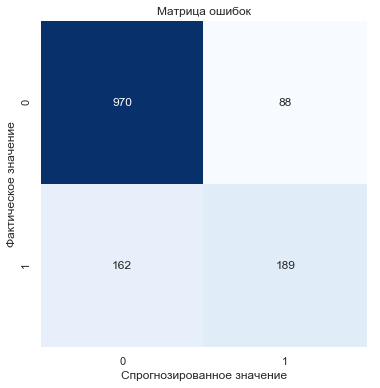

In [46]:
# Преобразование предсказанных вероятностей в двоичные предсказания
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)

# Вычислим матрицу путаницы для двоичных предсказаний
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)

# Вычислим точность
accuracy = accuracy_score(y_test, y_test_pred_binary)

# Визуализируем матрицу путаницы
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, annot_kws={"size": 12})
plt.xlabel('Спрогнозированное значение')
plt.ylabel('Фактическое значение')
plt.title('Матрица ошибок')
plt.show()

На представленном изображении показана матрица путаницы (ошибок), полученная на основе модели классификации. Вот интерпретация:

Матрица путаницы:
- Матрица показывает эффективность модели классификации на тестовых данных.
- Есть два класса, которые мы можем принять за «0» (отрицательный класс, клиент не ушел) и «1» (положительный класс, клиент ушел).
- Верхний левый квадрат (темно-синий) с номером 970 представляет собой **Истинные негативы (TN)**: случаи, когда модель правильно предсказала отрицательный класс.
- Правый нижний квадрат (голубой) с номером 189 представляет собой **Истинные положительные результаты (TP)**: случаи, когда модель правильно предсказала положительный класс.
- Верхний правый квадрат (средний синий) с номером 88 представляет собой **Ложные положительные результаты (FP)**: случаи, когда модель неправильно предсказала положительный класс.

Для нашей модели:

- **Истинно отрицательные числа (TN):** 970 – модель правильно предсказала отрицательный класс (клиенты, которые не ушли).
- **Ложно-отрицательные результаты (FN):** 162 – Модель неправильно предсказала отрицательный класс (клиенты, которые ушли, но модель предсказывала, что этого не произойдет).
- **Истинные положительные результаты (TP):** 189 – Модель правильно предсказала положительный класс (ушедших клиентов).
- **Ложные положительные результаты (FP):** 88. Модель неправильно предсказала положительный класс (клиенты, которые не ушли, но модель предсказала, что это произойдет).

**На основе матрицы ошибок сделаем следующие выводы:**

- Модель имеет тенденцию иметь больше ложноотрицательных результатов, чем ложноположительных, что может указывать на консервативный прогноз для положительного класса (например, она более осторожна в прогнозировании оттока).
- Число истинных положительных результатов относительно невелико по сравнению с истинными отрицательными, что может свидетельствовать о том, что модель лучше идентифицирует отрицательный класс или о наличии дисбаланса классов.

Чтобы лучше понять производительность модели, также следует взглянуть на кривую precision-recall и кривую ROC, особенно в такой области, как прогнозирование оттока, где стоимость ложноотрицательных результатов может быть выше, чем ложноположительных.

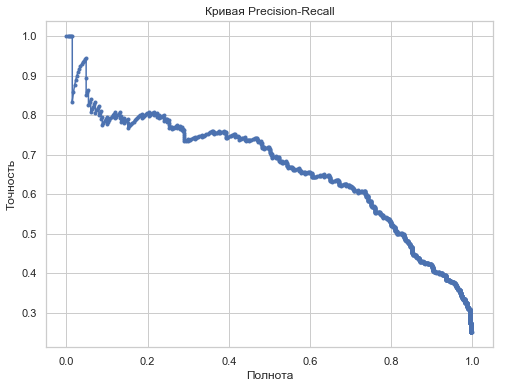

In [47]:
# Вычислим Precision-Recall кривую
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)

# Построим кривую Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Кривая Precision-Recall')
plt.xlabel('Полнота')
plt.ylabel('Точность')
plt.show()

На изображении показана кривая Precision-Recall для нашей модели классификации. Кривая Precision-Recall — это график, который отображает компромисс между точностью (ось Y) и полнотой (ось X) для различных порогов вероятности.

Вот как интерпретировать кривую Precision-Recall на графике:

- Кривая начинается с высокой точностью при низких уровнях полноты, что указывает на то, что, когда модель настроена на очень избирательную работу (предсказывает мало положительных результатов), она очень точна в этих прогнозах.
- По мере увеличения полноты точность постепенно снижается. Это ожидаемо, потому что, поскольку модель пытается охватить больше положительных случаев (увеличение полноты), она также с большей вероятностью неправильно пометит некоторые отрицательные случаи как положительные (снижение точности).
- Кривая не касается правого верхнего угла, что соответствует идеальной модели (100% точность и полнота). Тем не менее, похоже, что модель сохраняет относительно высокую точность для уровней полноты примерно до 0,6, что является хорошим признаком эффективности модели, особенно в контексте несбалансированного набора данных, что типично для сценариев прогнозирования оттока.

На изображении показана кривая точности-отзыва для вашей модели классификации. Кривая точности-отзыва — это график, который отображает компромисс между точностью (ось Y) и полнотой отзыва (ось X) для различных порогов вероятности.

Вот как интерпретировать кривую точности-отзыва на графике:

- Кривая начинается с высокой точностью при низких уровнях полноты, что указывает на то, что, когда модель настроена на очень избирательную работу (предсказывает мало положительных результатов), она очень точна в этих прогнозах.
- По мере увеличения полноты точность постепенно снижается. Это ожидаемо, потому что, поскольку модель пытается охватить больше положительных случаев (увеличение отзыва), она также с большей вероятностью неправильно пометит некоторые отрицательные случаи как положительные (снижение точности).
- Кривая не касается правого верхнего угла, что соответствует идеальной модели (100% точность и полнота). Тем не менее, похоже, что модель сохраняет относительно высокую точность для уровней отзыва примерно до 0,6, что является хорошим признаком эффективности модели, особенно в контексте несбалансированного набора данных, что типично для сценариев прогнозирования оттока, где количество ушедших клиентов может быть намного меньше, чем не ушедших клиентов. Более высокая площадь под кривой Precision-Recall указывает на лучшую модель.

Тестовый показатель ROC-AUC составляет 0.86, что показывает, что модель обладает хорошей способностью различать классы. Объединив это с кривой Precision-Recall, можно сказать что модель, по-видимому, работает хорошо не только в целом, но и в отношении баланса между точностью и полнотой, что может иметь решающее значение для бизнес-решений, основанных на правильном выявлении оттока.

Для принятия действенных бизнес-решений можно учитывать стоимость ложных положительных результатов (предложение скидок клиентам, которые не собираются уходить) и ложных негативов (упущение возможности удержать уходящего клиента). В зависимости от этих затрат можно отдать приоритет точности над полнотой или наоборот.